## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


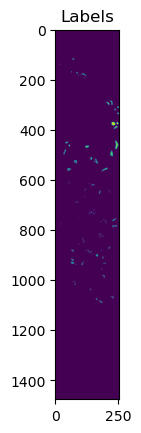

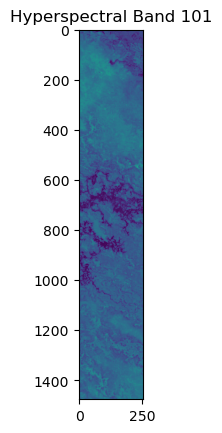

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S

In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2187, PSNR: -10.3687


Epoch [1/50] Training Loss: 0.2087, PSNR: -8.7593
	[Val]   Batch [1/11] Loss: 0.2030, PSNR: -6.1129
	[Val]   Batch [10/11] Loss: 0.2032, PSNR: -8.3518
Epoch [1/50] Validation Loss: 0.2030, PSNR: -8.0437

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1919, PSNR: -7.4517


Epoch [2/50] Training Loss: 0.1865, PSNR: -8.2105
	[Val]   Batch [1/11] Loss: 0.1743, PSNR: -5.4498
	[Val]   Batch [10/11] Loss: 0.1745, PSNR: -7.6910
Epoch [2/50] Validation Loss: 0.1742, PSNR: -7.3789

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1735, PSNR: -9.6537


Epoch [3/50] Training Loss: 0.1660, PSNR: -7.8567
	[Val]   Batch [1/11] Loss: 0.1504, PSNR: -4.8103
	[Val]   Batch [10/11] Loss: 0.1506, PSNR: -7.0510
Epoch [3/50] Validation Loss: 0.1503, PSNR: -6.7384

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1541, PSNR: -7.8568


Epoch [4/50] Training Loss: 0.1464, PSNR: -7.3225
	[Val]   Batch [1/11] Loss: 0.1308, PSNR: -4.2044
	[Val]   Batch [10/11] Loss: 0.1310, PSNR: -6.4446
Epoch [4/50] Validation Loss: 0.1307, PSNR: -6.1315

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1336, PSNR: -6.2315


Epoch [5/50] Training Loss: 0.1280, PSNR: -6.6232
	[Val]   Batch [1/11] Loss: 0.1138, PSNR: -3.5986
	[Val]   Batch [10/11] Loss: 0.1139, PSNR: -5.8389
Epoch [5/50] Validation Loss: 0.1138, PSNR: -5.5280

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1171, PSNR: -5.6560


Epoch [6/50] Training Loss: 0.1111, PSNR: -6.1204
	[Val]   Batch [1/11] Loss: 0.0973, PSNR: -2.9179
	[Val]   Batch [10/11] Loss: 0.0974, PSNR: -5.1586
Epoch [6/50] Validation Loss: 0.0973, PSNR: -4.8492

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1008, PSNR: -4.3871


Epoch [7/50] Training Loss: 0.0961, PSNR: -5.2846
	[Val]   Batch [1/11] Loss: 0.0866, PSNR: -2.4111
	[Val]   Batch [10/11] Loss: 0.0866, PSNR: -4.6485
Epoch [7/50] Validation Loss: 0.0866, PSNR: -4.3423

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0871, PSNR: -2.4365


Epoch [8/50] Training Loss: 0.0830, PSNR: -4.5486
	[Val]   Batch [1/11] Loss: 0.0736, PSNR: -1.7051
	[Val]   Batch [10/11] Loss: 0.0736, PSNR: -3.9424
Epoch [8/50] Validation Loss: 0.0736, PSNR: -3.6360

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0751, PSNR: -1.7937


Epoch [9/50] Training Loss: 0.0719, PSNR: -4.2008
	[Val]   Batch [1/11] Loss: 0.0666, PSNR: -1.2731
	[Val]   Batch [10/11] Loss: 0.0666, PSNR: -3.5100
Epoch [9/50] Validation Loss: 0.0666, PSNR: -3.2049

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0659, PSNR: -4.0777


Epoch [10/50] Training Loss: 0.0625, PSNR: -3.5752
	[Val]   Batch [1/11] Loss: 0.0565, PSNR: -0.5590
	[Val]   Batch [10/11] Loss: 0.0566, PSNR: -2.7977
Epoch [10/50] Validation Loss: 0.0565, PSNR: -2.4905

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0578, PSNR: -0.6585


Epoch [11/50] Training Loss: 0.0546, PSNR: -2.8572
	[Val]   Batch [1/11] Loss: 0.0521, PSNR: -0.2027
	[Val]   Batch [10/11] Loss: 0.0521, PSNR: -2.4418
Epoch [11/50] Validation Loss: 0.0521, PSNR: -2.1351

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0497, PSNR: -1.5870


Epoch [12/50] Training Loss: 0.0481, PSNR: -2.3734
	[Val]   Batch [1/11] Loss: 0.0449, PSNR: 0.4413
	[Val]   Batch [10/11] Loss: 0.0449, PSNR: -1.7989
Epoch [12/50] Validation Loss: 0.0449, PSNR: -1.4926

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0444, PSNR: -1.9321


Epoch [13/50] Training Loss: 0.0426, PSNR: -1.6418
	[Val]   Batch [1/11] Loss: 0.0404, PSNR: 0.9038
	[Val]   Batch [10/11] Loss: 0.0404, PSNR: -1.3375
Epoch [13/50] Validation Loss: 0.0404, PSNR: -1.0302

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0389, PSNR: -2.3611


Epoch [14/50] Training Loss: 0.0379, PSNR: -1.3553
	[Val]   Batch [1/11] Loss: 0.0365, PSNR: 1.3441
	[Val]   Batch [10/11] Loss: 0.0365, PSNR: -0.8970
Epoch [14/50] Validation Loss: 0.0365, PSNR: -0.5895

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0351, PSNR: 1.5039


Epoch [15/50] Training Loss: 0.0339, PSNR: -1.0055
	[Val]   Batch [1/11] Loss: 0.0325, PSNR: 1.8436
	[Val]   Batch [10/11] Loss: 0.0325, PSNR: -0.3979
Epoch [15/50] Validation Loss: 0.0325, PSNR: -0.0895

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0315, PSNR: 0.6618


Epoch [16/50] Training Loss: 0.0305, PSNR: -0.3534
	[Val]   Batch [1/11] Loss: 0.0295, PSNR: 2.2612
	[Val]   Batch [10/11] Loss: 0.0296, PSNR: 0.0201
Epoch [16/50] Validation Loss: 0.0295, PSNR: 0.3283

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0283, PSNR: 0.8603


Epoch [17/50] Training Loss: 0.0276, PSNR: 0.0065
	[Val]   Batch [1/11] Loss: 0.0268, PSNR: 2.6783
	[Val]   Batch [10/11] Loss: 0.0268, PSNR: 0.4380
Epoch [17/50] Validation Loss: 0.0268, PSNR: 0.7453

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0258, PSNR: -1.7237


Epoch [18/50] Training Loss: 0.0251, PSNR: 0.3131
	[Val]   Batch [1/11] Loss: 0.0246, PSNR: 3.0452
	[Val]   Batch [10/11] Loss: 0.0247, PSNR: 0.8050
Epoch [18/50] Validation Loss: 0.0247, PSNR: 1.1125

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0242, PSNR: 0.2037


Epoch [19/50] Training Loss: 0.0229, PSNR: 0.5635
	[Val]   Batch [1/11] Loss: 0.0224, PSNR: 3.4560
	[Val]   Batch [10/11] Loss: 0.0224, PSNR: 1.2159
Epoch [19/50] Validation Loss: 0.0224, PSNR: 1.5234

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0213, PSNR: 1.7495


Epoch [20/50] Training Loss: 0.0210, PSNR: 1.1352
	[Val]   Batch [1/11] Loss: 0.0207, PSNR: 3.7974
	[Val]   Batch [10/11] Loss: 0.0207, PSNR: 1.5580
Epoch [20/50] Validation Loss: 0.0207, PSNR: 1.8650

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0198, PSNR: 2.0626


Epoch [21/50] Training Loss: 0.0193, PSNR: 1.8460
	[Val]   Batch [1/11] Loss: 0.0190, PSNR: 4.1735
	[Val]   Batch [10/11] Loss: 0.0190, PSNR: 1.9337
Epoch [21/50] Validation Loss: 0.0190, PSNR: 2.2415

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0181, PSNR: 0.1558


Epoch [22/50] Training Loss: 0.0178, PSNR: 1.9118
	[Val]   Batch [1/11] Loss: 0.0176, PSNR: 4.5096
	[Val]   Batch [10/11] Loss: 0.0176, PSNR: 2.2705
Epoch [22/50] Validation Loss: 0.0176, PSNR: 2.5781

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0171, PSNR: 2.7043


Epoch [23/50] Training Loss: 0.0165, PSNR: 2.4713
	[Val]   Batch [1/11] Loss: 0.0163, PSNR: 4.8372
	[Val]   Batch [10/11] Loss: 0.0163, PSNR: 2.5993
Epoch [23/50] Validation Loss: 0.0163, PSNR: 2.9061

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0155, PSNR: 3.4834


Epoch [24/50] Training Loss: 0.0153, PSNR: 2.6508
	[Val]   Batch [1/11] Loss: 0.0152, PSNR: 5.1364
	[Val]   Batch [10/11] Loss: 0.0152, PSNR: 2.8989
Epoch [24/50] Validation Loss: 0.0152, PSNR: 3.2054

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0145, PSNR: 5.3585


Epoch [25/50] Training Loss: 0.0142, PSNR: 2.9238
	[Val]   Batch [1/11] Loss: 0.0142, PSNR: 5.4470
	[Val]   Batch [10/11] Loss: 0.0142, PSNR: 3.2091
Epoch [25/50] Validation Loss: 0.0142, PSNR: 3.5160

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0138, PSNR: 3.6357


Epoch [26/50] Training Loss: 0.0133, PSNR: 3.3295
	[Val]   Batch [1/11] Loss: 0.0133, PSNR: 5.7127
	[Val]   Batch [10/11] Loss: 0.0133, PSNR: 3.4742
Epoch [26/50] Validation Loss: 0.0133, PSNR: 3.7814

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0125, PSNR: 3.1284


Epoch [27/50] Training Loss: 0.0125, PSNR: 3.5802
	[Val]   Batch [1/11] Loss: 0.0124, PSNR: 6.0173
	[Val]   Batch [10/11] Loss: 0.0124, PSNR: 3.7779
Epoch [27/50] Validation Loss: 0.0124, PSNR: 4.0863

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0114, PSNR: 5.0767


Epoch [28/50] Training Loss: 0.0117, PSNR: 3.7298
	[Val]   Batch [1/11] Loss: 0.0117, PSNR: 6.2849
	[Val]   Batch [10/11] Loss: 0.0117, PSNR: 4.0450
Epoch [28/50] Validation Loss: 0.0117, PSNR: 4.3547

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0116, PSNR: 6.3259


Epoch [29/50] Training Loss: 0.0110, PSNR: 4.2708
	[Val]   Batch [1/11] Loss: 0.0111, PSNR: 6.5150
	[Val]   Batch [10/11] Loss: 0.0111, PSNR: 4.2754
Epoch [29/50] Validation Loss: 0.0111, PSNR: 4.5844

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0105, PSNR: 4.8146


Epoch [30/50] Training Loss: 0.0103, PSNR: 4.2722
	[Val]   Batch [1/11] Loss: 0.0103, PSNR: 6.8394
	[Val]   Batch [10/11] Loss: 0.0103, PSNR: 4.6019
Epoch [30/50] Validation Loss: 0.0103, PSNR: 4.9093

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0097, PSNR: 5.5211


Epoch [31/50] Training Loss: 0.0097, PSNR: 4.4971
	[Val]   Batch [1/11] Loss: 0.0098, PSNR: 7.0592
	[Val]   Batch [10/11] Loss: 0.0098, PSNR: 4.8214
Epoch [31/50] Validation Loss: 0.0098, PSNR: 5.1294

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0094, PSNR: 5.9128


Epoch [32/50] Training Loss: 0.0092, PSNR: 4.6749
	[Val]   Batch [1/11] Loss: 0.0093, PSNR: 7.2872
	[Val]   Batch [10/11] Loss: 0.0093, PSNR: 5.0497
Epoch [32/50] Validation Loss: 0.0093, PSNR: 5.3580

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0090, PSNR: 5.5031


Epoch [33/50] Training Loss: 0.0087, PSNR: 4.9800
	[Val]   Batch [1/11] Loss: 0.0088, PSNR: 7.5159
	[Val]   Batch [10/11] Loss: 0.0088, PSNR: 5.2790
Epoch [33/50] Validation Loss: 0.0088, PSNR: 5.5867

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0083, PSNR: 6.4729


Epoch [34/50] Training Loss: 0.0083, PSNR: 5.1585
	[Val]   Batch [1/11] Loss: 0.0083, PSNR: 7.7611
	[Val]   Batch [10/11] Loss: 0.0083, PSNR: 5.5240
Epoch [34/50] Validation Loss: 0.0083, PSNR: 5.8322

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0081, PSNR: 4.8854


Epoch [35/50] Training Loss: 0.0078, PSNR: 5.4780
	[Val]   Batch [1/11] Loss: 0.0079, PSNR: 7.9777
	[Val]   Batch [10/11] Loss: 0.0079, PSNR: 5.7412
Epoch [35/50] Validation Loss: 0.0079, PSNR: 6.0498

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0073, PSNR: 8.3078


Epoch [36/50] Training Loss: 0.0075, PSNR: 5.7635
	[Val]   Batch [1/11] Loss: 0.0075, PSNR: 8.1952
	[Val]   Batch [10/11] Loss: 0.0075, PSNR: 5.9595
Epoch [36/50] Validation Loss: 0.0075, PSNR: 6.2680

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 8.4199


Epoch [37/50] Training Loss: 0.0071, PSNR: 5.9364
	[Val]   Batch [1/11] Loss: 0.0072, PSNR: 8.4134
	[Val]   Batch [10/11] Loss: 0.0072, PSNR: 6.1783
Epoch [37/50] Validation Loss: 0.0072, PSNR: 6.4866

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0068, PSNR: 6.6864


Epoch [38/50] Training Loss: 0.0068, PSNR: 6.0889
	[Val]   Batch [1/11] Loss: 0.0068, PSNR: 8.6292
	[Val]   Batch [10/11] Loss: 0.0068, PSNR: 6.3941
Epoch [38/50] Validation Loss: 0.0068, PSNR: 6.7033

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 6.8345


Epoch [39/50] Training Loss: 0.0064, PSNR: 6.4054
	[Val]   Batch [1/11] Loss: 0.0065, PSNR: 8.8477
	[Val]   Batch [10/11] Loss: 0.0065, PSNR: 6.6126
Epoch [39/50] Validation Loss: 0.0065, PSNR: 6.9217

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0063, PSNR: 6.5176


Epoch [40/50] Training Loss: 0.0061, PSNR: 6.4279
	[Val]   Batch [1/11] Loss: 0.0062, PSNR: 9.0243
	[Val]   Batch [10/11] Loss: 0.0062, PSNR: 6.7889
Epoch [40/50] Validation Loss: 0.0062, PSNR: 7.0982

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 7.5634


Epoch [41/50] Training Loss: 0.0059, PSNR: 6.8642
	[Val]   Batch [1/11] Loss: 0.0059, PSNR: 9.2348
	[Val]   Batch [10/11] Loss: 0.0059, PSNR: 6.9993
Epoch [41/50] Validation Loss: 0.0059, PSNR: 7.3089

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0059, PSNR: 7.6994


Epoch [42/50] Training Loss: 0.0056, PSNR: 7.1263
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.4188
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1828
Epoch [42/50] Validation Loss: 0.0057, PSNR: 7.4938

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0055, PSNR: 7.3241


Epoch [43/50] Training Loss: 0.0054, PSNR: 7.1212
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5902
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3545
Epoch [43/50] Validation Loss: 0.0055, PSNR: 7.6660

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 5.7528


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.3192
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.8266
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5905
Epoch [44/50] Validation Loss: 0.0052, PSNR: 7.9022

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 5.7244


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.4760
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 10.0110
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7752
Epoch [45/50] Validation Loss: 0.0049, PSNR: 8.0868

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 5.8849


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.7366
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1936
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.9590
Epoch [46/50] Validation Loss: 0.0047, PSNR: 8.2690

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0046, PSNR: 6.9075


Epoch [47/50] Training Loss: 0.0045, PSNR: 7.9867
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3441
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.1105
Epoch [47/50] Validation Loss: 0.0046, PSNR: 8.4197

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 7.2051


Epoch [48/50] Training Loss: 0.0043, PSNR: 8.1519
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5245
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.2918
Epoch [48/50] Validation Loss: 0.0044, PSNR: 8.6001

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 7.9508


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.2573
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7089
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.4767
Epoch [49/50] Validation Loss: 0.0042, PSNR: 8.7854

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0039, PSNR: 9.4317


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.4866
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8820
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.6495
Epoch [50/50] Validation Loss: 0.0040, PSNR: 8.9589


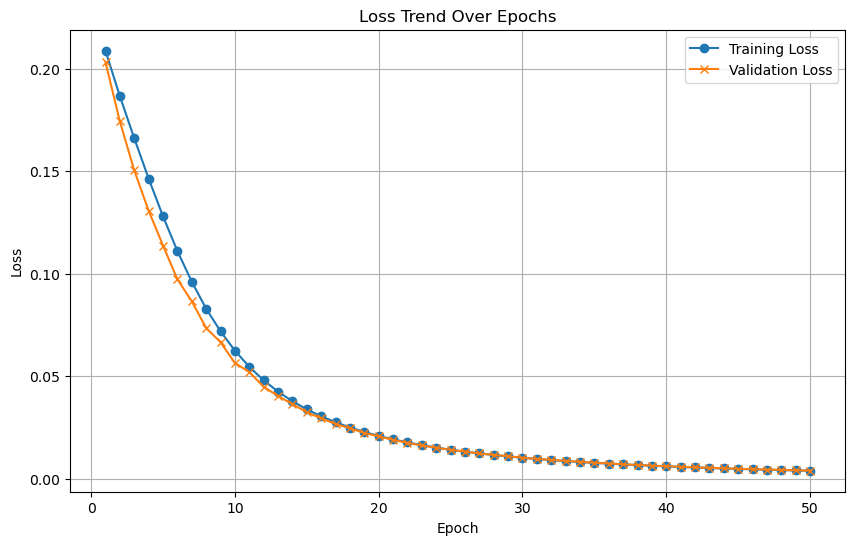

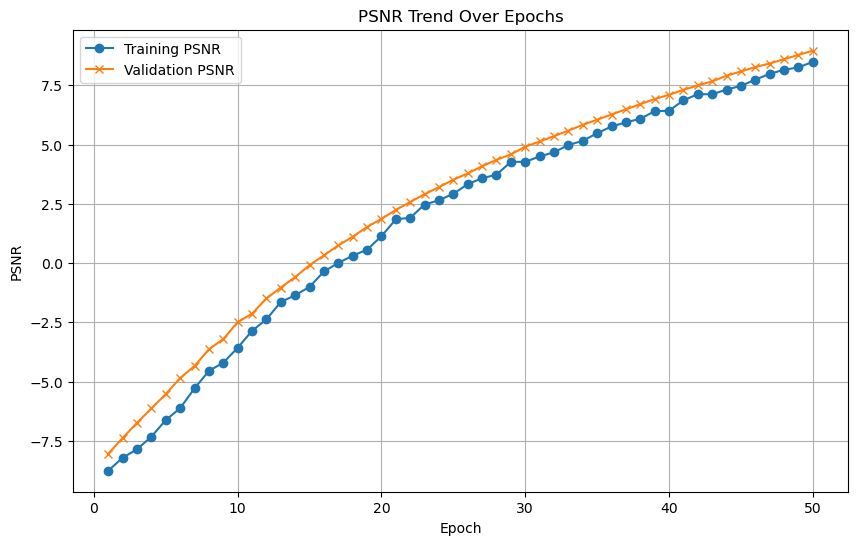

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6356
    Validation Batch [1/1], Loss: 2.6454
Validation Loss: 2.6454, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6454. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5906
    Validation Batch [1/1], Loss: 2.6454
Validation Loss: 2.6454, Validation Accuracy: 7.14%
Validation loss improved from 2.6454 to 2.6454. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5665
    Validation Batch [1/1], Loss: 2.6453
Validation Loss: 2.6453, Validation Accuracy: 7.14%
Validation loss improved from 2.6454 to 2.6453. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5473
    Validation Batch [1/1], Loss: 2.6453
Validation Loss: 2.6453, Validation Accuracy: 7.14%
Validation loss improved from 2.6453 to 2.6453. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

Epoch [16/1000] completed, Average Training Loss: 2.3692
    Validation Batch [1/1], Loss: 2.6441
Validation Loss: 2.6441, Validation Accuracy: 7.14%
Validation loss improved from 2.6443 to 2.6441. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.3641
    Validation Batch [1/1], Loss: 2.6439
Validation Loss: 2.6439, Validation Accuracy: 7.14%
Validation loss improved from 2.6441 to 2.6439. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.3551
    Validation Batch [1/1], Loss: 2.6438
Validation Loss: 2.6438, Validation Accuracy: 7.14%
Validation loss improved from 2.6439 to 2.6438. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.3460
    Validation Batch [1/1], Loss: 2.6435
Validation Loss: 2.6435, Validation Accuracy: 14.29%
Validation loss improved from 2.6438 to 2.6435. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1

Epoch [26/1000] completed, Average Training Loss: 2.2830
    Validation Batch [1/1], Loss: 2.6415
Validation Loss: 2.6415, Validation Accuracy: 7.14%
Validation loss improved from 2.6420 to 2.6415. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2537
    Validation Batch [1/1], Loss: 2.6411
Validation Loss: 2.6411, Validation Accuracy: 7.14%
Validation loss improved from 2.6415 to 2.6411. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.2517
    Validation Batch [1/1], Loss: 2.6407
Validation Loss: 2.6407, Validation Accuracy: 12.86%
Validation loss improved from 2.6411 to 2.6407. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 2.2471
    Validation Batch [1/1], Loss: 2.6403
Validation Loss: 2.6403, Validation Accuracy: 14.29%
Validation loss improved from 2.6407 to 2.6403. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/

Epoch [40/1000] completed, Average Training Loss: 2.1481
    Validation Batch [1/1], Loss: 2.6331
Validation Loss: 2.6331, Validation Accuracy: 17.14%
Validation loss improved from 2.6341 to 2.6331. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.1357
    Validation Batch [1/1], Loss: 2.6321
Validation Loss: 2.6321, Validation Accuracy: 21.43%
Validation loss improved from 2.6331 to 2.6321. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.1300
    Validation Batch [1/1], Loss: 2.6308
Validation Loss: 2.6308, Validation Accuracy: 17.14%
Validation loss improved from 2.6321 to 2.6308. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.1351
    Validation Batch [1/1], Loss: 2.6296
Validation Loss: 2.6296, Validation Accuracy: 14.29%
Validation loss improved from 2.6308 to 2.6296. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [4

Epoch [50/1000] completed, Average Training Loss: 2.0742
    Validation Batch [1/1], Loss: 2.6135
Validation Loss: 2.6135, Validation Accuracy: 14.29%
Validation loss improved from 2.6167 to 2.6135. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.0613
    Validation Batch [1/1], Loss: 2.6099
Validation Loss: 2.6099, Validation Accuracy: 14.29%
Validation loss improved from 2.6135 to 2.6099. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.0357
    Validation Batch [1/1], Loss: 2.6056
Validation Loss: 2.6056, Validation Accuracy: 14.29%
Validation loss improved from 2.6099 to 2.6056. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.0441
    Validation Batch [1/1], Loss: 2.6007
Validation Loss: 2.6007, Validation Accuracy: 14.29%
Validation loss improved from 2.6056 to 2.6007. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 2.4986
Validation Loss: 2.4986, Validation Accuracy: 17.14%
Validation loss improved from 2.5134 to 2.4986. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.9171
    Validation Batch [1/1], Loss: 2.4798
Validation Loss: 2.4798, Validation Accuracy: 18.57%
Validation loss improved from 2.4986 to 2.4798. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.9237
    Validation Batch [1/1], Loss: 2.4600
Validation Loss: 2.4600, Validation Accuracy: 24.29%
Validation loss improved from 2.4798 to 2.4600. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.9142
    Validation Batch [1/1], Loss: 2.4429
Validation Loss: 2.4429, Validation Accuracy: 30.00%
Validation loss improved from 2.4600 to 2.4429. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.9167
    Vali

Epoch [75/1000] completed, Average Training Loss: 1.8671
    Validation Batch [1/1], Loss: 2.2418
Validation Loss: 2.2418, Validation Accuracy: 54.29%
Validation loss improved from 2.2802 to 2.2418. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.8410
    Validation Batch [1/1], Loss: 2.2139
Validation Loss: 2.2139, Validation Accuracy: 55.71%
Validation loss improved from 2.2418 to 2.2139. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.8343
    Validation Batch [1/1], Loss: 2.1998
Validation Loss: 2.1998, Validation Accuracy: 55.71%
Validation loss improved from 2.2139 to 2.1998. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.8333
    Validation Batch [1/1], Loss: 2.1887
Validation Loss: 2.1887, Validation Accuracy: 54.29%
Validation loss improved from 2.1998 to 2.1887. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 1.9466
Validation Loss: 1.9466, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.7299
    Validation Batch [1/1], Loss: 1.9189
Validation Loss: 1.9189, Validation Accuracy: 72.86%
Validation loss improved from 1.9454 to 1.9189. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.7614
    Validation Batch [1/1], Loss: 1.8805
Validation Loss: 1.8805, Validation Accuracy: 75.71%
Validation loss improved from 1.9189 to 1.8805. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.7176
    Validation Batch [1/1], Loss: 1.8480
Validation Loss: 1.8480, Validation Accuracy: 77.14%
Validation loss improved from 1.8805 to 1.8480. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.7282
    Validation Batch [1

Epoch [97/1000] completed, Average Training Loss: 1.6530
    Validation Batch [1/1], Loss: 1.7327
Validation Loss: 1.7327, Validation Accuracy: 78.57%
Validation loss improved from 1.7479 to 1.7327. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.6820
    Validation Batch [1/1], Loss: 1.7299
Validation Loss: 1.7299, Validation Accuracy: 82.86%
Validation loss improved from 1.7327 to 1.7299. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.6560
    Validation Batch [1/1], Loss: 1.7047
Validation Loss: 1.7047, Validation Accuracy: 82.86%
Validation loss improved from 1.7299 to 1.7047. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.6546
    Validation Batch [1/1], Loss: 1.6734
Validation Loss: 1.6734, Validation Accuracy: 80.00%
Validation loss improved from 1.7047 to 1.6734. Saving model...

LOG: Epoch [101/1000] - Training
Epoch

    Validation Batch [1/1], Loss: 1.5124
Validation Loss: 1.5124, Validation Accuracy: 85.71%
Validation loss improved from 1.5315 to 1.5124. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.5077
    Validation Batch [1/1], Loss: 1.4979
Validation Loss: 1.4979, Validation Accuracy: 85.71%
Validation loss improved from 1.5124 to 1.4979. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.5236
    Validation Batch [1/1], Loss: 1.4894
Validation Loss: 1.4894, Validation Accuracy: 88.57%
Validation loss improved from 1.4979 to 1.4894. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.5191
    Validation Batch [1/1], Loss: 1.4864
Validation Loss: 1.4864, Validation Accuracy: 88.57%
Validation loss improved from 1.4894 to 1.4864. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.4603


Epoch [119/1000] completed, Average Training Loss: 1.4747
    Validation Batch [1/1], Loss: 1.4567
Validation Loss: 1.4567, Validation Accuracy: 87.14%
Validation loss improved from 1.4719 to 1.4567. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.4817
    Validation Batch [1/1], Loss: 1.4471
Validation Loss: 1.4471, Validation Accuracy: 87.14%
Validation loss improved from 1.4567 to 1.4471. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.4513
    Validation Batch [1/1], Loss: 1.4378
Validation Loss: 1.4378, Validation Accuracy: 88.57%
Validation loss improved from 1.4471 to 1.4378. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.4684
    Validation Batch [1/1], Loss: 1.4232
Validation Loss: 1.4232, Validation Accuracy: 85.71%
Validation loss improved from 1.4378 to 1.4232. Saving model...

LOG: Epoch [123/1000] - Training


Epoch [136/1000] completed, Average Training Loss: 1.3125
    Validation Batch [1/1], Loss: 1.3014
Validation Loss: 1.3014, Validation Accuracy: 90.00%
Validation loss improved from 1.3114 to 1.3014. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 1.3043
    Validation Batch [1/1], Loss: 1.3204
Validation Loss: 1.3204, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.3112
    Validation Batch [1/1], Loss: 1.3056
Validation Loss: 1.3056, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.3033
    Validation Batch [1/1], Loss: 1.2787
Validation Loss: 1.2787, Validation Accuracy: 94.29%
Validation loss improved from 1.3014 to 1.2787. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Av

Epoch [145/1000] completed, Average Training Loss: 1.2439
    Validation Batch [1/1], Loss: 1.2094
Validation Loss: 1.2094, Validation Accuracy: 94.29%
Validation loss improved from 1.2254 to 1.2094. Saving model...

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.2422
    Validation Batch [1/1], Loss: 1.1977
Validation Loss: 1.1977, Validation Accuracy: 94.29%
Validation loss improved from 1.2094 to 1.1977. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.2053
    Validation Batch [1/1], Loss: 1.1905
Validation Loss: 1.1905, Validation Accuracy: 91.43%
Validation loss improved from 1.1977 to 1.1905. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.2097
    Validation Batch [1/1], Loss: 1.1956
Validation Loss: 1.1956, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000

    Validation Batch [1/1], Loss: 1.0940
Validation Loss: 1.0940, Validation Accuracy: 95.71%
Validation loss improved from 1.0958 to 1.0940. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 1.1080
    Validation Batch [1/1], Loss: 1.0723
Validation Loss: 1.0723, Validation Accuracy: 95.71%
Validation loss improved from 1.0940 to 1.0723. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 1.1336
    Validation Batch [1/1], Loss: 1.0559
Validation Loss: 1.0559, Validation Accuracy: 98.57%
Validation loss improved from 1.0723 to 1.0559. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.1076
    Validation Batch [1/1], Loss: 1.0513
Validation Loss: 1.0513, Validation Accuracy: 98.57%
Validation loss improved from 1.0559 to 1.0513. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.0851


    Validation Batch [1/1], Loss: 1.0296
Validation Loss: 1.0296, Validation Accuracy: 97.14%
Validation loss improved from 1.0308 to 1.0296. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.0830
    Validation Batch [1/1], Loss: 1.0302
Validation Loss: 1.0302, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.0540
    Validation Batch [1/1], Loss: 1.0334
Validation Loss: 1.0334, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.0509
    Validation Batch [1/1], Loss: 1.0036
Validation Loss: 1.0036, Validation Accuracy: 97.14%
Validation loss improved from 1.0296 to 1.0036. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.0029
    Validation Batch [1/1], Lo

Epoch [184/1000] completed, Average Training Loss: 0.9031
    Validation Batch [1/1], Loss: 0.8715
Validation Loss: 0.8715, Validation Accuracy: 98.57%
Validation loss improved from 0.8894 to 0.8715. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.8793
    Validation Batch [1/1], Loss: 0.8697
Validation Loss: 0.8697, Validation Accuracy: 95.71%
Validation loss improved from 0.8715 to 0.8697. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.8997
    Validation Batch [1/1], Loss: 0.8863
Validation Loss: 0.8863, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.8654
    Validation Batch [1/1], Loss: 0.8757
Validation Loss: 0.8757, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Av

Epoch [189/1000] completed, Average Training Loss: 0.8430
    Validation Batch [1/1], Loss: 0.8333
Validation Loss: 0.8333, Validation Accuracy: 98.57%
Validation loss improved from 0.8409 to 0.8333. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.8796
    Validation Batch [1/1], Loss: 0.8112
Validation Loss: 0.8112, Validation Accuracy: 98.57%
Validation loss improved from 0.8333 to 0.8112. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.8477
    Validation Batch [1/1], Loss: 0.8053
Validation Loss: 0.8053, Validation Accuracy: 98.57%
Validation loss improved from 0.8112 to 0.8053. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.8683
    Validation Batch [1/1], Loss: 0.8095
Validation Loss: 0.8095, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000

Epoch [208/1000] completed, Average Training Loss: 0.7667
    Validation Batch [1/1], Loss: 0.7087
Validation Loss: 0.7087, Validation Accuracy: 95.71%
Validation loss improved from 0.7167 to 0.7087. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.7478
    Validation Batch [1/1], Loss: 0.6893
Validation Loss: 0.6893, Validation Accuracy: 95.71%
Validation loss improved from 0.7087 to 0.6893. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.7288
    Validation Batch [1/1], Loss: 0.6960
Validation Loss: 0.6960, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.7193
    Validation Batch [1/1], Loss: 0.6935
Validation Loss: 0.6935, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Av

Epoch [213/1000] completed, Average Training Loss: 0.7253
    Validation Batch [1/1], Loss: 0.6736
Validation Loss: 0.6736, Validation Accuracy: 97.14%
Validation loss improved from 0.6844 to 0.6736. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.7008
    Validation Batch [1/1], Loss: 0.6627
Validation Loss: 0.6627, Validation Accuracy: 98.57%
Validation loss improved from 0.6736 to 0.6627. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.7173
    Validation Batch [1/1], Loss: 0.6473
Validation Loss: 0.6473, Validation Accuracy: 98.57%
Validation loss improved from 0.6627 to 0.6473. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.6986
    Validation Batch [1/1], Loss: 0.6427
Validation Loss: 0.6427, Validation Accuracy: 97.14%
Validation loss improved from 0.6473 to 0.6427. Saving model...

LOG: Epoch [217/1000] - Training


Epoch [232/1000] completed, Average Training Loss: 0.5870
    Validation Batch [1/1], Loss: 0.5362
Validation Loss: 0.5362, Validation Accuracy: 98.57%
Validation loss improved from 0.5568 to 0.5362. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.5853
    Validation Batch [1/1], Loss: 0.5395
Validation Loss: 0.5395, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.5934
    Validation Batch [1/1], Loss: 0.5386
Validation Loss: 0.5386, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.6018
    Validation Batch [1/1], Loss: 0.5299
Validation Loss: 0.5299, Validation Accuracy: 98.57%
Validation loss improved from 0.5362 to 0.5299. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Av

Epoch [237/1000] completed, Average Training Loss: 0.5694
    Validation Batch [1/1], Loss: 0.5114
Validation Loss: 0.5114, Validation Accuracy: 98.57%
Validation loss improved from 0.5283 to 0.5114. Saving model...

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.5696
    Validation Batch [1/1], Loss: 0.5095
Validation Loss: 0.5095, Validation Accuracy: 97.14%
Validation loss improved from 0.5114 to 0.5095. Saving model...

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.5587
    Validation Batch [1/1], Loss: 0.5045
Validation Loss: 0.5045, Validation Accuracy: 97.14%
Validation loss improved from 0.5095 to 0.5045. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.5461
    Validation Batch [1/1], Loss: 0.5025
Validation Loss: 0.5025, Validation Accuracy: 100.00%
Validation loss improved from 0.5045 to 0.5025. Saving model...

LOG: Epoch [241/1000] - Training

Epoch [256/1000] completed, Average Training Loss: 0.4759
    Validation Batch [1/1], Loss: 0.4405
Validation Loss: 0.4405, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.4366
    Validation Batch [1/1], Loss: 0.4196
Validation Loss: 0.4196, Validation Accuracy: 100.00%
Validation loss improved from 0.4326 to 0.4196. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.4627
    Validation Batch [1/1], Loss: 0.4082
Validation Loss: 0.4082, Validation Accuracy: 97.14%
Validation loss improved from 0.4196 to 0.4082. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.4775
    Validation Batch [1/1], Loss: 0.4114
Validation Loss: 0.4114, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, 

Epoch [261/1000] completed, Average Training Loss: 0.4572
    Validation Batch [1/1], Loss: 0.3797
Validation Loss: 0.3797, Validation Accuracy: 98.57%
Validation loss improved from 0.3989 to 0.3797. Saving model...

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.4546
    Validation Batch [1/1], Loss: 0.3744
Validation Loss: 0.3744, Validation Accuracy: 98.57%
Validation loss improved from 0.3797 to 0.3744. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.4147
    Validation Batch [1/1], Loss: 0.3761
Validation Loss: 0.3761, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.4304
    Validation Batch [1/1], Loss: 0.3814
Validation Loss: 0.3814, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, A

Epoch [279/1000] completed, Average Training Loss: 0.3593
    Validation Batch [1/1], Loss: 0.3267
Validation Loss: 0.3267, Validation Accuracy: 100.00%
Validation loss improved from 0.3313 to 0.3267. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.3548
    Validation Batch [1/1], Loss: 0.3198
Validation Loss: 0.3198, Validation Accuracy: 100.00%
Validation loss improved from 0.3267 to 0.3198. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.3651
    Validation Batch [1/1], Loss: 0.3224
Validation Loss: 0.3224, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.3459
    Validation Batch [1/1], Loss: 0.3301
Validation Loss: 0.3301, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed,

Epoch [284/1000] completed, Average Training Loss: 0.3547
    Validation Batch [1/1], Loss: 0.3130
Validation Loss: 0.3130, Validation Accuracy: 100.00%
Validation loss improved from 0.3198 to 0.3130. Saving model...

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.3644
    Validation Batch [1/1], Loss: 0.3111
Validation Loss: 0.3111, Validation Accuracy: 100.00%
Validation loss improved from 0.3130 to 0.3111. Saving model...

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.3330
    Validation Batch [1/1], Loss: 0.3142
Validation Loss: 0.3142, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.3642
    Validation Batch [1/1], Loss: 0.3183
Validation Loss: 0.3183, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed

Epoch [302/1000] completed, Average Training Loss: 0.2962
    Validation Batch [1/1], Loss: 0.2748
Validation Loss: 0.2748, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3015
    Validation Batch [1/1], Loss: 0.2594
Validation Loss: 0.2594, Validation Accuracy: 100.00%
Validation loss improved from 0.2596 to 0.2594. Saving model...

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3285
    Validation Batch [1/1], Loss: 0.2550
Validation Loss: 0.2550, Validation Accuracy: 100.00%
Validation loss improved from 0.2594 to 0.2550. Saving model...

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.2994
    Validation Batch [1/1], Loss: 0.2617
Validation Loss: 0.2617, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed

Epoch [307/1000] completed, Average Training Loss: 0.3003
    Validation Batch [1/1], Loss: 0.2680
Validation Loss: 0.2680, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.2914
    Validation Batch [1/1], Loss: 0.2663
Validation Loss: 0.2663, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.2870
    Validation Batch [1/1], Loss: 0.2582
Validation Loss: 0.2582, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.2792
    Validation Batch [1/1], Loss: 0.2455
Validation Loss: 0.2455, Validation Accuracy: 100.00%
Validation loss improved from 0.2550 to 0.2455. Saving model...

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Train

Epoch [326/1000] completed, Average Training Loss: 0.2468
    Validation Batch [1/1], Loss: 0.2023
Validation Loss: 0.2023, Validation Accuracy: 100.00%
Validation loss improved from 0.2040 to 0.2023. Saving model...

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.2498
    Validation Batch [1/1], Loss: 0.2138
Validation Loss: 0.2138, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.2512
    Validation Batch [1/1], Loss: 0.2226
Validation Loss: 0.2226, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.2389
    Validation Batch [1/1], Loss: 0.2174
Validation Loss: 0.2174, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Train

Epoch [331/1000] completed, Average Training Loss: 0.2331
    Validation Batch [1/1], Loss: 0.2131
Validation Loss: 0.2131, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.2344
    Validation Batch [1/1], Loss: 0.2067
Validation Loss: 0.2067, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.2266
    Validation Batch [1/1], Loss: 0.2059
Validation Loss: 0.2059, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.2175
    Validation Batch [1/1], Loss: 0.2078
Validation Loss: 0.2078, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.224

    Validation Batch [1/1], Loss: 0.1767
Validation Loss: 0.1767, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2047
    Validation Batch [1/1], Loss: 0.1745
Validation Loss: 0.1745, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.1917
    Validation Batch [1/1], Loss: 0.1749
Validation Loss: 0.1749, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.1951
    Validation Batch [1/1], Loss: 0.1774
Validation Loss: 0.1774, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2262
    Validation Batch [1/1], Loss: 0.1754
Validation Loss

Epoch [356/1000] completed, Average Training Loss: 0.1973
    Validation Batch [1/1], Loss: 0.1562
Validation Loss: 0.1562, Validation Accuracy: 100.00%
Validation loss improved from 0.1622 to 0.1562. Saving model...

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.1960
    Validation Batch [1/1], Loss: 0.1628
Validation Loss: 0.1628, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.1915
    Validation Batch [1/1], Loss: 0.1657
Validation Loss: 0.1657, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.1894
    Validation Batch [1/1], Loss: 0.1665
Validation Loss: 0.1665, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Train

Epoch [372/1000] completed, Average Training Loss: 0.1661
    Validation Batch [1/1], Loss: 0.1491
Validation Loss: 0.1491, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.1589
    Validation Batch [1/1], Loss: 0.1500
Validation Loss: 0.1500, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.1556
    Validation Batch [1/1], Loss: 0.1502
Validation Loss: 0.1502, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.1724
    Validation Batch [1/1], Loss: 0.1473
Validation Loss: 0.1473, Validation Accuracy: 100.00%
Validation loss improved from 0.1476 to 0.1473. Saving model...

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Train

Epoch [379/1000] completed, Average Training Loss: 0.1621
    Validation Batch [1/1], Loss: 0.1435
Validation Loss: 0.1435, Validation Accuracy: 100.00%
Validation loss improved from 0.1466 to 0.1435. Saving model...

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.1596
    Validation Batch [1/1], Loss: 0.1476
Validation Loss: 0.1476, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.1538
    Validation Batch [1/1], Loss: 0.1459
Validation Loss: 0.1459, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.1590
    Validation Batch [1/1], Loss: 0.1437
Validation Loss: 0.1437, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Train

Epoch [395/1000] completed, Average Training Loss: 0.1444
    Validation Batch [1/1], Loss: 0.1329
Validation Loss: 0.1329, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.1469
    Validation Batch [1/1], Loss: 0.1316
Validation Loss: 0.1316, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1433
    Validation Batch [1/1], Loss: 0.1306
Validation Loss: 0.1306, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1453
    Validation Batch [1/1], Loss: 0.1290
Validation Loss: 0.1290, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.144

Epoch [401/1000] completed, Average Training Loss: 0.1622
    Validation Batch [1/1], Loss: 0.1295
Validation Loss: 0.1295, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1337
    Validation Batch [1/1], Loss: 0.1429
Validation Loss: 0.1429, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.1403
    Validation Batch [1/1], Loss: 0.1477
Validation Loss: 0.1477, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1431
    Validation Batch [1/1], Loss: 0.1552
Validation Loss: 0.1552, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.138

Epoch [416/1000] completed, Average Training Loss: 0.1144
    Validation Batch [1/1], Loss: 0.1186
Validation Loss: 0.1186, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1374
    Validation Batch [1/1], Loss: 0.1137
Validation Loss: 0.1137, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1228
    Validation Batch [1/1], Loss: 0.1042
Validation Loss: 0.1042, Validation Accuracy: 100.00%
Validation loss improved from 0.1043 to 0.1042. Saving model...

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1295
    Validation Batch [1/1], Loss: 0.1050
Validation Loss: 0.1050, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Train

Epoch [423/1000] completed, Average Training Loss: 0.1235
    Validation Batch [1/1], Loss: 0.1322
Validation Loss: 0.1322, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1370
    Validation Batch [1/1], Loss: 0.1199
Validation Loss: 0.1199, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1201
    Validation Batch [1/1], Loss: 0.1094
Validation Loss: 0.1094, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1340
    Validation Batch [1/1], Loss: 0.1034
Validation Loss: 0.1034, Validation Accuracy: 100.00%
Validation loss improved from 0.1042 to 0.1034. Saving model...

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 0.1100
Validation Loss: 0.1100, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.1132
    Validation Batch [1/1], Loss: 0.1090
Validation Loss: 0.1090, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.1141
    Validation Batch [1/1], Loss: 0.1054
Validation Loss: 0.1054, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1127
    Validation Batch [1/1], Loss: 0.1100
Validation Loss: 0.1100, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1086
    Validation Batch [1/1], Loss: 0.1056
Validation Loss

Epoch [447/1000] completed, Average Training Loss: 0.1228
    Validation Batch [1/1], Loss: 0.1080
Validation Loss: 0.1080, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1148
    Validation Batch [1/1], Loss: 0.1166
Validation Loss: 0.1166, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1065
    Validation Batch [1/1], Loss: 0.1168
Validation Loss: 0.1168, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.1083
    Validation Batch [1/1], Loss: 0.1060
Validation Loss: 0.1060, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.1

Epoch [454/1000] completed, Average Training Loss: 0.1067
    Validation Batch [1/1], Loss: 0.0836
Validation Loss: 0.0836, Validation Accuracy: 100.00%
Validation loss improved from 0.0840 to 0.0836. Saving model...

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1090
    Validation Batch [1/1], Loss: 0.0872
Validation Loss: 0.0872, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.0877
    Validation Batch [1/1], Loss: 0.0926
Validation Loss: 0.0926, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.0997
    Validation Batch [1/1], Loss: 0.0930
Validation Loss: 0.0930, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Train

    Validation Batch [1/1], Loss: 0.0910
Validation Loss: 0.0910, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1022
    Validation Batch [1/1], Loss: 0.0894
Validation Loss: 0.0894, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0912
    Validation Batch [1/1], Loss: 0.0872
Validation Loss: 0.0872, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0986
    Validation Batch [1/1], Loss: 0.0827
Validation Loss: 0.0827, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.0941
    Validation Batch [1/1], Loss: 0.0802
Validation Loss

Epoch [477/1000] completed, Average Training Loss: 0.1075
    Validation Batch [1/1], Loss: 0.0786
Validation Loss: 0.0786, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0927
    Validation Batch [1/1], Loss: 0.0825
Validation Loss: 0.0825, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0924
    Validation Batch [1/1], Loss: 0.0856
Validation Loss: 0.0856, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.0946
    Validation Batch [1/1], Loss: 0.0857
Validation Loss: 0.0857, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.104

    Validation Batch [1/1], Loss: 0.0888
Validation Loss: 0.0888, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0851
    Validation Batch [1/1], Loss: 0.0828
Validation Loss: 0.0828, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0807
    Validation Batch [1/1], Loss: 0.0835
Validation Loss: 0.0835, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0796
    Validation Batch [1/1], Loss: 0.0871
Validation Loss: 0.0871, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0801
    Validation Batch [1/1], Loss: 0.0925
Validation Loss

    Validation Batch [1/1], Loss: 0.0987
Validation Loss: 0.0987, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0840
    Validation Batch [1/1], Loss: 0.0867
Validation Loss: 0.0867, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0822
    Validation Batch [1/1], Loss: 0.0818
Validation Loss: 0.0818, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 0.0788
Validation Loss: 0.0788, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.0717
    Validation Batch [1/1], Loss: 0.0742
Validation L

Epoch [519/1000] completed, Average Training Loss: 0.0714
    Validation Batch [1/1], Loss: 0.0609
Validation Loss: 0.0609, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0749
    Validation Batch [1/1], Loss: 0.0609
Validation Loss: 0.0609, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0782
    Validation Batch [1/1], Loss: 0.0616
Validation Loss: 0.0616, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0694
    Validation Batch [1/1], Loss: 0.0628
Validation Loss: 0.0628, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.

Epoch [526/1000] completed, Average Training Loss: 0.0776
    Validation Batch [1/1], Loss: 0.0712
Validation Loss: 0.0712, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0648
    Validation Batch [1/1], Loss: 0.0694
Validation Loss: 0.0694, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0723
    Validation Batch [1/1], Loss: 0.0629
Validation Loss: 0.0629, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0864
    Validation Batch [1/1], Loss: 0.0614
Validation Loss: 0.0614, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0

Epoch [543/1000] completed, Average Training Loss: 0.0756
    Validation Batch [1/1], Loss: 0.0645
Validation Loss: 0.0645, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0738
    Validation Batch [1/1], Loss: 0.0615
Validation Loss: 0.0615, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.0562
Validation Loss: 0.0562, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0604
    Validation Batch [1/1], Loss: 0.0541
Validation Loss: 0.0541, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.

Epoch [550/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.0587
Validation Loss: 0.0587, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0662
    Validation Batch [1/1], Loss: 0.0604
Validation Loss: 0.0604, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.0578
Validation Loss: 0.0578, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0551
    Validation Batch [1/1], Loss: 0.0545
Validation Loss: 0.0545, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0

Epoch [567/1000] completed, Average Training Loss: 0.0649
    Validation Batch [1/1], Loss: 0.0648
Validation Loss: 0.0648, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0716
    Validation Batch [1/1], Loss: 0.0551
Validation Loss: 0.0551, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0635
    Validation Batch [1/1], Loss: 0.0525
Validation Loss: 0.0525, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0613
    Validation Batch [1/1], Loss: 0.0535
Validation Loss: 0.0535, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0

Epoch [573/1000] completed, Average Training Loss: 0.0747
    Validation Batch [1/1], Loss: 0.0525
Validation Loss: 0.0525, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0614
    Validation Batch [1/1], Loss: 0.0486
Validation Loss: 0.0486, Validation Accuracy: 100.00%
Validation loss improved from 0.0519 to 0.0486. Saving model...

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0612
    Validation Batch [1/1], Loss: 0.0473
Validation Loss: 0.0473, Validation Accuracy: 100.00%
Validation loss improved from 0.0486 to 0.0473. Saving model...

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.0484
Validation Loss: 0.0484, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] complete

Epoch [590/1000] completed, Average Training Loss: 0.0501
    Validation Batch [1/1], Loss: 0.0775
Validation Loss: 0.0775, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0473
    Validation Batch [1/1], Loss: 0.0793
Validation Loss: 0.0793, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0513
    Validation Batch [1/1], Loss: 0.0761
Validation Loss: 0.0761, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0687
    Validation Batch [1/1], Loss: 0.0560
Validation Loss: 0.0560, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0614
 

Epoch [597/1000] completed, Average Training Loss: 0.0615
    Validation Batch [1/1], Loss: 0.0381
Validation Loss: 0.0381, Validation Accuracy: 100.00%
Validation loss improved from 0.0386 to 0.0381. Saving model...

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.0546
    Validation Batch [1/1], Loss: 0.0387
Validation Loss: 0.0387, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.0403
Validation Loss: 0.0403, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.0434
Validation Loss: 0.0434, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Train

    Validation Batch [1/1], Loss: 0.0708
Validation Loss: 0.0708, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.0621
Validation Loss: 0.0621, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0439
    Validation Batch [1/1], Loss: 0.0538
Validation Loss: 0.0538, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0656
    Validation Batch [1/1], Loss: 0.0470
Validation Loss: 0.0470, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.0406
Validation L

Epoch [621/1000] completed, Average Training Loss: 0.0533
    Validation Batch [1/1], Loss: 0.0391
Validation Loss: 0.0391, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0452
    Validation Batch [1/1], Loss: 0.0412
Validation Loss: 0.0412, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0581
    Validation Batch [1/1], Loss: 0.0417
Validation Loss: 0.0417, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.0437
Validation Loss: 0.0437, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.049

Epoch [636/1000] completed, Average Training Loss: 0.0421
    Validation Batch [1/1], Loss: 0.0501
Validation Loss: 0.0501, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0457
    Validation Batch [1/1], Loss: 0.0436
Validation Loss: 0.0436, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0369
    Validation Batch [1/1], Loss: 0.0440
Validation Loss: 0.0440, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0453
    Validation Batch [1/1], Loss: 0.0453
Validation Loss: 0.0453, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0

Epoch [645/1000] completed, Average Training Loss: 0.0512
    Validation Batch [1/1], Loss: 0.0388
Validation Loss: 0.0388, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [646/1000] - Training
Epoch [646/1000] completed, Average Training Loss: 0.0558
    Validation Batch [1/1], Loss: 0.0406
Validation Loss: 0.0406, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.0423
    Validation Batch [1/1], Loss: 0.0430
Validation Loss: 0.0430, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.0438
Validation Loss: 0.0438, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.049

Epoch [660/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.0428
Validation Loss: 0.0428, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0431
    Validation Batch [1/1], Loss: 0.0478
Validation Loss: 0.0478, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.0557
    Validation Batch [1/1], Loss: 0.0510
Validation Loss: 0.0510, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.0477
Validation Loss: 0.0477, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.035

Epoch [669/1000] completed, Average Training Loss: 0.0382
    Validation Batch [1/1], Loss: 0.0342
Validation Loss: 0.0342, Validation Accuracy: 100.00%
Validation loss improved from 0.0353 to 0.0342. Saving model...

LOG: Epoch [670/1000] - Training
Epoch [670/1000] completed, Average Training Loss: 0.0400
    Validation Batch [1/1], Loss: 0.0352
Validation Loss: 0.0352, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0407
    Validation Batch [1/1], Loss: 0.0354
Validation Loss: 0.0354, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0576
    Validation Batch [1/1], Loss: 0.0355
Validation Loss: 0.0355, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Train

Epoch [684/1000] completed, Average Training Loss: 0.0499
    Validation Batch [1/1], Loss: 0.0327
Validation Loss: 0.0327, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.0362
    Validation Batch [1/1], Loss: 0.0356
Validation Loss: 0.0356, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.0364
Validation Loss: 0.0364, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.0412
    Validation Batch [1/1], Loss: 0.0345
Validation Loss: 0.0345, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.047

Epoch [691/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.0499
Validation Loss: 0.0499, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.0495
Validation Loss: 0.0495, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0438
    Validation Batch [1/1], Loss: 0.0524
Validation Loss: 0.0524, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.0506
Validation Loss: 0.0506, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0

Epoch [709/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.0343
Validation Loss: 0.0343, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [710/1000] - Training
Epoch [710/1000] completed, Average Training Loss: 0.0321
    Validation Batch [1/1], Loss: 0.0391
Validation Loss: 0.0391, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0.0423
    Validation Batch [1/1], Loss: 0.0427
Validation Loss: 0.0427, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [712/1000] - Training
Epoch [712/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.0420
Validation Loss: 0.0420, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.035

    Validation Batch [1/1], Loss: 0.0331
Validation Loss: 0.0331, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [715/1000] - Training
Epoch [715/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.0316
Validation Loss: 0.0316, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [716/1000] - Training
Epoch [716/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.0322
Validation Loss: 0.0322, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [717/1000] - Training
Epoch [717/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.0354
Validation Loss: 0.0354, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.0399
Validation Loss

    Validation Batch [1/1], Loss: 0.0324
Validation Loss: 0.0324, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [733/1000] - Training
Epoch [733/1000] completed, Average Training Loss: 0.0358
    Validation Batch [1/1], Loss: 0.0384
Validation Loss: 0.0384, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [734/1000] - Training
Epoch [734/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.0423
Validation Loss: 0.0423, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [735/1000] - Training
Epoch [735/1000] completed, Average Training Loss: 0.0348
    Validation Batch [1/1], Loss: 0.0403
Validation Loss: 0.0403, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [736/1000] - Training
Epoch [736/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.0370
Validation Loss

Epoch [738/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.0333
Validation Loss: 0.0333, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [739/1000] - Training
Epoch [739/1000] completed, Average Training Loss: 0.0301
    Validation Batch [1/1], Loss: 0.0371
Validation Loss: 0.0371, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [740/1000] - Training
Epoch [740/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.0378
Validation Loss: 0.0378, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [741/1000] - Training
Epoch [741/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.0382
Validation Loss: 0.0382, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [742/1000] - Training
Epoch [742/1000] completed, Average Training Loss: 0

Epoch [756/1000] completed, Average Training Loss: 0.0328
    Validation Batch [1/1], Loss: 0.0202
Validation Loss: 0.0202, Validation Accuracy: 100.00%
Validation loss improved from 0.0240 to 0.0202. Saving model...

LOG: Epoch [757/1000] - Training
Epoch [757/1000] completed, Average Training Loss: 0.0360
    Validation Batch [1/1], Loss: 0.0212
Validation Loss: 0.0212, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [758/1000] - Training
Epoch [758/1000] completed, Average Training Loss: 0.0356
    Validation Batch [1/1], Loss: 0.0300
Validation Loss: 0.0300, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.0331
    Validation Batch [1/1], Loss: 0.0454
Validation Loss: 0.0454, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Train

Epoch [761/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.0666
Validation Loss: 0.0666, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [762/1000] - Training
Epoch [762/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.0613
Validation Loss: 0.0613, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0286
    Validation Batch [1/1], Loss: 0.0506
Validation Loss: 0.0506, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [764/1000] - Training
Epoch [764/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.0401
Validation Loss: 0.0401, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [765/1000] - Training
Epoch [765/1000] completed, Average Training Loss: 0.0366
 

Epoch [780/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.0449
Validation Loss: 0.0449, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [781/1000] - Training
Epoch [781/1000] completed, Average Training Loss: 0.0239
    Validation Batch [1/1], Loss: 0.0542
Validation Loss: 0.0542, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [782/1000] - Training
Epoch [782/1000] completed, Average Training Loss: 0.0311
    Validation Batch [1/1], Loss: 0.0520
Validation Loss: 0.0520, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [783/1000] - Training
Epoch [783/1000] completed, Average Training Loss: 0.0251
    Validation Batch [1/1], Loss: 0.0430
Validation Loss: 0.0430, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [784/1000] - Training
Epoch [784/1000] completed, Average Training Loss: 0.0

Epoch [785/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.0299
Validation Loss: 0.0299, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [786/1000] - Training
Epoch [786/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.0277
Validation Loss: 0.0277, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [787/1000] - Training
Epoch [787/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.0254
Validation Loss: 0.0254, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [788/1000] - Training
Epoch [788/1000] completed, Average Training Loss: 0.0293
    Validation Batch [1/1], Loss: 0.0232
Validation Loss: 0.0232, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [789/1000] - Training
Epoch [789/1000] completed, Average Training Loss: 0

    Validation Batch [1/1], Loss: 0.0251
Validation Loss: 0.0251, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [804/1000] - Training
Epoch [804/1000] completed, Average Training Loss: 0.0236
    Validation Batch [1/1], Loss: 0.0228
Validation Loss: 0.0228, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [805/1000] - Training
Epoch [805/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.0239
Validation Loss: 0.0239, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [806/1000] - Training
Epoch [806/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.0278
Validation Loss: 0.0278, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.0280
    Validation Batch [1/1], Loss: 0.0305
Validation 

Epoch [809/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.0268
Validation Loss: 0.0268, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [810/1000] - Training
Epoch [810/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.0293
Validation Loss: 0.0293, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [811/1000] - Training
Epoch [811/1000] completed, Average Training Loss: 0.0334
    Validation Batch [1/1], Loss: 0.0431
Validation Loss: 0.0431, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [812/1000] - Training
Epoch [812/1000] completed, Average Training Loss: 0.0290
    Validation Batch [1/1], Loss: 0.0645
Validation Loss: 0.0645, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [813/1000] - Training
Epoch [813/1000] completed, Average Training Loss: 0.

Epoch [827/1000] completed, Average Training Loss: 0.0285
    Validation Batch [1/1], Loss: 0.0363
Validation Loss: 0.0363, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [828/1000] - Training
Epoch [828/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.0400
Validation Loss: 0.0400, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [829/1000] - Training
Epoch [829/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.0388
Validation Loss: 0.0388, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [830/1000] - Training
Epoch [830/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.0328
Validation Loss: 0.0328, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [831/1000] - Training
Epoch [831/1000] completed, Average Training Loss: 0.0245
 

Epoch [832/1000] completed, Average Training Loss: 0.0289
    Validation Batch [1/1], Loss: 0.0263
Validation Loss: 0.0263, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [833/1000] - Training
Epoch [833/1000] completed, Average Training Loss: 0.0213
    Validation Batch [1/1], Loss: 0.0258
Validation Loss: 0.0258, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [834/1000] - Training
Epoch [834/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.0257
Validation Loss: 0.0257, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [835/1000] - Training
Epoch [835/1000] completed, Average Training Loss: 0.0303
    Validation Batch [1/1], Loss: 0.0240
Validation Loss: 0.0240, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [836/1000] - Training
Epoch [836/1000] completed, Average Training Loss: 0.0

Epoch [852/1000] completed, Average Training Loss: 0.0190


    Validation Batch [1/1], Loss: 0.0383
Validation Loss: 0.0383, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [853/1000] - Training
Epoch [853/1000] completed, Average Training Loss: 0.0232
    Validation Batch [1/1], Loss: 0.0342
Validation Loss: 0.0342, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [854/1000] - Training
Epoch [854/1000] completed, Average Training Loss: 0.0247
    Validation Batch [1/1], Loss: 0.0272
Validation Loss: 0.0272, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [855/1000] - Training
Epoch [855/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.0222
Validation Loss: 0.0222, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [856/1000] - Training
Epoch [856/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.0196
Validation 

    Validation Batch [1/1], Loss: 0.0339
Validation Loss: 0.0339, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [876/1000] - Training
Epoch [876/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.0348
Validation Loss: 0.0348, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [877/1000] - Training
Epoch [877/1000] completed, Average Training Loss: 0.0241
    Validation Batch [1/1], Loss: 0.0295
Validation Loss: 0.0295, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [878/1000] - Training
Epoch [878/1000] completed, Average Training Loss: 0.0223
    Validation Batch [1/1], Loss: 0.0270
Validation Loss: 0.0270, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [879/1000] - Training
Epoch [879/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.0240
Validation 

Epoch [898/1000] completed, Average Training Loss: 0.0184
    Validation Batch [1/1], Loss: 0.0262
Validation Loss: 0.0262, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [899/1000] - Training
Epoch [899/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.0194
Validation Loss: 0.0194, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [900/1000] - Training
Epoch [900/1000] completed, Average Training Loss: 0.0210
    Validation Batch [1/1], Loss: 0.0232
Validation Loss: 0.0232, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [901/1000] - Training
Epoch [901/1000] completed, Average Training Loss: 0.0228
    Validation Batch [1/1], Loss: 0.0285
Validation Loss: 0.0285, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [902/1000] - Training
Epoch [902/1000] completed, Average Training Loss: 0

Epoch [922/1000] completed, Average Training Loss: 0.0193
    Validation Batch [1/1], Loss: 0.0371
Validation Loss: 0.0371, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [923/1000] - Training
Epoch [923/1000] completed, Average Training Loss: 0.0233
    Validation Batch [1/1], Loss: 0.0332
Validation Loss: 0.0332, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [924/1000] - Training
Epoch [924/1000] completed, Average Training Loss: 0.0172
    Validation Batch [1/1], Loss: 0.0284
Validation Loss: 0.0284, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [925/1000] - Training
Epoch [925/1000] completed, Average Training Loss: 0.0199
    Validation Batch [1/1], Loss: 0.0238
Validation Loss: 0.0238, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [926/1000] - Training
Epoch [926/1000] completed, Average Training Loss: 0.

    Validation Batch [1/1], Loss: 0.0458
Validation Loss: 0.0458, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [946/1000] - Training
Epoch [946/1000] completed, Average Training Loss: 0.0184
    Validation Batch [1/1], Loss: 0.0454
Validation Loss: 0.0454, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [947/1000] - Training
Epoch [947/1000] completed, Average Training Loss: 0.0228
    Validation Batch [1/1], Loss: 0.0376
Validation Loss: 0.0376, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [948/1000] - Training
Epoch [948/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.0367
Validation Loss: 0.0367, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [949/1000] - Training
Epoch [949/1000] completed, Average Training Loss: 0.0241
    Validation Batch [1/1], Loss: 0.0444
Validation Loss

    Validation Batch [1/1], Loss: 0.0331
Validation Loss: 0.0331, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [970/1000] - Training
Epoch [970/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.0296
Validation Loss: 0.0296, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [971/1000] - Training
Epoch [971/1000] completed, Average Training Loss: 0.0161
    Validation Batch [1/1], Loss: 0.0289
Validation Loss: 0.0289, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [972/1000] - Training
Epoch [972/1000] completed, Average Training Loss: 0.0194
    Validation Batch [1/1], Loss: 0.0265
Validation Loss: 0.0265, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [973/1000] - Training
Epoch [973/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.0218
Validation Los

Epoch [992/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.0220
Validation Loss: 0.0220, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [993/1000] - Training
Epoch [993/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0206
Validation Loss: 0.0206, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [994/1000] - Training
Epoch [994/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.0181
Validation Loss: 0.0181, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [995/1000] - Training
Epoch [995/1000] completed, Average Training Loss: 0.0187
    Validation Batch [1/1], Loss: 0.0140
Validation Loss: 0.0140, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [996/1000] - Training
Epoch [996/1000] completed, Average Training Loss: 0

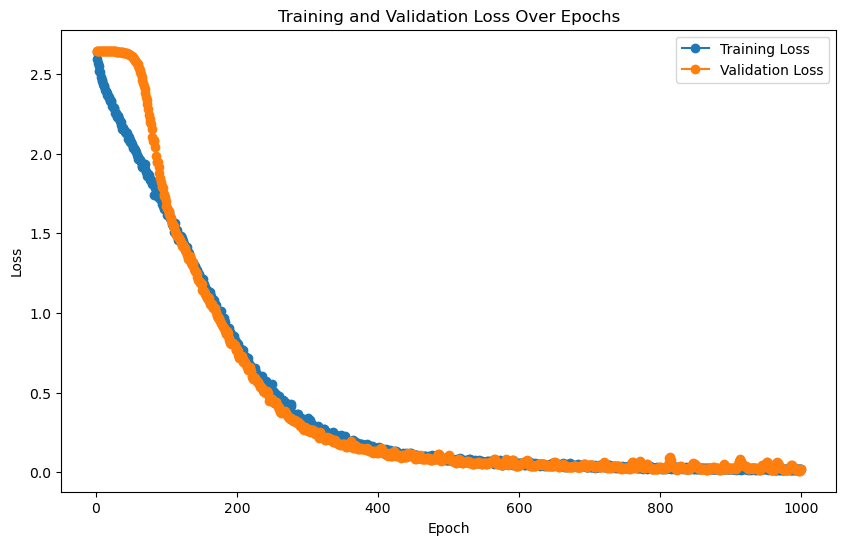

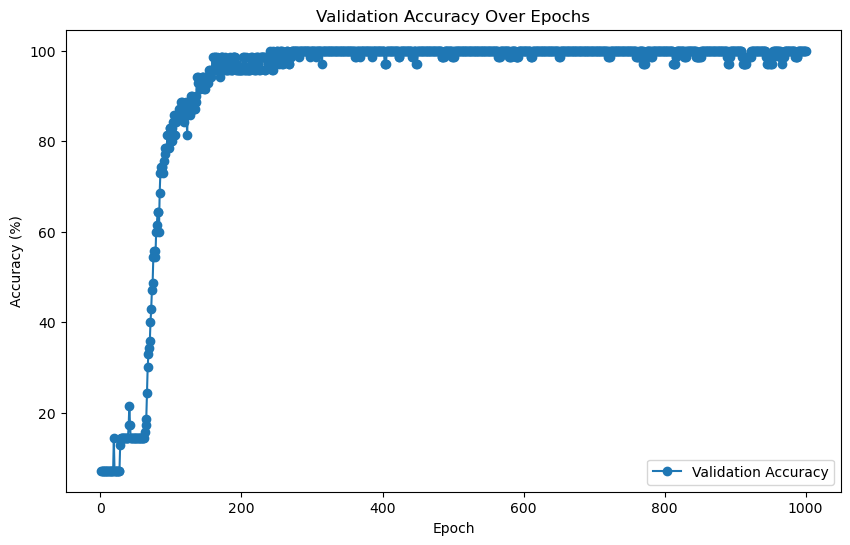


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0149

Final Test Loss: 0.0930, Test Accuracy: 97.27%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)

LOG: Training features shape: (280, 64), Training labels shape: (280,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2898, 64), Test labels shape: (2898,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 75.71%

Validation Classification Report:
               precision    recall  f1

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)
Train reps shape: (280, 64)
Train labels shape: (280,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2898, 64)
Test labels shape: (2898,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6927  |  Val Loss: 2.6492
Validation loss improved from inf to 2.6492.
[Epoch 2/1000] Train Loss: 2.6443  |  Val Loss: 2.6344
Validation loss improved from 2.6492 to 2.6344.
[Epoch 3/1000] Train Loss: 2.6258  |  Val Loss: 2.6193
Validation loss improved from 2.6344 to 2.6193.
[Epoch 4/1000] Train Loss: 2.6199  |  Val Loss: 2.6137
Validation loss improved from 2.6193 to 2.6137.
[Epoch 5/1000] Train Loss: 2.6099  |  Val Loss: 2.6023
Validation loss improved from 2.6137 to 2.6023.
[Epoch 6/1000] Train Loss: 2.5959  |  Val Loss: 2.5870
Validation loss improved from 2.6023 to 2.5870.
[Epoch 7/1000] Train Loss: 2.5819  |  Val Loss: 2.5714
Validation loss improved from 2.5870 to 2.5714.
[Epoch 8/1000] Train Loss: 2.5657  |  Val Loss: 2.5538
Validation loss improved from 2.5714 to 2.5538.
[Epoch 9/1000] Train Loss: 2.5483  |  Val Loss: 2.5348
Validation loss improved from 2.5538 to 2.5348.
[Epoch 10/1000] Train Loss: 2.5283  |  Val Loss: 2.5167
Validation loss impr

[Epoch 16/1000] Train Loss: 2.3661  |  Val Loss: 2.3362
Validation loss improved from 2.3715 to 2.3362.


[Epoch 17/1000] Train Loss: 2.3310  |  Val Loss: 2.2902
Validation loss improved from 2.3362 to 2.2902.
[Epoch 18/1000] Train Loss: 2.2871  |  Val Loss: 2.2489
Validation loss improved from 2.2902 to 2.2489.
[Epoch 19/1000] Train Loss: 2.2425  |  Val Loss: 2.2044
Validation loss improved from 2.2489 to 2.2044.
[Epoch 20/1000] Train Loss: 2.1990  |  Val Loss: 2.1653
Validation loss improved from 2.2044 to 2.1653.
[Epoch 21/1000] Train Loss: 2.1530  |  Val Loss: 2.1158
Validation loss improved from 2.1653 to 2.1158.
[Epoch 22/1000] Train Loss: 2.1100  |  Val Loss: 2.0697
Validation loss improved from 2.1158 to 2.0697.
[Epoch 23/1000] Train Loss: 2.0617  |  Val Loss: 2.0246
Validation loss improved from 2.0697 to 2.0246.
[Epoch 24/1000] Train Loss: 2.0194  |  Val Loss: 1.9775
Validation loss improved from 2.0246 to 1.9775.
[Epoch 25/1000] Train Loss: 1.9737  |  Val Loss: 1.9325
Validation loss improved from 1.9775 to 1.9325.
[Epoch 26/1000] Train Loss: 1.9319  |  Val Loss: 1.8890
Validati

[Epoch 36/1000] Train Loss: 1.5968  |  Val Loss: 1.5580
Validation loss improved from 1.5740 to 1.5580.
[Epoch 37/1000] Train Loss: 1.5710  |  Val Loss: 1.5511
Validation loss improved from 1.5580 to 1.5511.
[Epoch 38/1000] Train Loss: 1.5507  |  Val Loss: 1.5036
Validation loss improved from 1.5511 to 1.5036.
[Epoch 39/1000] Train Loss: 1.5343  |  Val Loss: 1.4836
Validation loss improved from 1.5036 to 1.4836.
[Epoch 40/1000] Train Loss: 1.5066  |  Val Loss: 1.4629
Validation loss improved from 1.4836 to 1.4629.
[Epoch 41/1000] Train Loss: 1.4885  |  Val Loss: 1.4821
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 1.4882  |  Val Loss: 1.4377
Validation loss improved from 1.4629 to 1.4377.
[Epoch 43/1000] Train Loss: 1.4535  |  Val Loss: 1.4225
Validation loss improved from 1.4377 to 1.4225.
[Epoch 44/1000] Train Loss: 1.4441  |  Val Loss: 1.4246
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 1.4388  |  Val Loss: 1.3

[Epoch 54/1000] Train Loss: 1.3414  |  Val Loss: 1.3470
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 1.3430  |  Val Loss: 1.3073
Validation loss improved from 1.3161 to 1.3073.
[Epoch 56/1000] Train Loss: 1.3406  |  Val Loss: 1.3090
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 1.3537  |  Val Loss: 1.4133
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 1.3572  |  Val Loss: 1.2734
Validation loss improved from 1.3073 to 1.2734.
[Epoch 59/1000] Train Loss: 1.3511  |  Val Loss: 1.2859
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 1.3084  |  Val Loss: 1.3111
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 1.3154  |  Val Loss: 1.2704
Validation loss improved from 1.2734 to 1.2704.
[Epoch 62/1000] Train Loss: 1.3149  |  Val Loss: 1.2727
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 

[Epoch 73/1000] Train Loss: 1.2632  |  Val Loss: 1.2253
Validation loss improved from 1.2301 to 1.2253.
[Epoch 74/1000] Train Loss: 1.2594  |  Val Loss: 1.2625
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 75/1000] Train Loss: 1.2520  |  Val Loss: 1.2270
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 76/1000] Train Loss: 1.2373  |  Val Loss: 1.2618
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 77/1000] Train Loss: 1.2485  |  Val Loss: 1.2255
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 78/1000] Train Loss: 1.2453  |  Val Loss: 1.2242
Validation loss improved from 1.2253 to 1.2242.
[Epoch 79/1000] Train Loss: 1.2307  |  Val Loss: 1.2189
Validation loss improved from 1.2242 to 1.2189.
[Epoch 80/1000] Train Loss: 1.2303  |  Val Loss: 1.2133
Validation loss improved from 1.2189 to 1.2133.
[Epoch 81/1000] Train Loss: 1.2294  |  Val Loss: 1.2190
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 1.2505

[Epoch 91/1000] Train Loss: 1.2071  |  Val Loss: 1.2012
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 1.2034  |  Val Loss: 1.2008
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 93/1000] Train Loss: 1.2057  |  Val Loss: 1.1926
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 94/1000] Train Loss: 1.2164  |  Val Loss: 1.1986
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 95/1000] Train Loss: 1.2124  |  Val Loss: 1.2067
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 96/1000] Train Loss: 1.1982  |  Val Loss: 1.1981
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 97/1000] Train Loss: 1.1970  |  Val Loss: 1.1916
Validation loss improved from 1.1922 to 1.1916.
[Epoch 98/1000] Train Loss: 1.1920  |  Val Loss: 1.1950
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 1.1915  |  Val Loss: 1.1747
Validation loss improved from 1.1916 to 1.1747.
[Epoch 100/1000] Train

[Epoch 110/1000] Train Loss: 1.1971  |  Val Loss: 1.3040
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 111/1000] Train Loss: 1.2376  |  Val Loss: 1.1783
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 112/1000] Train Loss: 1.2067  |  Val Loss: 1.1804
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 113/1000] Train Loss: 1.1856  |  Val Loss: 1.1930
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 114/1000] Train Loss: 1.1756  |  Val Loss: 1.1770
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 115/1000] Train Loss: 1.1723  |  Val Loss: 1.1844
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 116/1000] Train Loss: 1.1770  |  Val Loss: 1.1742
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 117/1000] Train Loss: 1.1666  |  Val Loss: 1.1679
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 118/1000] Train Loss: 1.1652  |  Val Loss: 1.1632
Validation loss improved from 1.1665 to 1.1632.
[Epoc

[Epoch 129/1000] Train Loss: 1.1537  |  Val Loss: 1.1645
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 130/1000] Train Loss: 1.1584  |  Val Loss: 1.1577
Validation loss improved from 1.1594 to 1.1577.
[Epoch 131/1000] Train Loss: 1.1793  |  Val Loss: 1.1773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 1.1609  |  Val Loss: 1.1620
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 133/1000] Train Loss: 1.1621  |  Val Loss: 1.1997
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 134/1000] Train Loss: 1.1836  |  Val Loss: 1.1906
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 135/1000] Train Loss: 1.1546  |  Val Loss: 1.1453
Validation loss improved from 1.1577 to 1.1453.
[Epoch 136/1000] Train Loss: 1.1585  |  Val Loss: 1.1563
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 137/1000] Train Loss: 1.1608  |  Val Loss: 1.1543
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 138/10

[Epoch 149/1000] Train Loss: 1.1523  |  Val Loss: 1.1402
Validation loss improved from 1.1410 to 1.1402.
[Epoch 150/1000] Train Loss: 1.1549  |  Val Loss: 1.1877
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 151/1000] Train Loss: 1.1539  |  Val Loss: 1.1592
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 152/1000] Train Loss: 1.1509  |  Val Loss: 1.1570
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 153/1000] Train Loss: 1.1411  |  Val Loss: 1.1507
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 154/1000] Train Loss: 1.1521  |  Val Loss: 1.1332
Validation loss improved from 1.1402 to 1.1332.
[Epoch 155/1000] Train Loss: 1.1381  |  Val Loss: 1.1464
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 1.1356  |  Val Loss: 1.1447
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 1.1389  |  Val Loss: 1.1833
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/10

[Epoch 169/1000] Train Loss: 1.1299  |  Val Loss: 1.1346
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 170/1000] Train Loss: 1.1489  |  Val Loss: 1.1456
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 171/1000] Train Loss: 1.1460  |  Val Loss: 1.1839
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 172/1000] Train Loss: 1.1315  |  Val Loss: 1.1232
Validation loss improved from 1.1328 to 1.1232.
[Epoch 173/1000] Train Loss: 1.1403  |  Val Loss: 1.1260
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 174/1000] Train Loss: 1.1566  |  Val Loss: 1.2016
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 175/1000] Train Loss: 1.1560  |  Val Loss: 1.1347
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 176/1000] Train Loss: 1.1317  |  Val Loss: 1.1463
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 177/1000] Train Loss: 1.1141  |  Val Loss: 1.1540
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 189/1000] Train Loss: 1.1183  |  Val Loss: 1.1185
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 190/1000] Train Loss: 1.1114  |  Val Loss: 1.1386
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 191/1000] Train Loss: 1.1147  |  Val Loss: 1.1353
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 192/1000] Train Loss: 1.1433  |  Val Loss: 1.2277
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 193/1000] Train Loss: 1.1492  |  Val Loss: 1.1204
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 194/1000] Train Loss: 1.1093  |  Val Loss: 1.1271
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 195/1000] Train Loss: 1.1265  |  Val Loss: 1.1285
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 196/1000] Train Loss: 1.1098  |  Val Loss: 1.1328
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 197/1000] Train Loss: 1.1196  |  Val Loss: 1.1141
Validation loss improved from 1.1148 to 1.1141.
[E

[Epoch 208/1000] Train Loss: 1.1403  |  Val Loss: 1.1273
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 209/1000] Train Loss: 1.1230  |  Val Loss: 1.1876
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 210/1000] Train Loss: 1.1100  |  Val Loss: 1.1209
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 211/1000] Train Loss: 1.1419  |  Val Loss: 1.1250
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 212/1000] Train Loss: 1.1096  |  Val Loss: 1.1428
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 213/1000] Train Loss: 1.1042  |  Val Loss: 1.1341
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 214/1000] Train Loss: 1.1127  |  Val Loss: 1.1977
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 215/1000] Train Loss: 1.1192  |  Val Loss: 1.1081
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 216/1000] Train Loss: 1.1073  |  Val Loss: 1.1205
!! Validation loss did NOT improve !! Patience: 1

[Epoch 227/1000] Train Loss: 1.1041  |  Val Loss: 1.1762
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 228/1000] Train Loss: 1.1125  |  Val Loss: 1.1183
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 229/1000] Train Loss: 1.0914  |  Val Loss: 1.1407
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 230/1000] Train Loss: 1.0939  |  Val Loss: 1.1123
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 231/1000] Train Loss: 1.1065  |  Val Loss: 1.1853
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 232/1000] Train Loss: 1.1291  |  Val Loss: 1.1360
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 233/1000] Train Loss: 1.0897  |  Val Loss: 1.1339
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 234/1000] Train Loss: 1.0998  |  Val Loss: 1.1080
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 235/1000] Train Loss: 1.0986  |  Val Loss: 1.1239
!! Validation loss did NOT improve !! Patience:

[Epoch 246/1000] Train Loss: 1.0966  |  Val Loss: 1.1752
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 247/1000] Train Loss: 1.1043  |  Val Loss: 1.1095
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 248/1000] Train Loss: 1.1113  |  Val Loss: 1.1292
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 249/1000] Train Loss: 1.1019  |  Val Loss: 1.1510
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 250/1000] Train Loss: 1.1085  |  Val Loss: 1.1230
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 251/1000] Train Loss: 1.1698  |  Val Loss: 1.1471
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 252/1000] Train Loss: 1.0831  |  Val Loss: 1.1032
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 253/1000] Train Loss: 1.1037  |  Val Loss: 1.1123
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 254/1000] Train Loss: 1.1019  |  Val Loss: 1.1458
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 265/1000] Train Loss: 1.0760  |  Val Loss: 1.1604
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 266/1000] Train Loss: 1.0894  |  Val Loss: 1.1043
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 267/1000] Train Loss: 1.0776  |  Val Loss: 1.1544
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 268/1000] Train Loss: 1.1000  |  Val Loss: 1.1353
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 269/1000] Train Loss: 1.0917  |  Val Loss: 1.1004
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 270/1000] Train Loss: 1.0784  |  Val Loss: 1.1098
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 271/1000] Train Loss: 1.0755  |  Val Loss: 1.1321
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 272/1000] Train Loss: 1.0707  |  Val Loss: 1.0940
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 273/1000] Train Loss: 1.0889  |  Val Loss: 1.1429
!! Validation loss did NOT improve !! Patience: 

[Epoch 283/1000] Train Loss: 1.0831  |  Val Loss: 1.0987
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 284/1000] Train Loss: 1.0770  |  Val Loss: 1.0895
Validation loss improved from 1.0914 to 1.0895.
[Epoch 285/1000] Train Loss: 1.0950  |  Val Loss: 1.1541
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 1.0767  |  Val Loss: 1.0986
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 287/1000] Train Loss: 1.0845  |  Val Loss: 1.0880
Validation loss improved from 1.0895 to 1.0880.
[Epoch 288/1000] Train Loss: 1.0718  |  Val Loss: 1.1691
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 289/1000] Train Loss: 1.1096  |  Val Loss: 1.1194
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 290/1000] Train Loss: 1.0893  |  Val Loss: 1.0923
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 291/1000] Train Loss: 1.0920  |  Val Loss: 1.2152
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 292/1

[Epoch 302/1000] Train Loss: 1.1154  |  Val Loss: 1.2049
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 303/1000] Train Loss: 1.0861  |  Val Loss: 1.0985
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 304/1000] Train Loss: 1.0972  |  Val Loss: 1.0993
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 305/1000] Train Loss: 1.0862  |  Val Loss: 1.1190
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 306/1000] Train Loss: 1.0597  |  Val Loss: 1.1335
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 307/1000] Train Loss: 1.0822  |  Val Loss: 1.0996
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 308/1000] Train Loss: 1.1005  |  Val Loss: 1.1148
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 309/1000] Train Loss: 1.0862  |  Val Loss: 1.1358
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 310/1000] Train Loss: 1.0779  |  Val Loss: 1.0988
!! Validation loss did NOT improve !! Patience:

[Epoch 321/1000] Train Loss: 1.0846  |  Val Loss: 1.0877
Validation loss improved from 1.0880 to 1.0877.
[Epoch 322/1000] Train Loss: 1.0693  |  Val Loss: 1.2777
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 323/1000] Train Loss: 1.1302  |  Val Loss: 1.1485
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 324/1000] Train Loss: 1.1286  |  Val Loss: 1.2681
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 325/1000] Train Loss: 1.0995  |  Val Loss: 1.0890
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 326/1000] Train Loss: 1.0616  |  Val Loss: 1.1908
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 327/1000] Train Loss: 1.0748  |  Val Loss: 1.0980
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 328/1000] Train Loss: 1.0772  |  Val Loss: 1.1056
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 329/1000] Train Loss: 1.0758  |  Val Loss: 1.1416
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 340/1000] Train Loss: 1.0574  |  Val Loss: 1.1020
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 341/1000] Train Loss: 1.0623  |  Val Loss: 1.1120
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 342/1000] Train Loss: 1.0675  |  Val Loss: 1.0937
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 343/1000] Train Loss: 1.0504  |  Val Loss: 1.1062
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 344/1000] Train Loss: 1.0501  |  Val Loss: 1.0892
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 345/1000] Train Loss: 1.0622  |  Val Loss: 1.0995
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 346/1000] Train Loss: 1.0591  |  Val Loss: 1.1494
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 347/1000] Train Loss: 1.0819  |  Val Loss: 1.1071
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 348/1000] Train Loss: 1.1150  |  Val Loss: 1.2510
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 360/1000] Train Loss: 1.0608  |  Val Loss: 1.0798
Validation loss improved from 1.0864 to 1.0798.
[Epoch 361/1000] Train Loss: 1.0595  |  Val Loss: 1.1492
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 362/1000] Train Loss: 1.0811  |  Val Loss: 1.0830
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 363/1000] Train Loss: 1.0930  |  Val Loss: 1.1943
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 364/1000] Train Loss: 1.0814  |  Val Loss: 1.1067
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 365/1000] Train Loss: 1.0614  |  Val Loss: 1.0828
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 366/1000] Train Loss: 1.0673  |  Val Loss: 1.1985
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 367/1000] Train Loss: 1.1028  |  Val Loss: 1.0793
Validation loss improved from 1.0798 to 1.0793.
[Epoch 368/1000] Train Loss: 1.0834  |  Val Loss: 1.2834
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 369/10

[Epoch 379/1000] Train Loss: 1.0505  |  Val Loss: 1.0875
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 380/1000] Train Loss: 1.0706  |  Val Loss: 1.1049
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 381/1000] Train Loss: 1.0601  |  Val Loss: 1.1057
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 382/1000] Train Loss: 1.0813  |  Val Loss: 1.0788
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 383/1000] Train Loss: 1.0719  |  Val Loss: 1.1548
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 384/1000] Train Loss: 1.0810  |  Val Loss: 1.1196
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 385/1000] Train Loss: 1.0936  |  Val Loss: 1.0959
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 386/1000] Train Loss: 1.1606  |  Val Loss: 1.2935
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 387/1000] Train Loss: 1.1161  |  Val Loss: 1.1257
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 398/1000] Train Loss: 1.0554  |  Val Loss: 1.0831
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 399/1000] Train Loss: 1.0682  |  Val Loss: 1.1263
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 400/1000] Train Loss: 1.0604  |  Val Loss: 1.0854
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 401/1000] Train Loss: 1.0429  |  Val Loss: 1.0935
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 402/1000] Train Loss: 1.0382  |  Val Loss: 1.0867
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 403/1000] Train Loss: 1.0576  |  Val Loss: 1.1237
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 404/1000] Train Loss: 1.0472  |  Val Loss: 1.0863
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 405/1000] Train Loss: 1.0596  |  Val Loss: 1.1477
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 406/1000] Train Loss: 1.0530  |  Val Loss: 1.0863
!! Validation loss did NOT improve !! Patience:

[Epoch 418/1000] Train Loss: 1.0419  |  Val Loss: 1.0917
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 419/1000] Train Loss: 1.0362  |  Val Loss: 1.0912
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 420/1000] Train Loss: 1.0361  |  Val Loss: 1.0669
Validation loss improved from 1.0752 to 1.0669.
[Epoch 421/1000] Train Loss: 1.0503  |  Val Loss: 1.0935
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 422/1000] Train Loss: 1.0347  |  Val Loss: 1.0790
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 423/1000] Train Loss: 1.0399  |  Val Loss: 1.1032
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 424/1000] Train Loss: 1.0400  |  Val Loss: 1.0799
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 425/1000] Train Loss: 1.0370  |  Val Loss: 1.1191
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 426/1000] Train Loss: 1.0422  |  Val Loss: 1.1073
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 438/1000] Train Loss: 1.0438  |  Val Loss: 1.0712
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 439/1000] Train Loss: 1.0806  |  Val Loss: 1.1149
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 440/1000] Train Loss: 1.0834  |  Val Loss: 1.1342
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 441/1000] Train Loss: 1.0745  |  Val Loss: 1.0597
Validation loss improved from 1.0669 to 1.0597.
[Epoch 442/1000] Train Loss: 1.0524  |  Val Loss: 1.2127
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 443/1000] Train Loss: 1.0736  |  Val Loss: 1.0838
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 444/1000] Train Loss: 1.0667  |  Val Loss: 1.1230
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 445/1000] Train Loss: 1.0353  |  Val Loss: 1.0757
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 446/1000] Train Loss: 1.0435  |  Val Loss: 1.0783
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 458/1000] Train Loss: 1.0549  |  Val Loss: 1.0678
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 459/1000] Train Loss: 1.0270  |  Val Loss: 1.0690
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 460/1000] Train Loss: 1.0339  |  Val Loss: 1.1071
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 461/1000] Train Loss: 1.0360  |  Val Loss: 1.0650
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 462/1000] Train Loss: 1.0268  |  Val Loss: 1.1038
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 463/1000] Train Loss: 1.0308  |  Val Loss: 1.0693
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 464/1000] Train Loss: 1.0261  |  Val Loss: 1.0828
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 465/1000] Train Loss: 1.0305  |  Val Loss: 1.1099
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 466/1000] Train Loss: 1.0351  |  Val Loss: 1.0747
!! Validation loss did NOT improve !! Patience:

[Epoch 477/1000] Train Loss: 1.0187  |  Val Loss: 1.0954
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 478/1000] Train Loss: 1.0226  |  Val Loss: 1.0726
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 479/1000] Train Loss: 1.0454  |  Val Loss: 1.1212
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 480/1000] Train Loss: 1.0353  |  Val Loss: 1.0761
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 481/1000] Train Loss: 1.0124  |  Val Loss: 1.1179
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 482/1000] Train Loss: 1.0359  |  Val Loss: 1.0665
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 483/1000] Train Loss: 1.0383  |  Val Loss: 1.0504
Validation loss improved from 1.0525 to 1.0504.
[Epoch 484/1000] Train Loss: 1.0437  |  Val Loss: 1.2138
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 485/1000] Train Loss: 1.0736  |  Val Loss: 1.0726
!! Validation loss did NOT improve !! Patience: 2/100
[Ep

[Epoch 497/1000] Train Loss: 1.0278  |  Val Loss: 1.0838
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 498/1000] Train Loss: 1.0352  |  Val Loss: 1.1440
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 499/1000] Train Loss: 1.0272  |  Val Loss: 1.0686
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 500/1000] Train Loss: 1.0384  |  Val Loss: 1.0898
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 501/1000] Train Loss: 1.0201  |  Val Loss: 1.0750
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 502/1000] Train Loss: 1.0195  |  Val Loss: 1.0673
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 503/1000] Train Loss: 1.0294  |  Val Loss: 1.1754
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 504/1000] Train Loss: 1.0656  |  Val Loss: 1.0914
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 505/1000] Train Loss: 1.0590  |  Val Loss: 1.1476
!! Validation loss did NOT improve !! Patience:

[Epoch 516/1000] Train Loss: 1.0146  |  Val Loss: 1.0903
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 517/1000] Train Loss: 1.0233  |  Val Loss: 1.1015
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 518/1000] Train Loss: 1.0194  |  Val Loss: 1.0745
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 519/1000] Train Loss: 1.0353  |  Val Loss: 1.0595
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 520/1000] Train Loss: 1.0115  |  Val Loss: 1.0916
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 521/1000] Train Loss: 1.0269  |  Val Loss: 1.0800
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 522/1000] Train Loss: 1.0816  |  Val Loss: 1.1423
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 523/1000] Train Loss: 1.0334  |  Val Loss: 1.0799
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 524/1000] Train Loss: 1.0346  |  Val Loss: 1.0891
!! Validation loss did NOT improve !! Patience:

[Epoch 535/1000] Train Loss: 1.0084  |  Val Loss: 1.0608
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 536/1000] Train Loss: 1.0174  |  Val Loss: 1.1827
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 537/1000] Train Loss: 1.0380  |  Val Loss: 1.0725
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 538/1000] Train Loss: 1.0229  |  Val Loss: 1.1296
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 539/1000] Train Loss: 1.0377  |  Val Loss: 1.0864
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 540/1000] Train Loss: 1.0472  |  Val Loss: 1.0764
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 541/1000] Train Loss: 1.0345  |  Val Loss: 1.1131
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 542/1000] Train Loss: 1.0141  |  Val Loss: 1.0625
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 543/1000] Train Loss: 1.0034  |  Val Loss: 1.1016
!! Validation loss did NOT improve !! Patience:

[Epoch 555/1000] Train Loss: 1.0489  |  Val Loss: 1.1012
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 556/1000] Train Loss: 1.0323  |  Val Loss: 1.0972
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 557/1000] Train Loss: 1.0076  |  Val Loss: 1.0998
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 558/1000] Train Loss: 1.0113  |  Val Loss: 1.0406
Validation loss improved from 1.0504 to 1.0406.
[Epoch 559/1000] Train Loss: 1.0065  |  Val Loss: 1.1339
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 560/1000] Train Loss: 1.0261  |  Val Loss: 1.0556
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 561/1000] Train Loss: 1.0092  |  Val Loss: 1.0552
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 562/1000] Train Loss: 1.0129  |  Val Loss: 1.1340
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 563/1000] Train Loss: 1.0230  |  Val Loss: 1.0725
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 572/1000] Train Loss: 1.0037  |  Val Loss: 1.0552
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 573/1000] Train Loss: 1.0073  |  Val Loss: 1.0670
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 574/1000] Train Loss: 1.0038  |  Val Loss: 1.1106
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 575/1000] Train Loss: 1.0119  |  Val Loss: 1.0589
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 576/1000] Train Loss: 1.0190  |  Val Loss: 1.0504
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 577/1000] Train Loss: 1.0273  |  Val Loss: 1.0817
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 578/1000] Train Loss: 1.0135  |  Val Loss: 1.0706
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 579/1000] Train Loss: 0.9996  |  Val Loss: 1.0595
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 580/1000] Train Loss: 0.9986  |  Val Loss: 1.1248
!! Validation loss did NOT improve !! Patience:

[Epoch 592/1000] Train Loss: 1.0275  |  Val Loss: 1.0922
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 593/1000] Train Loss: 1.0020  |  Val Loss: 1.0681
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 594/1000] Train Loss: 1.0035  |  Val Loss: 1.0611
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 595/1000] Train Loss: 0.9952  |  Val Loss: 1.0414
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 596/1000] Train Loss: 1.0045  |  Val Loss: 1.1052
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 597/1000] Train Loss: 0.9956  |  Val Loss: 1.0525
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 598/1000] Train Loss: 1.0061  |  Val Loss: 1.0743
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 599/1000] Train Loss: 0.9920  |  Val Loss: 1.0546
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 600/1000] Train Loss: 0.9892  |  Val Loss: 1.1283
!! Validation loss did NOT improve !! Patience:

[Epoch 610/1000] Train Loss: 1.0961  |  Val Loss: 1.1325
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 611/1000] Train Loss: 1.0264  |  Val Loss: 1.0839
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 612/1000] Train Loss: 1.0352  |  Val Loss: 1.0431
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 613/1000] Train Loss: 1.0125  |  Val Loss: 1.1988
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 614/1000] Train Loss: 1.0810  |  Val Loss: 1.0839
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 615/1000] Train Loss: 1.0697  |  Val Loss: 1.1852
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 616/1000] Train Loss: 1.0239  |  Val Loss: 1.0496
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 617/1000] Train Loss: 1.0283  |  Val Loss: 1.0532
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 618/1000] Train Loss: 0.9900  |  Val Loss: 1.0497
!! Validation loss did NOT improve !! Patience:

[Epoch 628/1000] Train Loss: 0.9840  |  Val Loss: 1.0606
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 629/1000] Train Loss: 0.9955  |  Val Loss: 1.0421
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 630/1000] Train Loss: 1.0035  |  Val Loss: 1.0369
Validation loss improved from 1.0406 to 1.0369.
[Epoch 631/1000] Train Loss: 1.0283  |  Val Loss: 1.1688
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 632/1000] Train Loss: 1.0230  |  Val Loss: 1.0538
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 633/1000] Train Loss: 1.0051  |  Val Loss: 1.1218
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 634/1000] Train Loss: 1.0473  |  Val Loss: 1.0622
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 635/1000] Train Loss: 0.9834  |  Val Loss: 1.0904
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 636/1000] Train Loss: 0.9879  |  Val Loss: 1.0448
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 646/1000] Train Loss: 1.0262  |  Val Loss: 1.0536
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 647/1000] Train Loss: 1.0008  |  Val Loss: 1.0367
Validation loss improved from 1.0369 to 1.0367.
[Epoch 648/1000] Train Loss: 1.0087  |  Val Loss: 1.0981
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 649/1000] Train Loss: 1.0045  |  Val Loss: 1.0425
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 650/1000] Train Loss: 0.9981  |  Val Loss: 1.1283
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 651/1000] Train Loss: 0.9954  |  Val Loss: 1.0624
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 652/1000] Train Loss: 1.0091  |  Val Loss: 1.1159
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 653/1000] Train Loss: 0.9807  |  Val Loss: 1.0410
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 654/1000] Train Loss: 0.9794  |  Val Loss: 1.0578
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 665/1000] Train Loss: 1.0021  |  Val Loss: 1.0663
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 666/1000] Train Loss: 0.9876  |  Val Loss: 1.0699
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 667/1000] Train Loss: 0.9823  |  Val Loss: 1.0850
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 668/1000] Train Loss: 1.0020  |  Val Loss: 1.0467
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 669/1000] Train Loss: 1.0060  |  Val Loss: 1.1539
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 670/1000] Train Loss: 1.0163  |  Val Loss: 1.0438
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 671/1000] Train Loss: 0.9774  |  Val Loss: 1.0950
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 672/1000] Train Loss: 0.9874  |  Val Loss: 1.0309
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 673/1000] Train Loss: 0.9824  |  Val Loss: 1.1112
!! Validation loss did NOT improve !! Patience:

[Epoch 684/1000] Train Loss: 0.9704  |  Val Loss: 1.0403
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 685/1000] Train Loss: 0.9760  |  Val Loss: 1.0720
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 686/1000] Train Loss: 0.9865  |  Val Loss: 1.0363
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 687/1000] Train Loss: 0.9717  |  Val Loss: 1.0539
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 688/1000] Train Loss: 0.9765  |  Val Loss: 1.0713
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 689/1000] Train Loss: 0.9838  |  Val Loss: 1.0334
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 690/1000] Train Loss: 0.9626  |  Val Loss: 1.0403
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 691/1000] Train Loss: 0.9801  |  Val Loss: 1.0814
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 692/1000] Train Loss: 0.9975  |  Val Loss: 1.0216
Validation loss improved from 1.0281 to 1.0216.

[Epoch 704/1000] Train Loss: 1.0316  |  Val Loss: 1.0368
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 705/1000] Train Loss: 1.0176  |  Val Loss: 1.0254
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 706/1000] Train Loss: 1.0026  |  Val Loss: 1.1068
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 707/1000] Train Loss: 0.9710  |  Val Loss: 1.0543
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 708/1000] Train Loss: 0.9805  |  Val Loss: 1.0611
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 709/1000] Train Loss: 0.9885  |  Val Loss: 1.1121
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 710/1000] Train Loss: 0.9961  |  Val Loss: 1.0280
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 711/1000] Train Loss: 0.9688  |  Val Loss: 1.0399
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 712/1000] Train Loss: 0.9675  |  Val Loss: 1.0611
!! Validation loss did NOT improve !! Patience:

[Epoch 725/1000] Train Loss: 0.9833  |  Val Loss: 1.0458
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 726/1000] Train Loss: 0.9744  |  Val Loss: 1.0831
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 727/1000] Train Loss: 0.9930  |  Val Loss: 1.0140
Validation loss improved from 1.0170 to 1.0140.
[Epoch 728/1000] Train Loss: 0.9853  |  Val Loss: 1.1044
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 729/1000] Train Loss: 0.9717  |  Val Loss: 1.0237
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 730/1000] Train Loss: 0.9663  |  Val Loss: 1.0999
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 731/1000] Train Loss: 0.9599  |  Val Loss: 1.0387
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 732/1000] Train Loss: 0.9655  |  Val Loss: 1.0377
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 733/1000] Train Loss: 0.9657  |  Val Loss: 1.0614
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 743/1000] Train Loss: 0.9660  |  Val Loss: 1.0477
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 744/1000] Train Loss: 0.9623  |  Val Loss: 1.0339
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 745/1000] Train Loss: 0.9569  |  Val Loss: 1.0208
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 746/1000] Train Loss: 0.9578  |  Val Loss: 1.0154
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 747/1000] Train Loss: 0.9418  |  Val Loss: 1.0561
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 748/1000] Train Loss: 0.9449  |  Val Loss: 1.0265
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 749/1000] Train Loss: 0.9403  |  Val Loss: 1.0147
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 750/1000] Train Loss: 0.9448  |  Val Loss: 1.0487
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 751/1000] Train Loss: 0.9637  |  Val Loss: 1.0232
!! Validation loss did NOT improve !! Patience: 

[Epoch 762/1000] Train Loss: 0.9381  |  Val Loss: 1.0286
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 763/1000] Train Loss: 0.9302  |  Val Loss: 1.0094
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 764/1000] Train Loss: 0.9751  |  Val Loss: 1.0056
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 765/1000] Train Loss: 0.9683  |  Val Loss: 1.1648
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 766/1000] Train Loss: 1.0378  |  Val Loss: 1.0121
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 767/1000] Train Loss: 0.9763  |  Val Loss: 1.1207
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 768/1000] Train Loss: 0.9641  |  Val Loss: 1.0225
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 769/1000] Train Loss: 0.9573  |  Val Loss: 1.0610
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 770/1000] Train Loss: 0.9379  |  Val Loss: 1.0106
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 781/1000] Train Loss: 0.9190  |  Val Loss: 1.0357
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 782/1000] Train Loss: 0.9230  |  Val Loss: 0.9909
Validation loss improved from 0.9934 to 0.9909.
[Epoch 783/1000] Train Loss: 0.9382  |  Val Loss: 1.0355
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 784/1000] Train Loss: 0.9409  |  Val Loss: 1.0006
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 785/1000] Train Loss: 0.9441  |  Val Loss: 1.0332
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 786/1000] Train Loss: 0.9384  |  Val Loss: 1.0189
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 787/1000] Train Loss: 0.9396  |  Val Loss: 1.0206
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 788/1000] Train Loss: 0.9165  |  Val Loss: 1.0218
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 789/1000] Train Loss: 0.9247  |  Val Loss: 0.9974
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 801/1000] Train Loss: 0.9228  |  Val Loss: 1.0098
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 802/1000] Train Loss: 0.9278  |  Val Loss: 1.0396
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 803/1000] Train Loss: 0.9360  |  Val Loss: 0.9872
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 804/1000] Train Loss: 0.9216  |  Val Loss: 1.0648
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 805/1000] Train Loss: 0.9343  |  Val Loss: 0.9922
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 806/1000] Train Loss: 0.9374  |  Val Loss: 0.9847
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 807/1000] Train Loss: 0.9233  |  Val Loss: 0.9790
Validation loss improved from 0.9837 to 0.9790.
[Epoch 808/1000] Train Loss: 0.9300  |  Val Loss: 0.9963
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 809/1000] Train Loss: 0.9497  |  Val Loss: 1.0486
!! Validation loss did NOT improve !! Patience: 2/100
[Epoc

[Epoch 820/1000] Train Loss: 0.9034  |  Val Loss: 0.9735
Validation loss improved from 0.9751 to 0.9735.
[Epoch 821/1000] Train Loss: 0.9069  |  Val Loss: 0.9877
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 822/1000] Train Loss: 0.9017  |  Val Loss: 1.0128
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 823/1000] Train Loss: 0.8926  |  Val Loss: 0.9979
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 824/1000] Train Loss: 0.9151  |  Val Loss: 0.9942
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 825/1000] Train Loss: 0.9090  |  Val Loss: 1.0207
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 826/1000] Train Loss: 0.9137  |  Val Loss: 1.0018
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 827/1000] Train Loss: 0.9288  |  Val Loss: 1.0480
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 828/1000] Train Loss: 0.9157  |  Val Loss: 0.9856
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 838/1000] Train Loss: 0.9202  |  Val Loss: 0.9723
Validation loss improved from 0.9735 to 0.9723.
[Epoch 839/1000] Train Loss: 0.9057  |  Val Loss: 1.0589
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 840/1000] Train Loss: 0.8939  |  Val Loss: 0.9821
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 841/1000] Train Loss: 0.9526  |  Val Loss: 1.0477
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 842/1000] Train Loss: 0.9610  |  Val Loss: 1.0172
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 843/1000] Train Loss: 0.9384  |  Val Loss: 0.9724
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 844/1000] Train Loss: 0.9118  |  Val Loss: 0.9845
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 845/1000] Train Loss: 0.8910  |  Val Loss: 0.9636
Validation loss improved from 0.9723 to 0.9636.
[Epoch 846/1000] Train Loss: 0.9092  |  Val Loss: 0.9819
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 847/10

[Epoch 857/1000] Train Loss: 0.9227  |  Val Loss: 0.9826
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 858/1000] Train Loss: 0.8958  |  Val Loss: 1.0072
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 859/1000] Train Loss: 0.8999  |  Val Loss: 0.9788
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 860/1000] Train Loss: 0.8897  |  Val Loss: 1.0981
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 861/1000] Train Loss: 0.9070  |  Val Loss: 0.9678
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 862/1000] Train Loss: 0.9265  |  Val Loss: 1.0725
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 863/1000] Train Loss: 0.8950  |  Val Loss: 0.9839
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 864/1000] Train Loss: 0.8816  |  Val Loss: 0.9738
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 865/1000] Train Loss: 0.8925  |  Val Loss: 0.9805
!! Validation loss did NOT improve !! Patience:

[Epoch 876/1000] Train Loss: 0.8864  |  Val Loss: 1.0014
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 877/1000] Train Loss: 0.8651  |  Val Loss: 0.9799
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 878/1000] Train Loss: 0.8901  |  Val Loss: 1.0243
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 879/1000] Train Loss: 0.8596  |  Val Loss: 0.9402
Validation loss improved from 0.9433 to 0.9402.
[Epoch 880/1000] Train Loss: 0.8826  |  Val Loss: 1.0916
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 881/1000] Train Loss: 0.8893  |  Val Loss: 0.9786
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 882/1000] Train Loss: 0.9405  |  Val Loss: 0.9837
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 883/1000] Train Loss: 0.9554  |  Val Loss: 1.0520
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 884/1000] Train Loss: 0.9103  |  Val Loss: 0.9685
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 895/1000] Train Loss: 0.9115  |  Val Loss: 0.9639
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 896/1000] Train Loss: 0.8960  |  Val Loss: 1.1331
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 897/1000] Train Loss: 0.9233  |  Val Loss: 0.9495
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 898/1000] Train Loss: 0.8598  |  Val Loss: 0.9710
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 899/1000] Train Loss: 0.8495  |  Val Loss: 0.9431
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 900/1000] Train Loss: 0.8494  |  Val Loss: 0.9610
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 901/1000] Train Loss: 0.8461  |  Val Loss: 0.9614
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 902/1000] Train Loss: 0.8496  |  Val Loss: 0.9723
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 903/1000] Train Loss: 0.8574  |  Val Loss: 0.9344
Validation loss improved from 0.9402 to 0.9344.

[Epoch 914/1000] Train Loss: 0.8472  |  Val Loss: 0.9479
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 915/1000] Train Loss: 0.8646  |  Val Loss: 0.9672
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 916/1000] Train Loss: 0.8355  |  Val Loss: 0.9909
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 917/1000] Train Loss: 0.8668  |  Val Loss: 0.9929
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 918/1000] Train Loss: 0.8568  |  Val Loss: 0.9778
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 919/1000] Train Loss: 0.8684  |  Val Loss: 1.0329
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 920/1000] Train Loss: 0.8827  |  Val Loss: 0.9318
Validation loss improved from 0.9341 to 0.9318.
[Epoch 921/1000] Train Loss: 0.8644  |  Val Loss: 0.9643
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 922/1000] Train Loss: 0.8282  |  Val Loss: 0.9334
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 933/1000] Train Loss: 0.8452  |  Val Loss: 0.9918
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 934/1000] Train Loss: 0.8541  |  Val Loss: 0.9528
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 935/1000] Train Loss: 0.8572  |  Val Loss: 0.9512
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 936/1000] Train Loss: 0.8287  |  Val Loss: 0.8977
Validation loss improved from 0.9218 to 0.8977.
[Epoch 937/1000] Train Loss: 0.8438  |  Val Loss: 0.9553
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 938/1000] Train Loss: 0.8273  |  Val Loss: 0.9548
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 939/1000] Train Loss: 0.8298  |  Val Loss: 0.9638
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 940/1000] Train Loss: 0.8359  |  Val Loss: 0.9347
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 941/1000] Train Loss: 0.8333  |  Val Loss: 0.9638
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 952/1000] Train Loss: 0.8253  |  Val Loss: 0.9116
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 953/1000] Train Loss: 0.8497  |  Val Loss: 1.0477
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 954/1000] Train Loss: 0.8771  |  Val Loss: 0.9538
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 955/1000] Train Loss: 0.9071  |  Val Loss: 1.1504
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 956/1000] Train Loss: 0.9230  |  Val Loss: 0.9254
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 957/1000] Train Loss: 0.8693  |  Val Loss: 1.0261
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 958/1000] Train Loss: 0.8323  |  Val Loss: 0.9094
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 959/1000] Train Loss: 0.8315  |  Val Loss: 1.0112
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 960/1000] Train Loss: 0.8205  |  Val Loss: 0.9073
!! Validation loss did NOT improve !! Patience:

[Epoch 971/1000] Train Loss: 0.7970  |  Val Loss: 0.9207
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 972/1000] Train Loss: 0.8020  |  Val Loss: 0.8936
Validation loss improved from 0.8977 to 0.8936.
[Epoch 973/1000] Train Loss: 0.8034  |  Val Loss: 0.9630
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 974/1000] Train Loss: 0.8029  |  Val Loss: 0.9063
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 975/1000] Train Loss: 0.7916  |  Val Loss: 0.9486
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 976/1000] Train Loss: 0.8069  |  Val Loss: 0.9242
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 977/1000] Train Loss: 0.8098  |  Val Loss: 0.8905
Validation loss improved from 0.8936 to 0.8905.
[Epoch 978/1000] Train Loss: 0.8059  |  Val Loss: 0.9063
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 979/1000] Train Loss: 0.7949  |  Val Loss: 0.9352
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 980/1

[Epoch 989/1000] Train Loss: 0.7834  |  Val Loss: 0.8838
Validation loss improved from 0.8840 to 0.8838.
[Epoch 990/1000] Train Loss: 0.7968  |  Val Loss: 0.9591
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 991/1000] Train Loss: 0.8236  |  Val Loss: 0.9086
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 992/1000] Train Loss: 0.7834  |  Val Loss: 0.8862
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 993/1000] Train Loss: 0.8110  |  Val Loss: 1.0197
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 994/1000] Train Loss: 0.8293  |  Val Loss: 0.9014
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 995/1000] Train Loss: 0.8155  |  Val Loss: 0.9169
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 996/1000] Train Loss: 0.7974  |  Val Loss: 0.9469
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 997/1000] Train Loss: 0.7872  |  Val Loss: 0.8994
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

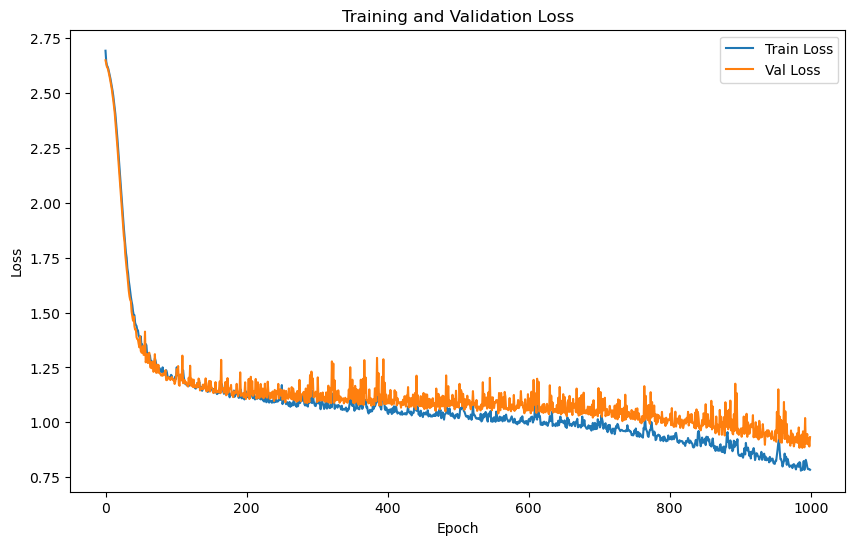

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.0989 | Test Accuracy: 58.35%


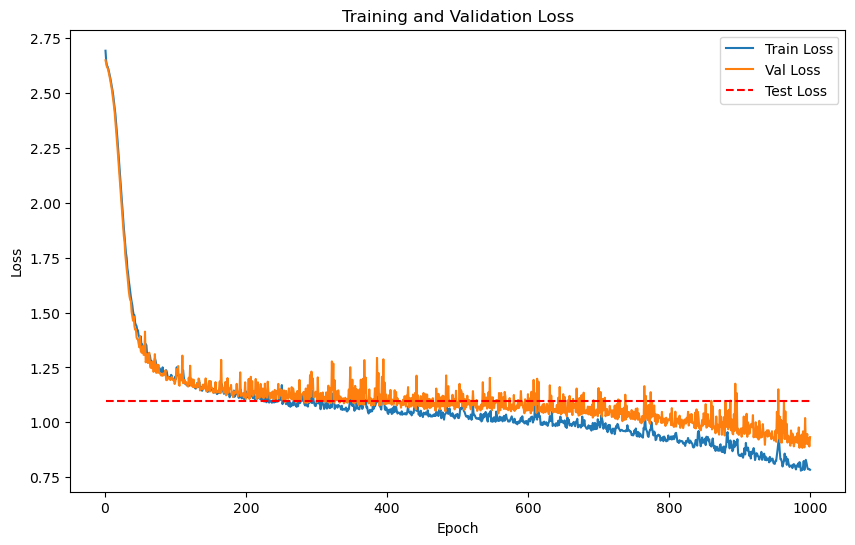

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.1233
Epoch [1/2000], Avg Train Loss: 8.1233
Epoch [1/2000], Avg Val Loss: 3.7190
Validation loss improved from inf to 3.7190. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.0691
Epoch [2/2000], Avg Train Loss: 8.0691
Epoch [2/2000], Avg Val Loss: 3.7041
Validation loss improved from 3.7190 to 3.7041. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.8983
Epoch [3/2000], Avg Train Loss: 7.8983
Epoch [3/2000], Avg Val Loss: 3.6901
Validation loss improved from 3.7041 to 3.6901. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.8578
Epoch [4/2000], Avg Train Loss: 7.8578
Epoch [4/2000], Avg Val Loss: 3.6767
Validation loss improved from 3.6901 to 3.6767. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.7569
Epoch [5/2000], Avg Train Loss: 7.7569
Epoch [5/2000], Avg Val Loss: 3.6641
Validation loss improved from 3.6767 to 3.6641. Saving mode

    Batch [1/1], Train Loss: 7.0959
Epoch [15/2000], Avg Train Loss: 7.0959
Epoch [15/2000], Avg Val Loss: 3.5688
Validation loss improved from 3.5760 to 3.5688. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.0736
Epoch [16/2000], Avg Train Loss: 7.0736
Epoch [16/2000], Avg Val Loss: 3.5620
Validation loss improved from 3.5688 to 3.5620. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.1102
Epoch [17/2000], Avg Train Loss: 7.1102
Epoch [17/2000], Avg Val Loss: 3.5557
Validation loss improved from 3.5620 to 3.5557. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.0519
Epoch [18/2000], Avg Train Loss: 7.0519
Epoch [18/2000], Avg Val Loss: 3.5498
Validation loss improved from 3.5557 to 3.5498. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.7937
Epoch [19/2000], Avg Train Loss: 6.7937
Epoch [19/2000], Avg Val Loss: 3.5444
Validation loss improved from 3.5498 to 3.

    Batch [1/1], Train Loss: 6.5561
Epoch [26/2000], Avg Train Loss: 6.5561
Epoch [26/2000], Avg Val Loss: 3.5145
Validation loss improved from 3.5180 to 3.5145. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.5886
Epoch [27/2000], Avg Train Loss: 6.5886
Epoch [27/2000], Avg Val Loss: 3.5112
Validation loss improved from 3.5145 to 3.5112. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.5276
Epoch [28/2000], Avg Train Loss: 6.5276
Epoch [28/2000], Avg Val Loss: 3.5080
Validation loss improved from 3.5112 to 3.5080. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.3932
Epoch [29/2000], Avg Train Loss: 6.3932
Epoch [29/2000], Avg Val Loss: 3.5050
Validation loss improved from 3.5080 to 3.5050. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.3726
Epoch [30/2000], Avg Train Loss: 6.3726
Epoch [30/2000], Avg Val Loss: 3.5022
Validation loss improved from 3.5050 to 3.

    Batch [1/1], Train Loss: 6.2489
Epoch [35/2000], Avg Train Loss: 6.2489
Epoch [35/2000], Avg Val Loss: 3.4900
Validation loss improved from 3.4922 to 3.4900. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.2071
Epoch [36/2000], Avg Train Loss: 6.2071
Epoch [36/2000], Avg Val Loss: 3.4879
Validation loss improved from 3.4900 to 3.4879. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.0889
Epoch [37/2000], Avg Train Loss: 6.0889
Epoch [37/2000], Avg Val Loss: 3.4859
Validation loss improved from 3.4879 to 3.4859. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.1701
Epoch [38/2000], Avg Train Loss: 6.1701
Epoch [38/2000], Avg Val Loss: 3.4841
Validation loss improved from 3.4859 to 3.4841. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.0628
Epoch [39/2000], Avg Train Loss: 6.0628
Epoch [39/2000], Avg Val Loss: 3.4823
Validation loss improved from 3.4841 to 3.

    Batch [1/1], Train Loss: 5.8092
Epoch [52/2000], Avg Train Loss: 5.8092
Epoch [52/2000], Avg Val Loss: 3.4635
Validation loss improved from 3.4648 to 3.4635. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.7108
Epoch [53/2000], Avg Train Loss: 5.7108
Epoch [53/2000], Avg Val Loss: 3.4623
Validation loss improved from 3.4635 to 3.4623. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.7114
Epoch [54/2000], Avg Train Loss: 5.7114
Epoch [54/2000], Avg Val Loss: 3.4611
Validation loss improved from 3.4623 to 3.4611. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.7791
Epoch [55/2000], Avg Train Loss: 5.7791
Epoch [55/2000], Avg Val Loss: 3.4598
Validation loss improved from 3.4611 to 3.4598. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.6201
Epoch [56/2000], Avg Train Loss: 5.6201
Epoch [56/2000], Avg Val Loss: 3.4585
Validation loss improved from 3.4598 to 3.

    Batch [1/1], Train Loss: 5.5878
Epoch [63/2000], Avg Train Loss: 5.5878
Epoch [63/2000], Avg Val Loss: 3.4497
Validation loss improved from 3.4509 to 3.4497. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.6317
Epoch [64/2000], Avg Train Loss: 5.6317
Epoch [64/2000], Avg Val Loss: 3.4484
Validation loss improved from 3.4497 to 3.4484. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.5404
Epoch [65/2000], Avg Train Loss: 5.5404
Epoch [65/2000], Avg Val Loss: 3.4472
Validation loss improved from 3.4484 to 3.4472. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.5018
Epoch [66/2000], Avg Train Loss: 5.5018
Epoch [66/2000], Avg Val Loss: 3.4459
Validation loss improved from 3.4472 to 3.4459. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.4276
Epoch [67/2000], Avg Train Loss: 5.4276
Epoch [67/2000], Avg Val Loss: 3.4445
Validation loss improved from 3.4459 to 3.

    Batch [1/1], Train Loss: 5.5043
Epoch [70/2000], Avg Train Loss: 5.5043
Epoch [70/2000], Avg Val Loss: 3.4403
Validation loss improved from 3.4417 to 3.4403. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.4585
Epoch [71/2000], Avg Train Loss: 5.4585
Epoch [71/2000], Avg Val Loss: 3.4388
Validation loss improved from 3.4403 to 3.4388. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.4807
Epoch [72/2000], Avg Train Loss: 5.4807
Epoch [72/2000], Avg Val Loss: 3.4374
Validation loss improved from 3.4388 to 3.4374. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.4284
Epoch [73/2000], Avg Train Loss: 5.4284
Epoch [73/2000], Avg Val Loss: 3.4359
Validation loss improved from 3.4374 to 3.4359. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.4256
Epoch [74/2000], Avg Train Loss: 5.4256
Epoch [74/2000], Avg Val Loss: 3.4345
Validation loss improved from 3.4359 to 3.

    Batch [1/1], Train Loss: 5.3011
Epoch [86/2000], Avg Train Loss: 5.3011
Epoch [86/2000], Avg Val Loss: 3.4159
Validation loss improved from 3.4174 to 3.4159. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.3204
Epoch [87/2000], Avg Train Loss: 5.3204
Epoch [87/2000], Avg Val Loss: 3.4143
Validation loss improved from 3.4159 to 3.4143. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.2997
Epoch [88/2000], Avg Train Loss: 5.2997
Epoch [88/2000], Avg Val Loss: 3.4127
Validation loss improved from 3.4143 to 3.4127. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.2509
Epoch [89/2000], Avg Train Loss: 5.2509
Epoch [89/2000], Avg Val Loss: 3.4110
Validation loss improved from 3.4127 to 3.4110. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.2969
Epoch [90/2000], Avg Train Loss: 5.2969
Epoch [90/2000], Avg Val Loss: 3.4094
Validation loss improved from 3.4110 to 3.

    Batch [1/1], Train Loss: 5.2056
Epoch [102/2000], Avg Train Loss: 5.2056
Epoch [102/2000], Avg Val Loss: 3.3902
Validation loss improved from 3.3918 to 3.3902. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 5.2017
Epoch [103/2000], Avg Train Loss: 5.2017
Epoch [103/2000], Avg Val Loss: 3.3886
Validation loss improved from 3.3902 to 3.3886. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 5.1814
Epoch [104/2000], Avg Train Loss: 5.1814
Epoch [104/2000], Avg Val Loss: 3.3869
Validation loss improved from 3.3886 to 3.3869. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 5.1660
Epoch [105/2000], Avg Train Loss: 5.1660
Epoch [105/2000], Avg Val Loss: 3.3852
Validation loss improved from 3.3869 to 3.3852. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.1885
Epoch [106/2000], Avg Train Loss: 5.1885
Epoch [106/2000], Avg Val Loss: 3.3835
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1046
Epoch [122/2000], Avg Train Loss: 5.1046
Epoch [122/2000], Avg Val Loss: 3.3559
Validation loss improved from 3.3576 to 3.3559. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 5.1407
Epoch [123/2000], Avg Train Loss: 5.1407
Epoch [123/2000], Avg Val Loss: 3.3541
Validation loss improved from 3.3559 to 3.3541. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 5.0705
Epoch [124/2000], Avg Train Loss: 5.0705
Epoch [124/2000], Avg Val Loss: 3.3523
Validation loss improved from 3.3541 to 3.3523. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.0939
Epoch [125/2000], Avg Train Loss: 5.0939
Epoch [125/2000], Avg Val Loss: 3.3506
Validation loss improved from 3.3523 to 3.3506. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 5.1253
Epoch [126/2000], Avg Train Loss: 5.1253
Epoch [126/2000], Avg Val Loss: 3.3489
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0371
Epoch [137/2000], Avg Train Loss: 5.0371
Epoch [137/2000], Avg Val Loss: 3.3301
Validation loss improved from 3.3319 to 3.3301. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 5.0849
Epoch [138/2000], Avg Train Loss: 5.0849
Epoch [138/2000], Avg Val Loss: 3.3283
Validation loss improved from 3.3301 to 3.3283. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 5.0755
Epoch [139/2000], Avg Train Loss: 5.0755
Epoch [139/2000], Avg Val Loss: 3.3265
Validation loss improved from 3.3283 to 3.3265. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.9754
Epoch [140/2000], Avg Train Loss: 4.9754
Epoch [140/2000], Avg Val Loss: 3.3246
Validation loss improved from 3.3265 to 3.3246. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.9768
Epoch [141/2000], Avg Train Loss: 4.9768
Epoch [141/2000], Avg Val Loss: 3.3228
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0068
Epoch [157/2000], Avg Train Loss: 5.0068
Epoch [157/2000], Avg Val Loss: 3.2940
Validation loss improved from 3.2958 to 3.2940. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.9477
Epoch [158/2000], Avg Train Loss: 4.9477
Epoch [158/2000], Avg Val Loss: 3.2923
Validation loss improved from 3.2940 to 3.2923. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.9504
Epoch [159/2000], Avg Train Loss: 4.9504
Epoch [159/2000], Avg Val Loss: 3.2905
Validation loss improved from 3.2923 to 3.2905. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 5.0032
Epoch [160/2000], Avg Train Loss: 5.0032
Epoch [160/2000], Avg Val Loss: 3.2888
Validation loss improved from 3.2905 to 3.2888. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.9975
Epoch [161/2000], Avg Train Loss: 4.9975
Epoch [161/2000], Avg Val Loss: 3.2870
Validation loss improved fro

Epoch [171/2000], Avg Val Loss: 3.2691
Validation loss improved from 3.2709 to 3.2691. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.9437
Epoch [172/2000], Avg Train Loss: 4.9437
Epoch [172/2000], Avg Val Loss: 3.2672
Validation loss improved from 3.2691 to 3.2672. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.9082
Epoch [173/2000], Avg Train Loss: 4.9082
Epoch [173/2000], Avg Val Loss: 3.2654
Validation loss improved from 3.2672 to 3.2654. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.9339
Epoch [174/2000], Avg Train Loss: 4.9339
Epoch [174/2000], Avg Val Loss: 3.2635
Validation loss improved from 3.2654 to 3.2635. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.9495
Epoch [175/2000], Avg Train Loss: 4.9495
Epoch [175/2000], Avg Val Loss: 3.2617
Validation loss improved from 3.2635 to 3.2617. Saving model...

LOG: Epoch [176/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9112
Epoch [193/2000], Avg Train Loss: 4.9112
Epoch [193/2000], Avg Val Loss: 3.2290
Validation loss improved from 3.2309 to 3.2290. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.9242
Epoch [194/2000], Avg Train Loss: 4.9242
Epoch [194/2000], Avg Val Loss: 3.2271
Validation loss improved from 3.2290 to 3.2271. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.8938
Epoch [195/2000], Avg Train Loss: 4.8938
Epoch [195/2000], Avg Val Loss: 3.2253
Validation loss improved from 3.2271 to 3.2253. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.8883
Epoch [196/2000], Avg Train Loss: 4.8883
Epoch [196/2000], Avg Val Loss: 3.2234
Validation loss improved from 3.2253 to 3.2234. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.8893
Epoch [197/2000], Avg Train Loss: 4.8893
Epoch [197/2000], Avg Val Loss: 3.2216
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8215
Epoch [209/2000], Avg Train Loss: 4.8215
Epoch [209/2000], Avg Val Loss: 3.1996
Validation loss improved from 3.2014 to 3.1996. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 4.8505
Epoch [210/2000], Avg Train Loss: 4.8505
Epoch [210/2000], Avg Val Loss: 3.1979
Validation loss improved from 3.1996 to 3.1979. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 4.8773
Epoch [211/2000], Avg Train Loss: 4.8773
Epoch [211/2000], Avg Val Loss: 3.1960
Validation loss improved from 3.1979 to 3.1960. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 4.8570
Epoch [212/2000], Avg Train Loss: 4.8570
Epoch [212/2000], Avg Val Loss: 3.1942
Validation loss improved from 3.1960 to 3.1942. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 4.8332
Epoch [213/2000], Avg Train Loss: 4.8332
Epoch [213/2000], Avg Val Loss: 3.1924
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7953
Epoch [234/2000], Avg Train Loss: 4.7953
Epoch [234/2000], Avg Val Loss: 3.1555
Validation loss improved from 3.1572 to 3.1555. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.7795
Epoch [235/2000], Avg Train Loss: 4.7795
Epoch [235/2000], Avg Val Loss: 3.1538
Validation loss improved from 3.1555 to 3.1538. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.8113
Epoch [236/2000], Avg Train Loss: 4.8113
Epoch [236/2000], Avg Val Loss: 3.1522
Validation loss improved from 3.1538 to 3.1522. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.7924
Epoch [237/2000], Avg Train Loss: 4.7924
Epoch [237/2000], Avg Val Loss: 3.1505
Validation loss improved from 3.1522 to 3.1505. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.7859
Epoch [238/2000], Avg Train Loss: 4.7859
Epoch [238/2000], Avg Val Loss: 3.1489
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7733
Epoch [247/2000], Avg Train Loss: 4.7733
Epoch [247/2000], Avg Val Loss: 3.1342
Validation loss improved from 3.1358 to 3.1342. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 4.7209
Epoch [248/2000], Avg Train Loss: 4.7209
Epoch [248/2000], Avg Val Loss: 3.1325
Validation loss improved from 3.1342 to 3.1325. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 4.7821
Epoch [249/2000], Avg Train Loss: 4.7821
Epoch [249/2000], Avg Val Loss: 3.1309
Validation loss improved from 3.1325 to 3.1309. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 4.7618
Epoch [250/2000], Avg Train Loss: 4.7618
Epoch [250/2000], Avg Val Loss: 3.1293
Validation loss improved from 3.1309 to 3.1293. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 4.7619
Epoch [251/2000], Avg Train Loss: 4.7619
Epoch [251/2000], Avg Val Loss: 3.1277
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7282
Epoch [265/2000], Avg Train Loss: 4.7282
Epoch [265/2000], Avg Val Loss: 3.1053
Validation loss improved from 3.1069 to 3.1053. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.6979
Epoch [266/2000], Avg Train Loss: 4.6979
Epoch [266/2000], Avg Val Loss: 3.1038
Validation loss improved from 3.1053 to 3.1038. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.7141
Epoch [267/2000], Avg Train Loss: 4.7141
Epoch [267/2000], Avg Val Loss: 3.1023
Validation loss improved from 3.1038 to 3.1023. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.7343
Epoch [268/2000], Avg Train Loss: 4.7343
Epoch [268/2000], Avg Val Loss: 3.1008
Validation loss improved from 3.1023 to 3.1008. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.7287
Epoch [269/2000], Avg Train Loss: 4.7287
Epoch [269/2000], Avg Val Loss: 3.0993
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6912
Epoch [284/2000], Avg Train Loss: 4.6912
Epoch [284/2000], Avg Val Loss: 3.0776
Validation loss improved from 3.0790 to 3.0776. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.6824
Epoch [285/2000], Avg Train Loss: 4.6824
Epoch [285/2000], Avg Val Loss: 3.0762
Validation loss improved from 3.0776 to 3.0762. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.7102
Epoch [286/2000], Avg Train Loss: 4.7102
Epoch [286/2000], Avg Val Loss: 3.0748
Validation loss improved from 3.0762 to 3.0748. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.7099
Epoch [287/2000], Avg Train Loss: 4.7099
Epoch [287/2000], Avg Val Loss: 3.0735
Validation loss improved from 3.0748 to 3.0735. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 4.6754
Epoch [288/2000], Avg Train Loss: 4.6754
Epoch [288/2000], Avg Val Loss: 3.0721
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6399
Epoch [302/2000], Avg Train Loss: 4.6399
Epoch [302/2000], Avg Val Loss: 3.0519
Validation loss improved from 3.0533 to 3.0519. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 4.6690
Epoch [303/2000], Avg Train Loss: 4.6690
Epoch [303/2000], Avg Val Loss: 3.0505
Validation loss improved from 3.0519 to 3.0505. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.6644
Epoch [304/2000], Avg Train Loss: 4.6644
Epoch [304/2000], Avg Val Loss: 3.0491
Validation loss improved from 3.0505 to 3.0491. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.6518
Epoch [305/2000], Avg Train Loss: 4.6518
Epoch [305/2000], Avg Val Loss: 3.0478
Validation loss improved from 3.0491 to 3.0478. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.6425
Epoch [306/2000], Avg Train Loss: 4.6425
Epoch [306/2000], Avg Val Loss: 3.0464
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5965
Epoch [321/2000], Avg Train Loss: 4.5965
Epoch [321/2000], Avg Val Loss: 3.0270
Validation loss improved from 3.0284 to 3.0270. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.6540
Epoch [322/2000], Avg Train Loss: 4.6540
Epoch [322/2000], Avg Val Loss: 3.0258
Validation loss improved from 3.0270 to 3.0258. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 4.6429
Epoch [323/2000], Avg Train Loss: 4.6429
Epoch [323/2000], Avg Val Loss: 3.0244
Validation loss improved from 3.0258 to 3.0244. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 4.6701
Epoch [324/2000], Avg Train Loss: 4.6701
Epoch [324/2000], Avg Val Loss: 3.0232
Validation loss improved from 3.0244 to 3.0232. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 4.6610
Epoch [325/2000], Avg Train Loss: 4.6610
Epoch [325/2000], Avg Val Loss: 3.0219
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5777
Epoch [338/2000], Avg Train Loss: 4.5777
Epoch [338/2000], Avg Val Loss: 3.0068
Validation loss improved from 3.0081 to 3.0068. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.6119
Epoch [339/2000], Avg Train Loss: 4.6119
Epoch [339/2000], Avg Val Loss: 3.0056
Validation loss improved from 3.0068 to 3.0056. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.6247
Epoch [340/2000], Avg Train Loss: 4.6247
Epoch [340/2000], Avg Val Loss: 3.0045
Validation loss improved from 3.0056 to 3.0045. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.6237
Epoch [341/2000], Avg Train Loss: 4.6237
Epoch [341/2000], Avg Val Loss: 3.0033
Validation loss improved from 3.0045 to 3.0033. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.5840
Epoch [342/2000], Avg Train Loss: 4.5840
Epoch [342/2000], Avg Val Loss: 3.0022
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5524
Epoch [355/2000], Avg Train Loss: 4.5524
Epoch [355/2000], Avg Val Loss: 2.9878
Validation loss improved from 2.9889 to 2.9878. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.5430
Epoch [356/2000], Avg Train Loss: 4.5430
Epoch [356/2000], Avg Val Loss: 2.9868
Validation loss improved from 2.9878 to 2.9868. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.5934
Epoch [357/2000], Avg Train Loss: 4.5934
Epoch [357/2000], Avg Val Loss: 2.9857
Validation loss improved from 2.9868 to 2.9857. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.5800
Epoch [358/2000], Avg Train Loss: 4.5800
Epoch [358/2000], Avg Val Loss: 2.9847
Validation loss improved from 2.9857 to 2.9847. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 4.6271
Epoch [359/2000], Avg Train Loss: 4.6271
Epoch [359/2000], Avg Val Loss: 2.9836
Validation loss improved fro

Epoch [371/2000], Avg Val Loss: 2.9706
Validation loss improved from 2.9717 to 2.9706. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 4.5502
Epoch [372/2000], Avg Train Loss: 4.5502
Epoch [372/2000], Avg Val Loss: 2.9695
Validation loss improved from 2.9706 to 2.9695. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.5515
Epoch [373/2000], Avg Train Loss: 4.5515
Epoch [373/2000], Avg Val Loss: 2.9684
Validation loss improved from 2.9695 to 2.9684. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.5557
Epoch [374/2000], Avg Train Loss: 4.5557
Epoch [374/2000], Avg Val Loss: 2.9673
Validation loss improved from 2.9684 to 2.9673. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.5497
Epoch [375/2000], Avg Train Loss: 4.5497
Epoch [375/2000], Avg Val Loss: 2.9662
Validation loss improved from 2.9673 to 2.9662. Saving model...

LOG: Epoch [376/2000] - Training
    Bat

Epoch [389/2000], Avg Val Loss: 2.9503
Validation loss improved from 2.9514 to 2.9503. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 4.5135
Epoch [390/2000], Avg Train Loss: 4.5135
Epoch [390/2000], Avg Val Loss: 2.9493
Validation loss improved from 2.9503 to 2.9493. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 4.5304
Epoch [391/2000], Avg Train Loss: 4.5304
Epoch [391/2000], Avg Val Loss: 2.9482
Validation loss improved from 2.9493 to 2.9482. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.4905
Epoch [392/2000], Avg Train Loss: 4.4905
Epoch [392/2000], Avg Val Loss: 2.9471
Validation loss improved from 2.9482 to 2.9471. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.4833
Epoch [393/2000], Avg Train Loss: 4.4833
Epoch [393/2000], Avg Val Loss: 2.9460
Validation loss improved from 2.9471 to 2.9460. Saving model...

LOG: Epoch [394/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5178
Epoch [409/2000], Avg Train Loss: 4.5178
Epoch [409/2000], Avg Val Loss: 2.9287
Validation loss improved from 2.9298 to 2.9287. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 4.5266
Epoch [410/2000], Avg Train Loss: 4.5266
Epoch [410/2000], Avg Val Loss: 2.9277
Validation loss improved from 2.9287 to 2.9277. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.5013
Epoch [411/2000], Avg Train Loss: 4.5013
Epoch [411/2000], Avg Val Loss: 2.9266
Validation loss improved from 2.9277 to 2.9266. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.5109
Epoch [412/2000], Avg Train Loss: 4.5109
Epoch [412/2000], Avg Val Loss: 2.9256
Validation loss improved from 2.9266 to 2.9256. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.4901
Epoch [413/2000], Avg Train Loss: 4.4901
Epoch [413/2000], Avg Val Loss: 2.9246
Validation loss improved fro

Epoch [426/2000], Avg Val Loss: 2.9113
Validation loss improved from 2.9124 to 2.9113. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.4683
Epoch [427/2000], Avg Train Loss: 4.4683
Epoch [427/2000], Avg Val Loss: 2.9103
Validation loss improved from 2.9113 to 2.9103. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.4849
Epoch [428/2000], Avg Train Loss: 4.4849
Epoch [428/2000], Avg Val Loss: 2.9093
Validation loss improved from 2.9103 to 2.9093. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.4548
Epoch [429/2000], Avg Train Loss: 4.4548
Epoch [429/2000], Avg Val Loss: 2.9083
Validation loss improved from 2.9093 to 2.9083. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.4585
Epoch [430/2000], Avg Train Loss: 4.4585
Epoch [430/2000], Avg Val Loss: 2.9073
Validation loss improved from 2.9083 to 2.9073. Saving model...

LOG: Epoch [431/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4269
Epoch [445/2000], Avg Train Loss: 4.4269
Epoch [445/2000], Avg Val Loss: 2.8931
Validation loss improved from 2.8940 to 2.8931. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.4245
Epoch [446/2000], Avg Train Loss: 4.4245
Epoch [446/2000], Avg Val Loss: 2.8921
Validation loss improved from 2.8931 to 2.8921. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.4399
Epoch [447/2000], Avg Train Loss: 4.4399
Epoch [447/2000], Avg Val Loss: 2.8911
Validation loss improved from 2.8921 to 2.8911. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.4346
Epoch [448/2000], Avg Train Loss: 4.4346
Epoch [448/2000], Avg Val Loss: 2.8901
Validation loss improved from 2.8911 to 2.8901. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.4150
Epoch [449/2000], Avg Train Loss: 4.4150
Epoch [449/2000], Avg Val Loss: 2.8890
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4024
Epoch [464/2000], Avg Train Loss: 4.4024
Epoch [464/2000], Avg Val Loss: 2.8732
Validation loss improved from 2.8742 to 2.8732. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 4.3947
Epoch [465/2000], Avg Train Loss: 4.3947
Epoch [465/2000], Avg Val Loss: 2.8723
Validation loss improved from 2.8732 to 2.8723. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 4.4197
Epoch [466/2000], Avg Train Loss: 4.4197
Epoch [466/2000], Avg Val Loss: 2.8713
Validation loss improved from 2.8723 to 2.8713. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 4.3990
Epoch [467/2000], Avg Train Loss: 4.3990
Epoch [467/2000], Avg Val Loss: 2.8703
Validation loss improved from 2.8713 to 2.8703. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 4.3436
Epoch [468/2000], Avg Train Loss: 4.3436
Epoch [468/2000], Avg Val Loss: 2.8693
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3922
Epoch [475/2000], Avg Train Loss: 4.3922
Epoch [475/2000], Avg Val Loss: 2.8624
Validation loss improved from 2.8634 to 2.8624. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.3995
Epoch [476/2000], Avg Train Loss: 4.3995
Epoch [476/2000], Avg Val Loss: 2.8614
Validation loss improved from 2.8624 to 2.8614. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.3940
Epoch [477/2000], Avg Train Loss: 4.3940
Epoch [477/2000], Avg Val Loss: 2.8605
Validation loss improved from 2.8614 to 2.8605. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.4404
Epoch [478/2000], Avg Train Loss: 4.4404
Epoch [478/2000], Avg Val Loss: 2.8596
Validation loss improved from 2.8605 to 2.8596. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.3939
Epoch [479/2000], Avg Train Loss: 4.3939
Epoch [479/2000], Avg Val Loss: 2.8587
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3974
Epoch [498/2000], Avg Train Loss: 4.3974
Epoch [498/2000], Avg Val Loss: 2.8404
Validation loss improved from 2.8414 to 2.8404. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 4.3602
Epoch [499/2000], Avg Train Loss: 4.3602
Epoch [499/2000], Avg Val Loss: 2.8395
Validation loss improved from 2.8404 to 2.8395. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 4.3659
Epoch [500/2000], Avg Train Loss: 4.3659
Epoch [500/2000], Avg Val Loss: 2.8385
Validation loss improved from 2.8395 to 2.8385. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 4.3666
Epoch [501/2000], Avg Train Loss: 4.3666
Epoch [501/2000], Avg Val Loss: 2.8375
Validation loss improved from 2.8385 to 2.8375. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 4.3674
Epoch [502/2000], Avg Train Loss: 4.3674
Epoch [502/2000], Avg Val Loss: 2.8366
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3786
Epoch [509/2000], Avg Train Loss: 4.3786
Epoch [509/2000], Avg Val Loss: 2.8299
Validation loss improved from 2.8308 to 2.8299. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 4.3175
Epoch [510/2000], Avg Train Loss: 4.3175
Epoch [510/2000], Avg Val Loss: 2.8290
Validation loss improved from 2.8299 to 2.8290. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 4.3362
Epoch [511/2000], Avg Train Loss: 4.3362
Epoch [511/2000], Avg Val Loss: 2.8281
Validation loss improved from 2.8290 to 2.8281. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 4.3556
Epoch [512/2000], Avg Train Loss: 4.3556
Epoch [512/2000], Avg Val Loss: 2.8272
Validation loss improved from 2.8281 to 2.8272. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 4.3135
Epoch [513/2000], Avg Train Loss: 4.3135
Epoch [513/2000], Avg Val Loss: 2.8263
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3637
Epoch [533/2000], Avg Train Loss: 4.3637
Epoch [533/2000], Avg Val Loss: 2.8073
Validation loss improved from 2.8082 to 2.8073. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 4.3851
Epoch [534/2000], Avg Train Loss: 4.3851
Epoch [534/2000], Avg Val Loss: 2.8064
Validation loss improved from 2.8073 to 2.8064. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 4.3348
Epoch [535/2000], Avg Train Loss: 4.3348
Epoch [535/2000], Avg Val Loss: 2.8055
Validation loss improved from 2.8064 to 2.8055. Saving model...

LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 4.3046
Epoch [536/2000], Avg Train Loss: 4.3046
Epoch [536/2000], Avg Val Loss: 2.8047
Validation loss improved from 2.8055 to 2.8047. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 4.3142
Epoch [537/2000], Avg Train Loss: 4.3142
Epoch [537/2000], Avg Val Loss: 2.8038
Validation loss improved from 2.8047 to 2.8038. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.3249
Epoch [538/2000], Avg Train Loss: 4.3249
Epoch [538/2000], Avg Val Loss: 2.8030
Validation loss improved from 2.8038 to 2.8030. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 4.3157
Epoch [539/2000], Avg Train Loss: 4.3157
Epoch [539/2000], Avg Val Loss: 2.8021
Validation loss improved from 2.8030 to 2.8021. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 4.3429
Epoch [540/2000], Avg Train Loss: 4.3429
Epoch [540/2000], Avg Val Loss: 2.8012
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3110
Epoch [553/2000], Avg Train Loss: 4.3110
Epoch [553/2000], Avg Val Loss: 2.7900
Validation loss improved from 2.7908 to 2.7900. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 4.3217
Epoch [554/2000], Avg Train Loss: 4.3217
Epoch [554/2000], Avg Val Loss: 2.7892
Validation loss improved from 2.7900 to 2.7892. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 4.2874
Epoch [555/2000], Avg Train Loss: 4.2874
Epoch [555/2000], Avg Val Loss: 2.7884
Validation loss improved from 2.7892 to 2.7884. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 4.2890
Epoch [556/2000], Avg Train Loss: 4.2890
Epoch [556/2000], Avg Val Loss: 2.7876
Validation loss improved from 2.7884 to 2.7876. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 4.2884
Epoch [557/2000], Avg Train Loss: 4.2884
Epoch [557/2000], Avg Val Loss: 2.7868
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2636
Epoch [571/2000], Avg Train Loss: 4.2636
Epoch [571/2000], Avg Val Loss: 2.7759
Validation loss improved from 2.7766 to 2.7759. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 4.2725
Epoch [572/2000], Avg Train Loss: 4.2725
Epoch [572/2000], Avg Val Loss: 2.7752
Validation loss improved from 2.7759 to 2.7752. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 4.2725
Epoch [573/2000], Avg Train Loss: 4.2725
Epoch [573/2000], Avg Val Loss: 2.7745
Validation loss improved from 2.7752 to 2.7745. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 4.2927
Epoch [574/2000], Avg Train Loss: 4.2927
Epoch [574/2000], Avg Val Loss: 2.7738
Validation loss improved from 2.7745 to 2.7738. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 4.2335
Epoch [575/2000], Avg Train Loss: 4.2335
Epoch [575/2000], Avg Val Loss: 2.7732
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2304
Epoch [588/2000], Avg Train Loss: 4.2304
Epoch [588/2000], Avg Val Loss: 2.7642
Validation loss improved from 2.7649 to 2.7642. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 4.2435
Epoch [589/2000], Avg Train Loss: 4.2435
Epoch [589/2000], Avg Val Loss: 2.7635
Validation loss improved from 2.7642 to 2.7635. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 4.2422
Epoch [590/2000], Avg Train Loss: 4.2422
Epoch [590/2000], Avg Val Loss: 2.7628
Validation loss improved from 2.7635 to 2.7628. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 4.2440
Epoch [591/2000], Avg Train Loss: 4.2440
Epoch [591/2000], Avg Val Loss: 2.7620
Validation loss improved from 2.7628 to 2.7620. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 4.2807
Epoch [592/2000], Avg Train Loss: 4.2807
Epoch [592/2000], Avg Val Loss: 2.7612
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2655
Epoch [608/2000], Avg Train Loss: 4.2655
Epoch [608/2000], Avg Val Loss: 2.7483
Validation loss improved from 2.7491 to 2.7483. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 4.2358
Epoch [609/2000], Avg Train Loss: 4.2358
Epoch [609/2000], Avg Val Loss: 2.7474
Validation loss improved from 2.7483 to 2.7474. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 4.2515
Epoch [610/2000], Avg Train Loss: 4.2515
Epoch [610/2000], Avg Val Loss: 2.7466
Validation loss improved from 2.7474 to 2.7466. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 4.2309
Epoch [611/2000], Avg Train Loss: 4.2309
Epoch [611/2000], Avg Val Loss: 2.7458
Validation loss improved from 2.7466 to 2.7458. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 4.2925
Epoch [612/2000], Avg Train Loss: 4.2925
Epoch [612/2000], Avg Val Loss: 2.7449
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1923
Epoch [623/2000], Avg Train Loss: 4.1923
Epoch [623/2000], Avg Val Loss: 2.7358
Validation loss improved from 2.7366 to 2.7358. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 4.2109
Epoch [624/2000], Avg Train Loss: 4.2109
Epoch [624/2000], Avg Val Loss: 2.7350
Validation loss improved from 2.7358 to 2.7350. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 4.2095
Epoch [625/2000], Avg Train Loss: 4.2095
Epoch [625/2000], Avg Val Loss: 2.7342
Validation loss improved from 2.7350 to 2.7342. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 4.2358
Epoch [626/2000], Avg Train Loss: 4.2358
Epoch [626/2000], Avg Val Loss: 2.7335
Validation loss improved from 2.7342 to 2.7335. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.1482
Epoch [627/2000], Avg Train Loss: 4.1482
Epoch [627/2000], Avg Val Loss: 2.7328
Validation loss improved fro

Epoch [642/2000], Avg Val Loss: 2.7226
Validation loss improved from 2.7233 to 2.7226. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 4.2364
Epoch [643/2000], Avg Train Loss: 4.2364
Epoch [643/2000], Avg Val Loss: 2.7219
Validation loss improved from 2.7226 to 2.7219. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 4.2209
Epoch [644/2000], Avg Train Loss: 4.2209
Epoch [644/2000], Avg Val Loss: 2.7212
Validation loss improved from 2.7219 to 2.7212. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 4.1859
Epoch [645/2000], Avg Train Loss: 4.1859
Epoch [645/2000], Avg Val Loss: 2.7205
Validation loss improved from 2.7212 to 2.7205. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 4.2232
Epoch [646/2000], Avg Train Loss: 4.2232
Epoch [646/2000], Avg Val Loss: 2.7198
Validation loss improved from 2.7205 to 2.7198. Saving model...

LOG: Epoch [647/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1677
Epoch [656/2000], Avg Train Loss: 4.1677
Epoch [656/2000], Avg Val Loss: 2.7130
Validation loss improved from 2.7137 to 2.7130. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.2098
Epoch [657/2000], Avg Train Loss: 4.2098
Epoch [657/2000], Avg Val Loss: 2.7124
Validation loss improved from 2.7130 to 2.7124. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.1687
Epoch [658/2000], Avg Train Loss: 4.1687
Epoch [658/2000], Avg Val Loss: 2.7117
Validation loss improved from 2.7124 to 2.7117. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 4.1477
Epoch [659/2000], Avg Train Loss: 4.1477
Epoch [659/2000], Avg Val Loss: 2.7111
Validation loss improved from 2.7117 to 2.7111. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 4.1381
Epoch [660/2000], Avg Train Loss: 4.1381
Epoch [660/2000], Avg Val Loss: 2.7104
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1631
Epoch [679/2000], Avg Train Loss: 4.1631
Epoch [679/2000], Avg Val Loss: 2.7005
Validation loss improved from 2.7009 to 2.7005. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 4.1173
Epoch [680/2000], Avg Train Loss: 4.1173
Epoch [680/2000], Avg Val Loss: 2.7001
Validation loss improved from 2.7005 to 2.7001. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 4.1477
Epoch [681/2000], Avg Train Loss: 4.1477
Epoch [681/2000], Avg Val Loss: 2.6998
Validation loss improved from 2.7001 to 2.6998. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 4.1477
Epoch [682/2000], Avg Train Loss: 4.1477
Epoch [682/2000], Avg Val Loss: 2.6994
Validation loss improved from 2.6998 to 2.6994. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 4.1560
Epoch [683/2000], Avg Train Loss: 4.1560
Epoch [683/2000], Avg Val Loss: 2.6989
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1510
Epoch [690/2000], Avg Train Loss: 4.1510
Epoch [690/2000], Avg Val Loss: 2.6945
Validation loss improved from 2.6953 to 2.6945. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 4.1516
Epoch [691/2000], Avg Train Loss: 4.1516
Epoch [691/2000], Avg Val Loss: 2.6938
Validation loss improved from 2.6945 to 2.6938. Saving model...

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 4.1293
Epoch [692/2000], Avg Train Loss: 4.1293
Epoch [692/2000], Avg Val Loss: 2.6931
Validation loss improved from 2.6938 to 2.6931. Saving model...

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 4.1025
Epoch [693/2000], Avg Train Loss: 4.1025
Epoch [693/2000], Avg Val Loss: 2.6924
Validation loss improved from 2.6931 to 2.6924. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 4.1235
Epoch [694/2000], Avg Train Loss: 4.1235
Epoch [694/2000], Avg Val Loss: 2.6918
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1238
Epoch [716/2000], Avg Train Loss: 4.1238
Epoch [716/2000], Avg Val Loss: 2.6785
Validation loss improved from 2.6790 to 2.6785. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 4.1278
Epoch [717/2000], Avg Train Loss: 4.1278
Epoch [717/2000], Avg Val Loss: 2.6780
Validation loss improved from 2.6785 to 2.6780. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 4.1313
Epoch [718/2000], Avg Train Loss: 4.1313
Epoch [718/2000], Avg Val Loss: 2.6774
Validation loss improved from 2.6780 to 2.6774. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 4.1139
Epoch [719/2000], Avg Train Loss: 4.1139
Epoch [719/2000], Avg Val Loss: 2.6769
Validation loss improved from 2.6774 to 2.6769. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 4.0613
Epoch [720/2000], Avg Train Loss: 4.0613
Epoch [720/2000], Avg Val Loss: 2.6763
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0871
Epoch [726/2000], Avg Train Loss: 4.0871
Epoch [726/2000], Avg Val Loss: 2.6725
Validation loss improved from 2.6732 to 2.6725. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 4.1194
Epoch [727/2000], Avg Train Loss: 4.1194
Epoch [727/2000], Avg Val Loss: 2.6719
Validation loss improved from 2.6725 to 2.6719. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 4.0867
Epoch [728/2000], Avg Train Loss: 4.0867
Epoch [728/2000], Avg Val Loss: 2.6713
Validation loss improved from 2.6719 to 2.6713. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 4.1294
Epoch [729/2000], Avg Train Loss: 4.1294
Epoch [729/2000], Avg Val Loss: 2.6707
Validation loss improved from 2.6713 to 2.6707. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 4.0719
Epoch [730/2000], Avg Train Loss: 4.0719
Epoch [730/2000], Avg Val Loss: 2.6702
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0519
Epoch [753/2000], Avg Train Loss: 4.0519
Epoch [753/2000], Avg Val Loss: 2.6562
Validation loss improved from 2.6569 to 2.6562. Saving model...

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 4.0296
Epoch [754/2000], Avg Train Loss: 4.0296
Epoch [754/2000], Avg Val Loss: 2.6555
Validation loss improved from 2.6562 to 2.6555. Saving model...

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 4.0564
Epoch [755/2000], Avg Train Loss: 4.0564
Epoch [755/2000], Avg Val Loss: 2.6549
Validation loss improved from 2.6555 to 2.6549. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 4.0704
Epoch [756/2000], Avg Train Loss: 4.0704
Epoch [756/2000], Avg Val Loss: 2.6543
Validation loss improved from 2.6549 to 2.6543. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 4.0502
Epoch [757/2000], Avg Train Loss: 4.0502
Epoch [757/2000], Avg Val Loss: 2.6537
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0487
Epoch [763/2000], Avg Train Loss: 4.0487
Epoch [763/2000], Avg Val Loss: 2.6500
Validation loss improved from 2.6505 to 2.6500. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 4.0914
Epoch [764/2000], Avg Train Loss: 4.0914
Epoch [764/2000], Avg Val Loss: 2.6494
Validation loss improved from 2.6500 to 2.6494. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.0316
Epoch [765/2000], Avg Train Loss: 4.0316
Epoch [765/2000], Avg Val Loss: 2.6489
Validation loss improved from 2.6494 to 2.6489. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 4.0408
Epoch [766/2000], Avg Train Loss: 4.0408
Epoch [766/2000], Avg Val Loss: 2.6484
Validation loss improved from 2.6489 to 2.6484. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 4.0299
Epoch [767/2000], Avg Train Loss: 4.0299
Epoch [767/2000], Avg Val Loss: 2.6478
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0304
Epoch [789/2000], Avg Train Loss: 4.0304
Epoch [789/2000], Avg Val Loss: 2.6379
Validation loss improved from 2.6385 to 2.6379. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 4.0387
Epoch [790/2000], Avg Train Loss: 4.0387
Epoch [790/2000], Avg Val Loss: 2.6375
Validation loss improved from 2.6379 to 2.6375. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 4.0374
Epoch [791/2000], Avg Train Loss: 4.0374
Epoch [791/2000], Avg Val Loss: 2.6370
Validation loss improved from 2.6375 to 2.6370. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 4.0138
Epoch [792/2000], Avg Train Loss: 4.0138
Epoch [792/2000], Avg Val Loss: 2.6365
Validation loss improved from 2.6370 to 2.6365. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 4.0607
Epoch [793/2000], Avg Train Loss: 4.0607
Epoch [793/2000], Avg Val Loss: 2.6362
Validation loss improved fro

Epoch [797/2000], Avg Val Loss: 2.6349
Validation loss improved from 2.6352 to 2.6349. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.9845
Epoch [798/2000], Avg Train Loss: 3.9845
Epoch [798/2000], Avg Val Loss: 2.6346
Validation loss improved from 2.6349 to 2.6346. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 4.0290
Epoch [799/2000], Avg Train Loss: 4.0290
Epoch [799/2000], Avg Val Loss: 2.6344
Validation loss improved from 2.6346 to 2.6344. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 4.0129
Epoch [800/2000], Avg Train Loss: 4.0129
Epoch [800/2000], Avg Val Loss: 2.6342
Validation loss improved from 2.6344 to 2.6342. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 4.0083
Epoch [801/2000], Avg Train Loss: 4.0083
Epoch [801/2000], Avg Val Loss: 2.6340
Validation loss improved from 2.6342 to 2.6340. Saving model...

LOG: Epoch [802/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9660
Epoch [827/2000], Avg Train Loss: 3.9660
Epoch [827/2000], Avg Val Loss: 2.6204
Validation loss improved from 2.6213 to 2.6204. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 4.0211
Epoch [828/2000], Avg Train Loss: 4.0211
Epoch [828/2000], Avg Val Loss: 2.6195
Validation loss improved from 2.6204 to 2.6195. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 3.9634
Epoch [829/2000], Avg Train Loss: 3.9634
Epoch [829/2000], Avg Val Loss: 2.6186
Validation loss improved from 2.6195 to 2.6186. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 4.0018
Epoch [830/2000], Avg Train Loss: 4.0018
Epoch [830/2000], Avg Val Loss: 2.6176
Validation loss improved from 2.6186 to 2.6176. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 4.0119
Epoch [831/2000], Avg Train Loss: 4.0119
Epoch [831/2000], Avg Val Loss: 2.6166
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0173
Epoch [835/2000], Avg Train Loss: 4.0173
Epoch [835/2000], Avg Val Loss: 2.6133
Validation loss improved from 2.6141 to 2.6133. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 3.9802
Epoch [836/2000], Avg Train Loss: 3.9802
Epoch [836/2000], Avg Val Loss: 2.6126
Validation loss improved from 2.6133 to 2.6126. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 3.9885
Epoch [837/2000], Avg Train Loss: 3.9885
Epoch [837/2000], Avg Val Loss: 2.6119
Validation loss improved from 2.6126 to 2.6119. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 3.9794
Epoch [838/2000], Avg Train Loss: 3.9794
Epoch [838/2000], Avg Val Loss: 2.6112
Validation loss improved from 2.6119 to 2.6112. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.9604
Epoch [839/2000], Avg Train Loss: 3.9604
Epoch [839/2000], Avg Val Loss: 2.6106
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9732
Epoch [863/2000], Avg Train Loss: 3.9732
Epoch [863/2000], Avg Val Loss: 2.6000
Validation loss improved from 2.6002 to 2.6000. Saving model...

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 3.9649
Epoch [864/2000], Avg Train Loss: 3.9649
Epoch [864/2000], Avg Val Loss: 2.5999
Validation loss improved from 2.6000 to 2.5999. Saving model...

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 3.9558
Epoch [865/2000], Avg Train Loss: 3.9558
Epoch [865/2000], Avg Val Loss: 2.5995
Validation loss improved from 2.5999 to 2.5995. Saving model...

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 3.9441
Epoch [866/2000], Avg Train Loss: 3.9441
Epoch [866/2000], Avg Val Loss: 2.5993
Validation loss improved from 2.5995 to 2.5993. Saving model...

LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 3.9881
Epoch [867/2000], Avg Train Loss: 3.9881
Epoch [867/2000], Avg Val Loss: 2.5989
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9757
Epoch [874/2000], Avg Train Loss: 3.9757
Epoch [874/2000], Avg Val Loss: 2.5952
Validation loss improved from 2.5958 to 2.5952. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 3.9798
Epoch [875/2000], Avg Train Loss: 3.9798
Epoch [875/2000], Avg Val Loss: 2.5946
Validation loss improved from 2.5952 to 2.5946. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 3.9585
Epoch [876/2000], Avg Train Loss: 3.9585
Epoch [876/2000], Avg Val Loss: 2.5940
Validation loss improved from 2.5946 to 2.5940. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 3.9524
Epoch [877/2000], Avg Train Loss: 3.9524
Epoch [877/2000], Avg Val Loss: 2.5933
Validation loss improved from 2.5940 to 2.5933. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 3.9579
Epoch [878/2000], Avg Train Loss: 3.9579
Epoch [878/2000], Avg Val Loss: 2.5928
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9268
Epoch [901/2000], Avg Train Loss: 3.9268
Epoch [901/2000], Avg Val Loss: 2.5851
Validation loss did not improve. Patience: 3/100

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 3.8943
Epoch [902/2000], Avg Train Loss: 3.8943
Epoch [902/2000], Avg Val Loss: 2.5850
Validation loss did not improve. Patience: 4/100

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 3.9275
Epoch [903/2000], Avg Train Loss: 3.9275
Epoch [903/2000], Avg Val Loss: 2.5850
Validation loss did not improve. Patience: 5/100

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 3.9211
Epoch [904/2000], Avg Train Loss: 3.9211
Epoch [904/2000], Avg Val Loss: 2.5850
Validation loss did not improve. Patience: 6/100

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 3.9365
Epoch [905/2000], Avg Train Loss: 3.9365
Epoch [905/2000], Avg Val Loss: 2.5848
Validation loss improved from 2.5848 to 2.5848. Saving model...

LOG: Epoch [906/2000] -

    Batch [1/1], Train Loss: 3.9169
Epoch [912/2000], Avg Train Loss: 3.9169
Epoch [912/2000], Avg Val Loss: 2.5823
Validation loss improved from 2.5827 to 2.5823. Saving model...

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 3.9002
Epoch [913/2000], Avg Train Loss: 3.9002
Epoch [913/2000], Avg Val Loss: 2.5821
Validation loss improved from 2.5823 to 2.5821. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.9068
Epoch [914/2000], Avg Train Loss: 3.9068
Epoch [914/2000], Avg Val Loss: 2.5817
Validation loss improved from 2.5821 to 2.5817. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.9392
Epoch [915/2000], Avg Train Loss: 3.9392
Epoch [915/2000], Avg Val Loss: 2.5812
Validation loss improved from 2.5817 to 2.5812. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.8905
Epoch [916/2000], Avg Train Loss: 3.8905
Epoch [916/2000], Avg Val Loss: 2.5808
Validation loss improved fro

Epoch [938/2000], Avg Val Loss: 2.5700
Validation loss improved from 2.5703 to 2.5700. Saving model...

LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 3.9477
Epoch [939/2000], Avg Train Loss: 3.9477
Epoch [939/2000], Avg Val Loss: 2.5695
Validation loss improved from 2.5700 to 2.5695. Saving model...

LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 3.8624
Epoch [940/2000], Avg Train Loss: 3.8624
Epoch [940/2000], Avg Val Loss: 2.5688
Validation loss improved from 2.5695 to 2.5688. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 3.9560
Epoch [941/2000], Avg Train Loss: 3.9560
Epoch [941/2000], Avg Val Loss: 2.5683
Validation loss improved from 2.5688 to 2.5683. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.8876
Epoch [942/2000], Avg Train Loss: 3.8876
Epoch [942/2000], Avg Val Loss: 2.5676
Validation loss improved from 2.5683 to 2.5676. Saving model...

LOG: Epoch [943/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8942
Epoch [948/2000], Avg Train Loss: 3.8942
Epoch [948/2000], Avg Val Loss: 2.5649
Validation loss improved from 2.5653 to 2.5649. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 3.9313
Epoch [949/2000], Avg Train Loss: 3.9313
Epoch [949/2000], Avg Val Loss: 2.5646
Validation loss improved from 2.5649 to 2.5646. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 3.8718
Epoch [950/2000], Avg Train Loss: 3.8718
Epoch [950/2000], Avg Val Loss: 2.5644
Validation loss improved from 2.5646 to 2.5644. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.9215
Epoch [951/2000], Avg Train Loss: 3.9215
Epoch [951/2000], Avg Val Loss: 2.5641
Validation loss improved from 2.5644 to 2.5641. Saving model...

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 3.9200
Epoch [952/2000], Avg Train Loss: 3.9200
Epoch [952/2000], Avg Val Loss: 2.5638
Validation loss improved fro

Epoch [973/2000], Avg Val Loss: 2.5519
Validation loss improved from 2.5525 to 2.5519. Saving model...

LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 3.8702
Epoch [974/2000], Avg Train Loss: 3.8702
Epoch [974/2000], Avg Val Loss: 2.5513
Validation loss improved from 2.5519 to 2.5513. Saving model...

LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 3.8805
Epoch [975/2000], Avg Train Loss: 3.8805
Epoch [975/2000], Avg Val Loss: 2.5509
Validation loss improved from 2.5513 to 2.5509. Saving model...

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 3.8811
Epoch [976/2000], Avg Train Loss: 3.8811
Epoch [976/2000], Avg Val Loss: 2.5505
Validation loss improved from 2.5509 to 2.5505. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.8867
Epoch [977/2000], Avg Train Loss: 3.8867
Epoch [977/2000], Avg Val Loss: 2.5503
Validation loss improved from 2.5505 to 2.5503. Saving model...

LOG: Epoch [978/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8634
Epoch [984/2000], Avg Train Loss: 3.8634
Epoch [984/2000], Avg Val Loss: 2.5482
Validation loss improved from 2.5485 to 2.5482. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 3.8745
Epoch [985/2000], Avg Train Loss: 3.8745
Epoch [985/2000], Avg Val Loss: 2.5478
Validation loss improved from 2.5482 to 2.5478. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.8759
Epoch [986/2000], Avg Train Loss: 3.8759
Epoch [986/2000], Avg Val Loss: 2.5474
Validation loss improved from 2.5478 to 2.5474. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 3.8814
Epoch [987/2000], Avg Train Loss: 3.8814
Epoch [987/2000], Avg Val Loss: 2.5471
Validation loss improved from 2.5474 to 2.5471. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 3.8604
Epoch [988/2000], Avg Train Loss: 3.8604
Epoch [988/2000], Avg Val Loss: 2.5467
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8285
Epoch [1010/2000], Avg Train Loss: 3.8285
Epoch [1010/2000], Avg Val Loss: 2.5423
Validation loss improved from 2.5425 to 2.5423. Saving model...

LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 3.8599
Epoch [1011/2000], Avg Train Loss: 3.8599
Epoch [1011/2000], Avg Val Loss: 2.5421
Validation loss improved from 2.5423 to 2.5421. Saving model...

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 3.8224
Epoch [1012/2000], Avg Train Loss: 3.8224
Epoch [1012/2000], Avg Val Loss: 2.5417
Validation loss improved from 2.5421 to 2.5417. Saving model...

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 3.8463
Epoch [1013/2000], Avg Train Loss: 3.8463
Epoch [1013/2000], Avg Val Loss: 2.5415
Validation loss improved from 2.5417 to 2.5415. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 3.8482
Epoch [1014/2000], Avg Train Loss: 3.8482
Epoch [1014/2000], Avg Val Loss: 2.5413
Validation los

    Batch [1/1], Train Loss: 3.8135
Epoch [1022/2000], Avg Train Loss: 3.8135
Epoch [1022/2000], Avg Val Loss: 2.5380
Validation loss improved from 2.5386 to 2.5380. Saving model...

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 3.8294
Epoch [1023/2000], Avg Train Loss: 3.8294
Epoch [1023/2000], Avg Val Loss: 2.5375
Validation loss improved from 2.5380 to 2.5375. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 3.8503
Epoch [1024/2000], Avg Train Loss: 3.8503
Epoch [1024/2000], Avg Val Loss: 2.5368
Validation loss improved from 2.5375 to 2.5368. Saving model...

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 3.8345
Epoch [1025/2000], Avg Train Loss: 3.8345
Epoch [1025/2000], Avg Val Loss: 2.5361
Validation loss improved from 2.5368 to 2.5361. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 3.8034
Epoch [1026/2000], Avg Train Loss: 3.8034
Epoch [1026/2000], Avg Val Loss: 2.5355
Validation los

    Batch [1/1], Train Loss: 3.7799
Epoch [1046/2000], Avg Train Loss: 3.7799
Epoch [1046/2000], Avg Val Loss: 2.5271
Validation loss improved from 2.5276 to 2.5271. Saving model...

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 3.8145
Epoch [1047/2000], Avg Train Loss: 3.8145
Epoch [1047/2000], Avg Val Loss: 2.5266
Validation loss improved from 2.5271 to 2.5266. Saving model...

LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 3.8552
Epoch [1048/2000], Avg Train Loss: 3.8552
Epoch [1048/2000], Avg Val Loss: 2.5263
Validation loss improved from 2.5266 to 2.5263. Saving model...

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 3.8360
Epoch [1049/2000], Avg Train Loss: 3.8360
Epoch [1049/2000], Avg Val Loss: 2.5261
Validation loss improved from 2.5263 to 2.5261. Saving model...

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 3.8284
Epoch [1050/2000], Avg Train Loss: 3.8284
Epoch [1050/2000], Avg Val Loss: 2.5258
Validation los

Epoch [1059/2000], Avg Val Loss: 2.5256
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.8038
Epoch [1060/2000], Avg Train Loss: 3.8038
Epoch [1060/2000], Avg Val Loss: 2.5257
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 3.7921
Epoch [1061/2000], Avg Train Loss: 3.7921
Epoch [1061/2000], Avg Val Loss: 2.5257
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 3.7999
Epoch [1062/2000], Avg Train Loss: 3.7999
Epoch [1062/2000], Avg Val Loss: 2.5258
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 3.8179
Epoch [1063/2000], Avg Train Loss: 3.8179
Epoch [1063/2000], Avg Val Loss: 2.5257
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 3.7826
Epoch [1064/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.7816
Epoch [1083/2000], Avg Train Loss: 3.7816
Epoch [1083/2000], Avg Val Loss: 2.5179
Validation loss improved from 2.5187 to 2.5179. Saving model...

LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 3.8233
Epoch [1084/2000], Avg Train Loss: 3.8233
Epoch [1084/2000], Avg Val Loss: 2.5172
Validation loss improved from 2.5179 to 2.5172. Saving model...

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 3.7693
Epoch [1085/2000], Avg Train Loss: 3.7693
Epoch [1085/2000], Avg Val Loss: 2.5166
Validation loss improved from 2.5172 to 2.5166. Saving model...

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 3.7954
Epoch [1086/2000], Avg Train Loss: 3.7954
Epoch [1086/2000], Avg Val Loss: 2.5160
Validation loss improved from 2.5166 to 2.5160. Saving model...

LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 3.7879
Epoch [1087/2000], Avg Train Loss: 3.7879
Epoch [1087/2000], Avg Val Loss: 2.5154
Validation los

Epoch [1096/2000], Avg Val Loss: 2.5110
Validation loss improved from 2.5112 to 2.5110. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 3.7859
Epoch [1097/2000], Avg Train Loss: 3.7859
Epoch [1097/2000], Avg Val Loss: 2.5110
Validation loss improved from 2.5110 to 2.5110. Saving model...

LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 3.8180
Epoch [1098/2000], Avg Train Loss: 3.8180
Epoch [1098/2000], Avg Val Loss: 2.5109
Validation loss improved from 2.5110 to 2.5109. Saving model...

LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 3.8146
Epoch [1099/2000], Avg Train Loss: 3.8146
Epoch [1099/2000], Avg Val Loss: 2.5110
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 3.7869
Epoch [1100/2000], Avg Train Loss: 3.7869
Epoch [1100/2000], Avg Val Loss: 2.5113
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 3.7544
Epoch [1120/2000], Avg Train Loss: 3.7544
Epoch [1120/2000], Avg Val Loss: 2.5130
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 3.7777
Epoch [1121/2000], Avg Train Loss: 3.7777
Epoch [1121/2000], Avg Val Loss: 2.5125
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 3.7767
Epoch [1122/2000], Avg Train Loss: 3.7767
Epoch [1122/2000], Avg Val Loss: 2.5119
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 3.7695
Epoch [1123/2000], Avg Train Loss: 3.7695
Epoch [1123/2000], Avg Val Loss: 2.5111
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 3.7681
Epoch [1124/2000], Avg Train Loss: 3.7681
Epoch [1124/2000], Avg Val Loss: 2.5104
Validation loss improved from 2.5109 to 2.5104. Saving model...

LOG: 

Epoch [1132/2000], Avg Val Loss: 2.5054
Validation loss improved from 2.5061 to 2.5054. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 3.7645
Epoch [1133/2000], Avg Train Loss: 3.7645
Epoch [1133/2000], Avg Val Loss: 2.5047
Validation loss improved from 2.5054 to 2.5047. Saving model...

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 3.7632
Epoch [1134/2000], Avg Train Loss: 3.7632
Epoch [1134/2000], Avg Val Loss: 2.5042
Validation loss improved from 2.5047 to 2.5042. Saving model...

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 3.7306
Epoch [1135/2000], Avg Train Loss: 3.7306
Epoch [1135/2000], Avg Val Loss: 2.5039
Validation loss improved from 2.5042 to 2.5039. Saving model...

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 3.7366
Epoch [1136/2000], Avg Train Loss: 3.7366
Epoch [1136/2000], Avg Val Loss: 2.5035
Validation loss improved from 2.5039 to 2.5035. Saving model...

LOG: Epoch [1137/2000] - Tr

Epoch [1156/2000], Avg Val Loss: 2.4985
Validation loss improved from 2.4988 to 2.4985. Saving model...

LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 3.6993
Epoch [1157/2000], Avg Train Loss: 3.6993
Epoch [1157/2000], Avg Val Loss: 2.4981
Validation loss improved from 2.4985 to 2.4981. Saving model...

LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 3.7596
Epoch [1158/2000], Avg Train Loss: 3.7596
Epoch [1158/2000], Avg Val Loss: 2.4978
Validation loss improved from 2.4981 to 2.4978. Saving model...

LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 3.7422
Epoch [1159/2000], Avg Train Loss: 3.7422
Epoch [1159/2000], Avg Val Loss: 2.4975
Validation loss improved from 2.4978 to 2.4975. Saving model...

LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 3.7873
Epoch [1160/2000], Avg Train Loss: 3.7873
Epoch [1160/2000], Avg Val Loss: 2.4973
Validation loss improved from 2.4975 to 2.4973. Saving model...

LOG: Epoch [1161/2000] - Tr

    Batch [1/1], Train Loss: 3.7204
Epoch [1169/2000], Avg Train Loss: 3.7204
Epoch [1169/2000], Avg Val Loss: 2.4967
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 3.7483
Epoch [1170/2000], Avg Train Loss: 3.7483
Epoch [1170/2000], Avg Val Loss: 2.4969
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 3.7492
Epoch [1171/2000], Avg Train Loss: 3.7492
Epoch [1171/2000], Avg Val Loss: 2.4970
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 3.7304
Epoch [1172/2000], Avg Train Loss: 3.7304
Epoch [1172/2000], Avg Val Loss: 2.4970
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 3.7401
Epoch [1173/2000], Avg Train Loss: 3.7401
Epoch [1173/2000], Avg Val Loss: 2.4969
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1174/2000] -

    Batch [1/1], Train Loss: 3.7441
Epoch [1193/2000], Avg Train Loss: 3.7441
Epoch [1193/2000], Avg Val Loss: 2.4902
Validation loss improved from 2.4908 to 2.4902. Saving model...

LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 3.7114
Epoch [1194/2000], Avg Train Loss: 3.7114
Epoch [1194/2000], Avg Val Loss: 2.4896
Validation loss improved from 2.4902 to 2.4896. Saving model...

LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 3.7343
Epoch [1195/2000], Avg Train Loss: 3.7343
Epoch [1195/2000], Avg Val Loss: 2.4890
Validation loss improved from 2.4896 to 2.4890. Saving model...

LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 3.7407
Epoch [1196/2000], Avg Train Loss: 3.7407
Epoch [1196/2000], Avg Val Loss: 2.4887
Validation loss improved from 2.4890 to 2.4887. Saving model...

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.7091
Epoch [1197/2000], Avg Train Loss: 3.7091
Epoch [1197/2000], Avg Val Loss: 2.4883
Validation los

    Batch [1/1], Train Loss: 3.7001
Epoch [1206/2000], Avg Train Loss: 3.7001
Epoch [1206/2000], Avg Val Loss: 2.4867
Validation loss improved from 2.4869 to 2.4867. Saving model...

LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 3.6761
Epoch [1207/2000], Avg Train Loss: 3.6761
Epoch [1207/2000], Avg Val Loss: 2.4863
Validation loss improved from 2.4867 to 2.4863. Saving model...

LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 3.7444
Epoch [1208/2000], Avg Train Loss: 3.7444
Epoch [1208/2000], Avg Val Loss: 2.4862
Validation loss improved from 2.4863 to 2.4862. Saving model...

LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 3.7153
Epoch [1209/2000], Avg Train Loss: 3.7153
Epoch [1209/2000], Avg Val Loss: 2.4861
Validation loss improved from 2.4862 to 2.4861. Saving model...

LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 3.7104
Epoch [1210/2000], Avg Train Loss: 3.7104
Epoch [1210/2000], Avg Val Loss: 2.4859
Validation los

Epoch [1229/2000], Avg Val Loss: 2.4755
Validation loss improved from 2.4757 to 2.4755. Saving model...

LOG: Epoch [1230/2000] - Training
    Batch [1/1], Train Loss: 3.7163
Epoch [1230/2000], Avg Train Loss: 3.7163
Epoch [1230/2000], Avg Val Loss: 2.4754
Validation loss improved from 2.4755 to 2.4754. Saving model...

LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 3.6652
Epoch [1231/2000], Avg Train Loss: 3.6652
Epoch [1231/2000], Avg Val Loss: 2.4752
Validation loss improved from 2.4754 to 2.4752. Saving model...

LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 3.6582
Epoch [1232/2000], Avg Train Loss: 3.6582
Epoch [1232/2000], Avg Val Loss: 2.4753
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 3.7013
Epoch [1233/2000], Avg Train Loss: 3.7013
Epoch [1233/2000], Avg Val Loss: 2.4751
Validation loss improved from 2.4752 to 2.4751. Saving model...

LOG: Epoch [1234/2000] - Training
    Batc

    Batch [1/1], Train Loss: 3.7029
Epoch [1243/2000], Avg Train Loss: 3.7029
Epoch [1243/2000], Avg Val Loss: 2.4758
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1244/2000] - Training
    Batch [1/1], Train Loss: 3.6901
Epoch [1244/2000], Avg Train Loss: 3.6901
Epoch [1244/2000], Avg Val Loss: 2.4758
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1245/2000] - Training
    Batch [1/1], Train Loss: 3.6884
Epoch [1245/2000], Avg Train Loss: 3.6884
Epoch [1245/2000], Avg Val Loss: 2.4758
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1246/2000] - Training
    Batch [1/1], Train Loss: 3.6770
Epoch [1246/2000], Avg Train Loss: 3.6770
Epoch [1246/2000], Avg Val Loss: 2.4759
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1247/2000] - Training
    Batch [1/1], Train Loss: 3.6612
Epoch [1247/2000], Avg Train Loss: 3.6612
Epoch [1247/2000], Avg Val Loss: 2.4757
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1248/2000

    Batch [1/1], Train Loss: 3.6426
Epoch [1265/2000], Avg Train Loss: 3.6426
Epoch [1265/2000], Avg Val Loss: 2.4725
Validation loss improved from 2.4727 to 2.4725. Saving model...

LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 3.6731
Epoch [1266/2000], Avg Train Loss: 3.6731
Epoch [1266/2000], Avg Val Loss: 2.4724
Validation loss improved from 2.4725 to 2.4724. Saving model...

LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 3.6843
Epoch [1267/2000], Avg Train Loss: 3.6843
Epoch [1267/2000], Avg Val Loss: 2.4722
Validation loss improved from 2.4724 to 2.4722. Saving model...

LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 3.7086
Epoch [1268/2000], Avg Train Loss: 3.7086
Epoch [1268/2000], Avg Val Loss: 2.4721
Validation loss improved from 2.4722 to 2.4721. Saving model...

LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 3.6821
Epoch [1269/2000], Avg Train Loss: 3.6821
Epoch [1269/2000], Avg Val Loss: 2.4719
Validation los

    Batch [1/1], Train Loss: 3.6718
Epoch [1281/2000], Avg Train Loss: 3.6718
Epoch [1281/2000], Avg Val Loss: 2.4697
Validation loss improved from 2.4698 to 2.4697. Saving model...

LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 3.6852
Epoch [1282/2000], Avg Train Loss: 3.6852
Epoch [1282/2000], Avg Val Loss: 2.4696
Validation loss improved from 2.4697 to 2.4696. Saving model...

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 3.6821
Epoch [1283/2000], Avg Train Loss: 3.6821
Epoch [1283/2000], Avg Val Loss: 2.4694
Validation loss improved from 2.4696 to 2.4694. Saving model...

LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 3.6871
Epoch [1284/2000], Avg Train Loss: 3.6871
Epoch [1284/2000], Avg Val Loss: 2.4693
Validation loss improved from 2.4694 to 2.4693. Saving model...

LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 3.6510
Epoch [1285/2000], Avg Train Loss: 3.6510
Epoch [1285/2000], Avg Val Loss: 2.4691
Validation los

    Batch [1/1], Train Loss: 3.6442
Epoch [1300/2000], Avg Train Loss: 3.6442
Epoch [1300/2000], Avg Val Loss: 2.4647
Validation loss improved from 2.4651 to 2.4647. Saving model...

LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 3.6650
Epoch [1301/2000], Avg Train Loss: 3.6650
Epoch [1301/2000], Avg Val Loss: 2.4643
Validation loss improved from 2.4647 to 2.4643. Saving model...

LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 3.6588
Epoch [1302/2000], Avg Train Loss: 3.6588
Epoch [1302/2000], Avg Val Loss: 2.4639
Validation loss improved from 2.4643 to 2.4639. Saving model...

LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 3.6983
Epoch [1303/2000], Avg Train Loss: 3.6983
Epoch [1303/2000], Avg Val Loss: 2.4636
Validation loss improved from 2.4639 to 2.4636. Saving model...

LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 3.6593
Epoch [1304/2000], Avg Train Loss: 3.6593
Epoch [1304/2000], Avg Val Loss: 2.4633
Validation los

    Batch [1/1], Train Loss: 3.6771
Epoch [1315/2000], Avg Train Loss: 3.6771
Epoch [1315/2000], Avg Val Loss: 2.4627
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1316/2000] - Training
    Batch [1/1], Train Loss: 3.6473
Epoch [1316/2000], Avg Train Loss: 3.6473
Epoch [1316/2000], Avg Val Loss: 2.4626
Validation loss improved from 2.4626 to 2.4626. Saving model...

LOG: Epoch [1317/2000] - Training
    Batch [1/1], Train Loss: 3.6294
Epoch [1317/2000], Avg Train Loss: 3.6294
Epoch [1317/2000], Avg Val Loss: 2.4624
Validation loss improved from 2.4626 to 2.4624. Saving model...

LOG: Epoch [1318/2000] - Training
    Batch [1/1], Train Loss: 3.6510
Epoch [1318/2000], Avg Train Loss: 3.6510
Epoch [1318/2000], Avg Val Loss: 2.4623
Validation loss improved from 2.4624 to 2.4623. Saving model...

LOG: Epoch [1319/2000] - Training
    Batch [1/1], Train Loss: 3.6407
Epoch [1319/2000], Avg Train Loss: 3.6407
Epoch [1319/2000], Avg Val Loss: 2.4622
Validation loss improved from

    Batch [1/1], Train Loss: 3.6352
Epoch [1337/2000], Avg Train Loss: 3.6352
Epoch [1337/2000], Avg Val Loss: 2.4613
Validation loss improved from 2.4615 to 2.4613. Saving model...

LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 3.6288
Epoch [1338/2000], Avg Train Loss: 3.6288
Epoch [1338/2000], Avg Val Loss: 2.4607
Validation loss improved from 2.4613 to 2.4607. Saving model...

LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 3.6534
Epoch [1339/2000], Avg Train Loss: 3.6534
Epoch [1339/2000], Avg Val Loss: 2.4602
Validation loss improved from 2.4607 to 2.4602. Saving model...

LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 3.6388
Epoch [1340/2000], Avg Train Loss: 3.6388
Epoch [1340/2000], Avg Val Loss: 2.4598
Validation loss improved from 2.4602 to 2.4598. Saving model...

LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 3.6695
Epoch [1341/2000], Avg Train Loss: 3.6695
Epoch [1341/2000], Avg Val Loss: 2.4593
Validation los

    Batch [1/1], Train Loss: 3.6730
Epoch [1345/2000], Avg Train Loss: 3.6730
Epoch [1345/2000], Avg Val Loss: 2.4581
Validation loss improved from 2.4582 to 2.4581. Saving model...

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 3.6417
Epoch [1346/2000], Avg Train Loss: 3.6417
Epoch [1346/2000], Avg Val Loss: 2.4581
Validation loss improved from 2.4581 to 2.4581. Saving model...

LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 3.6763
Epoch [1347/2000], Avg Train Loss: 3.6763
Epoch [1347/2000], Avg Val Loss: 2.4582
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 3.6206
Epoch [1348/2000], Avg Train Loss: 3.6206
Epoch [1348/2000], Avg Val Loss: 2.4583
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 3.6554
Epoch [1349/2000], Avg Train Loss: 3.6554
Epoch [1349/2000], Avg Val Loss: 2.4582
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.6421
Epoch [1374/2000], Avg Train Loss: 3.6421
Epoch [1374/2000], Avg Val Loss: 2.4475
Validation loss improved from 2.4477 to 2.4475. Saving model...

LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 3.6308
Epoch [1375/2000], Avg Train Loss: 3.6308
Epoch [1375/2000], Avg Val Loss: 2.4474
Validation loss improved from 2.4475 to 2.4474. Saving model...

LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 3.6319
Epoch [1376/2000], Avg Train Loss: 3.6319
Epoch [1376/2000], Avg Val Loss: 2.4473
Validation loss improved from 2.4474 to 2.4473. Saving model...

LOG: Epoch [1377/2000] - Training
    Batch [1/1], Train Loss: 3.6296
Epoch [1377/2000], Avg Train Loss: 3.6296
Epoch [1377/2000], Avg Val Loss: 2.4472
Validation loss improved from 2.4473 to 2.4472. Saving model...

LOG: Epoch [1378/2000] - Training
    Batch [1/1], Train Loss: 3.6518
Epoch [1378/2000], Avg Train Loss: 3.6518
Epoch [1378/2000], Avg Val Loss: 2.4471
Validation los

    Batch [1/1], Train Loss: 3.6313
Epoch [1382/2000], Avg Train Loss: 3.6313
Epoch [1382/2000], Avg Val Loss: 2.4465
Validation loss improved from 2.4467 to 2.4465. Saving model...

LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 3.6347
Epoch [1383/2000], Avg Train Loss: 3.6347
Epoch [1383/2000], Avg Val Loss: 2.4465
Validation loss improved from 2.4465 to 2.4465. Saving model...

LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 3.6025
Epoch [1384/2000], Avg Train Loss: 3.6025
Epoch [1384/2000], Avg Val Loss: 2.4464
Validation loss improved from 2.4465 to 2.4464. Saving model...

LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 3.6198
Epoch [1385/2000], Avg Train Loss: 3.6198
Epoch [1385/2000], Avg Val Loss: 2.4466
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1386/2000] - Training
    Batch [1/1], Train Loss: 3.6381
Epoch [1386/2000], Avg Train Loss: 3.6381
Epoch [1386/2000], Avg Val Loss: 2.4467
Validation loss did not impro

Epoch [1409/2000], Avg Val Loss: 2.4469
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 3.6489
Epoch [1410/2000], Avg Train Loss: 3.6489
Epoch [1410/2000], Avg Val Loss: 2.4471
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 3.6415
Epoch [1411/2000], Avg Train Loss: 3.6415
Epoch [1411/2000], Avg Val Loss: 2.4471
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 3.6591
Epoch [1412/2000], Avg Train Loss: 3.6591
Epoch [1412/2000], Avg Val Loss: 2.4472
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 3.6353
Epoch [1413/2000], Avg Train Loss: 3.6353
Epoch [1413/2000], Avg Val Loss: 2.4472
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 3.6298
Epoch [1414/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.6029
Epoch [1418/2000], Avg Train Loss: 3.6029
Epoch [1418/2000], Avg Val Loss: 2.4469
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 3.6409
Epoch [1419/2000], Avg Train Loss: 3.6409
Epoch [1419/2000], Avg Val Loss: 2.4468
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 3.5954
Epoch [1420/2000], Avg Train Loss: 3.5954
Epoch [1420/2000], Avg Val Loss: 2.4465
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 3.6265
Epoch [1421/2000], Avg Train Loss: 3.6265
Epoch [1421/2000], Avg Val Loss: 2.4461
Validation loss improved from 2.4462 to 2.4461. Saving model...

LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 3.5964
Epoch [1422/2000], Avg Train Loss: 3.5964
Epoch [1422/2000], Avg Val Loss: 2.4458
Validation loss improved from 2.4461 to 2.4458. Saving m

Epoch [1445/2000], Avg Val Loss: 2.4394
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 3.6104
Epoch [1446/2000], Avg Train Loss: 3.6104
Epoch [1446/2000], Avg Val Loss: 2.4400
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1447/2000] - Training
    Batch [1/1], Train Loss: 3.6135
Epoch [1447/2000], Avg Train Loss: 3.6135
Epoch [1447/2000], Avg Val Loss: 2.4407
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1448/2000] - Training
    Batch [1/1], Train Loss: 3.5829
Epoch [1448/2000], Avg Train Loss: 3.5829
Epoch [1448/2000], Avg Val Loss: 2.4415
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 3.6410
Epoch [1449/2000], Avg Train Loss: 3.6410
Epoch [1449/2000], Avg Val Loss: 2.4419
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 3.5795
Epoch [1450/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.5628
Epoch [1451/2000], Avg Train Loss: 3.5628
Epoch [1451/2000], Avg Val Loss: 2.4427
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 3.5911
Epoch [1452/2000], Avg Train Loss: 3.5911
Epoch [1452/2000], Avg Val Loss: 2.4431
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 3.5894
Epoch [1453/2000], Avg Train Loss: 3.5894
Epoch [1453/2000], Avg Val Loss: 2.4435
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1454/2000] - Training
    Batch [1/1], Train Loss: 3.5815
Epoch [1454/2000], Avg Train Loss: 3.5815
Epoch [1454/2000], Avg Val Loss: 2.4440
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 3.5670
Epoch [1455/2000], Avg Train Loss: 3.5670
Epoch [1455/2000], Avg Val Loss: 2.4444
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1456/200

    Batch [1/1], Train Loss: 3.5607
Epoch [1477/2000], Avg Train Loss: 3.5607
Epoch [1477/2000], Avg Val Loss: 2.4456
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 3.6025
Epoch [1478/2000], Avg Train Loss: 3.6025
Epoch [1478/2000], Avg Val Loss: 2.4452
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 3.5966
Epoch [1479/2000], Avg Train Loss: 3.5966
Epoch [1479/2000], Avg Val Loss: 2.4449
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 3.5507
Epoch [1480/2000], Avg Train Loss: 3.5507
Epoch [1480/2000], Avg Val Loss: 2.4446
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 3.6108
Epoch [1481/2000], Avg Train Loss: 3.6108
Epoch [1481/2000], Avg Val Loss: 2.4442
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1482/20

Epoch [1482/2000], Avg Val Loss: 2.4436
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 3.5685
Epoch [1483/2000], Avg Train Loss: 3.5685
Epoch [1483/2000], Avg Val Loss: 2.4431
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 3.5659
Epoch [1484/2000], Avg Train Loss: 3.5659
Epoch [1484/2000], Avg Val Loss: 2.4428
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 3.5609
Epoch [1485/2000], Avg Train Loss: 3.5609
Epoch [1485/2000], Avg Val Loss: 2.4425
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 3.5786
Epoch [1486/2000], Avg Train Loss: 3.5786
Epoch [1486/2000], Avg Val Loss: 2.4423
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 3.5599
Epoch [1487/2000], Avg Trai

Epoch [1511/2000], Avg Val Loss: 2.4441
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 3.5299
Epoch [1512/2000], Avg Train Loss: 3.5299
Epoch [1512/2000], Avg Val Loss: 2.4439
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 3.5954
Epoch [1513/2000], Avg Train Loss: 3.5954
Epoch [1513/2000], Avg Val Loss: 2.4436
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 3.5565
Epoch [1514/2000], Avg Train Loss: 3.5565
Epoch [1514/2000], Avg Val Loss: 2.4436
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 3.5402
Epoch [1515/2000], Avg Train Loss: 3.5402
Epoch [1515/2000], Avg Val Loss: 2.4435
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 3.5561
Epoch [1516/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5440
Epoch [1523/2000], Avg Train Loss: 3.5440
Epoch [1523/2000], Avg Val Loss: 2.4420
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1524/2000] - Training
    Batch [1/1], Train Loss: 3.5843
Epoch [1524/2000], Avg Train Loss: 3.5843
Epoch [1524/2000], Avg Val Loss: 2.4416
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 3.5497
Epoch [1525/2000], Avg Train Loss: 3.5497
Epoch [1525/2000], Avg Val Loss: 2.4415
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 3.5906
Epoch [1526/2000], Avg Train Loss: 3.5906
Epoch [1526/2000], Avg Val Loss: 2.4412
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 3.5858
Epoch [1527/2000], Avg Train Loss: 3.5858
Epoch [1527/2000], Avg Val Loss: 2.4410
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1528/20

    Batch [1/1], Train Loss: 3.5282
Epoch [1547/2000], Avg Train Loss: 3.5282
Epoch [1547/2000], Avg Val Loss: 2.4356
Validation loss improved from 2.4361 to 2.4356. Saving model...

LOG: Epoch [1548/2000] - Training
    Batch [1/1], Train Loss: 3.5887
Epoch [1548/2000], Avg Train Loss: 3.5887
Epoch [1548/2000], Avg Val Loss: 2.4353
Validation loss improved from 2.4356 to 2.4353. Saving model...

LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 3.5804
Epoch [1549/2000], Avg Train Loss: 3.5804
Epoch [1549/2000], Avg Val Loss: 2.4351
Validation loss improved from 2.4353 to 2.4351. Saving model...

LOG: Epoch [1550/2000] - Training
    Batch [1/1], Train Loss: 3.5609
Epoch [1550/2000], Avg Train Loss: 3.5609
Epoch [1550/2000], Avg Val Loss: 2.4348
Validation loss improved from 2.4351 to 2.4348. Saving model...

LOG: Epoch [1551/2000] - Training
    Batch [1/1], Train Loss: 3.5181
Epoch [1551/2000], Avg Train Loss: 3.5181
Epoch [1551/2000], Avg Val Loss: 2.4344
Validation los

    Batch [1/1], Train Loss: 3.5559
Epoch [1559/2000], Avg Train Loss: 3.5559
Epoch [1559/2000], Avg Val Loss: 2.4327
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 3.5642
Epoch [1560/2000], Avg Train Loss: 3.5642
Epoch [1560/2000], Avg Val Loss: 2.4332
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 3.5795
Epoch [1561/2000], Avg Train Loss: 3.5795
Epoch [1561/2000], Avg Val Loss: 2.4338
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1562/2000] - Training
    Batch [1/1], Train Loss: 3.5558
Epoch [1562/2000], Avg Train Loss: 3.5558
Epoch [1562/2000], Avg Val Loss: 2.4344
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 3.5656
Epoch [1563/2000], Avg Train Loss: 3.5656
Epoch [1563/2000], Avg Val Loss: 2.4354
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1564/2000] -

    Batch [1/1], Train Loss: 3.5293
Epoch [1585/2000], Avg Train Loss: 3.5293
Epoch [1585/2000], Avg Val Loss: 2.4385
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1586/2000] - Training
    Batch [1/1], Train Loss: 3.5167
Epoch [1586/2000], Avg Train Loss: 3.5167
Epoch [1586/2000], Avg Val Loss: 2.4381
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 3.5091
Epoch [1587/2000], Avg Train Loss: 3.5091
Epoch [1587/2000], Avg Val Loss: 2.4377
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 3.5251
Epoch [1588/2000], Avg Train Loss: 3.5251
Epoch [1588/2000], Avg Val Loss: 2.4375
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1589/2000] - Training
    Batch [1/1], Train Loss: 3.5667
Epoch [1589/2000], Avg Train Loss: 3.5667
Epoch [1589/2000], Avg Val Loss: 2.4374
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1590/20

    Batch [1/1], Train Loss: 3.5484
Epoch [1593/2000], Avg Train Loss: 3.5484
Epoch [1593/2000], Avg Val Loss: 2.4367
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1594/2000] - Training
    Batch [1/1], Train Loss: 3.5839
Epoch [1594/2000], Avg Train Loss: 3.5839
Epoch [1594/2000], Avg Val Loss: 2.4366
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1595/2000] - Training
    Batch [1/1], Train Loss: 3.5873
Epoch [1595/2000], Avg Train Loss: 3.5873
Epoch [1595/2000], Avg Val Loss: 2.4365
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1596/2000] - Training
    Batch [1/1], Train Loss: 3.5433
Epoch [1596/2000], Avg Train Loss: 3.5433
Epoch [1596/2000], Avg Val Loss: 2.4366
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1597/2000] - Training
    Batch [1/1], Train Loss: 3.5072
Epoch [1597/2000], Avg Train Loss: 3.5072
Epoch [1597/2000], Avg Val Loss: 2.4366
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1598/20

    Batch [1/1], Train Loss: 3.5240
Epoch [1621/2000], Avg Train Loss: 3.5240
Epoch [1621/2000], Avg Val Loss: 2.4358
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1622/2000] - Training
    Batch [1/1], Train Loss: 3.5564
Epoch [1622/2000], Avg Train Loss: 3.5564
Epoch [1622/2000], Avg Val Loss: 2.4354
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1623/2000] - Training
    Batch [1/1], Train Loss: 3.4915
Epoch [1623/2000], Avg Train Loss: 3.4915
Epoch [1623/2000], Avg Val Loss: 2.4349
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1624/2000] - Training
    Batch [1/1], Train Loss: 3.5411
Epoch [1624/2000], Avg Train Loss: 3.5411
Epoch [1624/2000], Avg Val Loss: 2.4345
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1625/2000] - Training
    Batch [1/1], Train Loss: 3.5523
Epoch [1625/2000], Avg Train Loss: 3.5523
Epoch [1625/2000], Avg Val Loss: 2.4340
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1626/20

Epoch [1628/2000], Avg Val Loss: 2.4323
Validation loss improved from 2.4324 to 2.4323. Saving model...

LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 3.5682
Epoch [1629/2000], Avg Train Loss: 3.5682
Epoch [1629/2000], Avg Val Loss: 2.4318
Validation loss improved from 2.4323 to 2.4318. Saving model...

LOG: Epoch [1630/2000] - Training
    Batch [1/1], Train Loss: 3.5480
Epoch [1630/2000], Avg Train Loss: 3.5480
Epoch [1630/2000], Avg Val Loss: 2.4313
Validation loss improved from 2.4318 to 2.4313. Saving model...

LOG: Epoch [1631/2000] - Training
    Batch [1/1], Train Loss: 3.5286
Epoch [1631/2000], Avg Train Loss: 3.5286
Epoch [1631/2000], Avg Val Loss: 2.4309
Validation loss improved from 2.4313 to 2.4309. Saving model...

LOG: Epoch [1632/2000] - Training
    Batch [1/1], Train Loss: 3.5429
Epoch [1632/2000], Avg Train Loss: 3.5429
Epoch [1632/2000], Avg Val Loss: 2.4304
Validation loss improved from 2.4309 to 2.4304. Saving model...

LOG: Epoch [1633/2000] - Tr

    Batch [1/1], Train Loss: 3.5530
Epoch [1658/2000], Avg Train Loss: 3.5530
Epoch [1658/2000], Avg Val Loss: 2.4329
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1659/2000] - Training
    Batch [1/1], Train Loss: 3.5547
Epoch [1659/2000], Avg Train Loss: 3.5547
Epoch [1659/2000], Avg Val Loss: 2.4329
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1660/2000] - Training
    Batch [1/1], Train Loss: 3.5318
Epoch [1660/2000], Avg Train Loss: 3.5318
Epoch [1660/2000], Avg Val Loss: 2.4326
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1661/2000] - Training
    Batch [1/1], Train Loss: 3.5111
Epoch [1661/2000], Avg Train Loss: 3.5111
Epoch [1661/2000], Avg Val Loss: 2.4323
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 3.5327
Epoch [1662/2000], Avg Train Loss: 3.5327
Epoch [1662/2000], Avg Val Loss: 2.4318
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1663/20

    Batch [1/1], Train Loss: 3.4990
Epoch [1666/2000], Avg Train Loss: 3.4990
Epoch [1666/2000], Avg Val Loss: 2.4307
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 3.5024
Epoch [1667/2000], Avg Train Loss: 3.5024
Epoch [1667/2000], Avg Val Loss: 2.4304
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 3.5179
Epoch [1668/2000], Avg Train Loss: 3.5179
Epoch [1668/2000], Avg Val Loss: 2.4300
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 3.5601
Epoch [1669/2000], Avg Train Loss: 3.5601
Epoch [1669/2000], Avg Val Loss: 2.4299
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1670/2000] - Training
    Batch [1/1], Train Loss: 3.5259
Epoch [1670/2000], Avg Train Loss: 3.5259
Epoch [1670/2000], Avg Val Loss: 2.4299
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1671/20

    Batch [1/1], Train Loss: 3.4935
Epoch [1693/2000], Avg Train Loss: 3.4935
Epoch [1693/2000], Avg Val Loss: 2.4381
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 3.5353
Epoch [1694/2000], Avg Train Loss: 3.5353
Epoch [1694/2000], Avg Val Loss: 2.4384
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 3.4983
Epoch [1695/2000], Avg Train Loss: 3.4983
Epoch [1695/2000], Avg Val Loss: 2.4386
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 3.4865
Epoch [1696/2000], Avg Train Loss: 3.4865
Epoch [1696/2000], Avg Val Loss: 2.4388
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 3.4959
Epoch [1697/2000], Avg Train Loss: 3.4959
Epoch [1697/2000], Avg Val Loss: 2.4391
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1698/20

    Batch [1/1], Train Loss: 3.5354
Epoch [1701/2000], Avg Train Loss: 3.5354
Epoch [1701/2000], Avg Val Loss: 2.4398
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1702/2000] - Training
    Batch [1/1], Train Loss: 3.5111
Epoch [1702/2000], Avg Train Loss: 3.5111
Epoch [1702/2000], Avg Val Loss: 2.4395
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1703/2000] - Training
    Batch [1/1], Train Loss: 3.5141
Epoch [1703/2000], Avg Train Loss: 3.5141
Epoch [1703/2000], Avg Val Loss: 2.4393
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1704/2000] - Training
    Batch [1/1], Train Loss: 3.5135
Epoch [1704/2000], Avg Train Loss: 3.5135
Epoch [1704/2000], Avg Val Loss: 2.4386
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 3.4794
Epoch [1705/2000], Avg Train Loss: 3.4794
Epoch [1705/2000], Avg Val Loss: 2.4379
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1706/20

    Batch [1/1], Train Loss: 3.4977
Epoch [1733/2000], Avg Train Loss: 3.4977
Epoch [1733/2000], Avg Val Loss: 2.4418
Validation loss did not improve. Patience: 96/100

LOG: Epoch [1734/2000] - Training
    Batch [1/1], Train Loss: 3.4970
Epoch [1734/2000], Avg Train Loss: 3.4970
Epoch [1734/2000], Avg Val Loss: 2.4421
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1735/2000] - Training
    Batch [1/1], Train Loss: 3.5237
Epoch [1735/2000], Avg Train Loss: 3.5237
Epoch [1735/2000], Avg Val Loss: 2.4424
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1736/2000] - Training
    Batch [1/1], Train Loss: 3.4742
Epoch [1736/2000], Avg Train Loss: 3.4742
Epoch [1736/2000], Avg Val Loss: 2.4425
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1737/2000] - Training
    Batch [1/1], Train Loss: 3.4783
Epoch [1737/2000], Avg Train Loss: 3.4783
Epoch [1737/2000], Avg Val Loss: 2.4424
Validation loss did not improve. Patience: 100/100
Early stopping trig

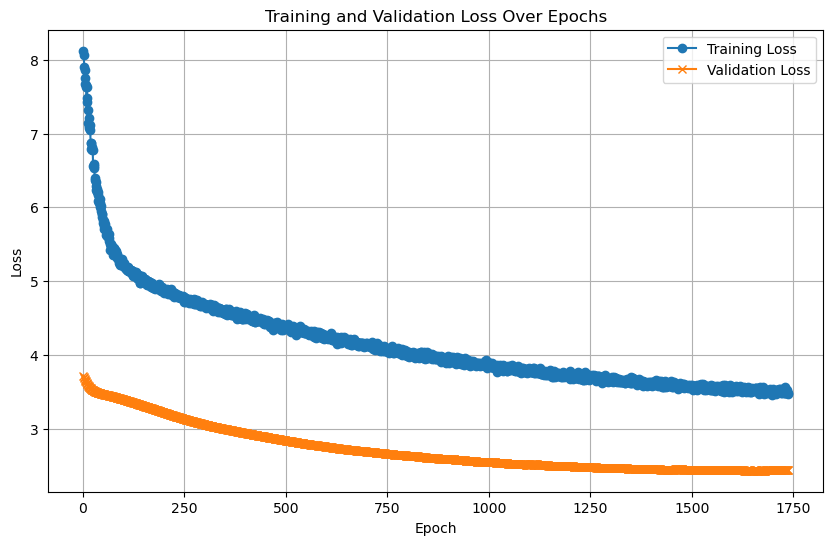

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.4912

Test Loss: 5.0846


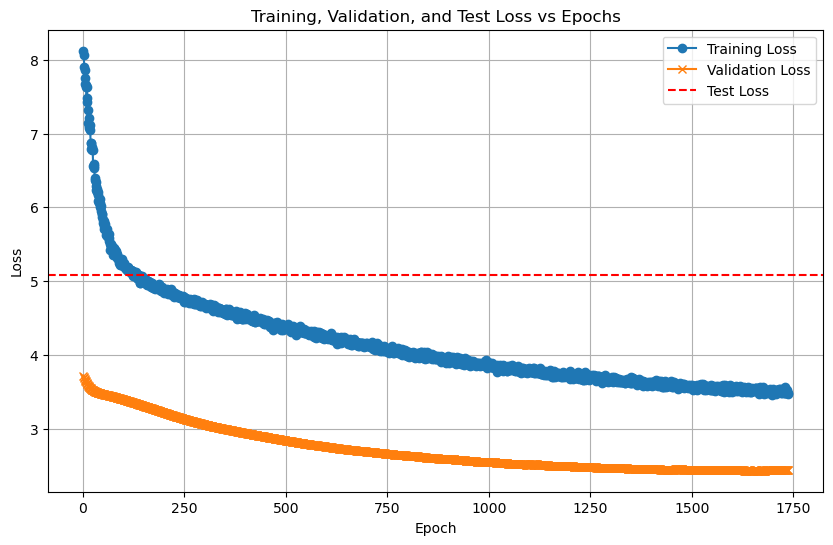

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      0.80      0.89         5
           4       1.00      0.60      0.75         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.67      0.80      0.73         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8569  |  Val Loss: 2.8501
Validation loss improved from inf to 2.8501.
[Epoch 2/1000] Train Loss: 2.8064  |  Val Loss: 2.7970
Validation loss improved from 2.8501 to 2.7970.
[Epoch 3/1000] Train Loss: 2.7583  |  Val Loss: 2.7494
Validation loss improved from 2.7970 to 2.7494.
[Epoch 4/1000] Train Loss: 2.7115  |  Val Loss: 2.7052
Validation loss improved from 2.7494 to 2.7052.
[Epoch 5/1000] Train Loss: 2.6694  |  Val Loss: 2.6619
Validation loss improved from 2.7052 to 2.6619.
[Epoch 6/1000] Train Loss: 2.6333  |  Val Loss: 2.6227
Validation loss improved from 2.6619 to 2.6227.
[Epoch 7/1000] Train Loss: 2.5997  |  Val Loss: 2.5899
Validation loss improved from 2.6227 to 2.5899.
[Epoch 8/1000] Train Loss: 2.5677  |  Val Loss: 2.5637
Validation loss improved from 2.5899 to 2.5637.
[Epoch 9/1000] Train Loss: 2.5403  |  Val Loss: 2.5388
Validation loss improved from 2.5637 to 2.5388.


[Epoch 10/1000] Train Loss: 2.5150  |  Val Loss: 2.5144
Validation loss improved from 2.5388 to 2.5144.
[Epoch 11/1000] Train Loss: 2.4901  |  Val Loss: 2.4911
Validation loss improved from 2.5144 to 2.4911.
[Epoch 12/1000] Train Loss: 2.4663  |  Val Loss: 2.4691
Validation loss improved from 2.4911 to 2.4691.
[Epoch 13/1000] Train Loss: 2.4435  |  Val Loss: 2.4477
Validation loss improved from 2.4691 to 2.4477.
[Epoch 14/1000] Train Loss: 2.4213  |  Val Loss: 2.4265
Validation loss improved from 2.4477 to 2.4265.
[Epoch 15/1000] Train Loss: 2.3995  |  Val Loss: 2.4056
Validation loss improved from 2.4265 to 2.4056.
[Epoch 16/1000] Train Loss: 2.3786  |  Val Loss: 2.3851
Validation loss improved from 2.4056 to 2.3851.


[Epoch 17/1000] Train Loss: 2.3574  |  Val Loss: 2.3654
Validation loss improved from 2.3851 to 2.3654.


[Epoch 18/1000] Train Loss: 2.3374  |  Val Loss: 2.3454
Validation loss improved from 2.3654 to 2.3454.
[Epoch 19/1000] Train Loss: 2.3163  |  Val Loss: 2.3257
Validation loss improved from 2.3454 to 2.3257.
[Epoch 20/1000] Train Loss: 2.2955  |  Val Loss: 2.3056
Validation loss improved from 2.3257 to 2.3056.
[Epoch 21/1000] Train Loss: 2.2752  |  Val Loss: 2.2855
Validation loss improved from 2.3056 to 2.2855.
[Epoch 22/1000] Train Loss: 2.2543  |  Val Loss: 2.2648
Validation loss improved from 2.2855 to 2.2648.
[Epoch 23/1000] Train Loss: 2.2318  |  Val Loss: 2.2443
Validation loss improved from 2.2648 to 2.2443.
[Epoch 24/1000] Train Loss: 2.2102  |  Val Loss: 2.2233
Validation loss improved from 2.2443 to 2.2233.
[Epoch 25/1000] Train Loss: 2.1875  |  Val Loss: 2.2021
Validation loss improved from 2.2233 to 2.2021.
[Epoch 26/1000] Train Loss: 2.1647  |  Val Loss: 2.1807
Validation loss improved from 2.2021 to 2.1807.
[Epoch 27/1000] Train Loss: 2.1419  |  Val Loss: 2.1597
Validati

[Epoch 31/1000] Train Loss: 2.0501  |  Val Loss: 2.0752
Validation loss improved from 2.0963 to 2.0752.
[Epoch 32/1000] Train Loss: 2.0272  |  Val Loss: 2.0542
Validation loss improved from 2.0752 to 2.0542.
[Epoch 33/1000] Train Loss: 2.0037  |  Val Loss: 2.0325
Validation loss improved from 2.0542 to 2.0325.
[Epoch 34/1000] Train Loss: 1.9794  |  Val Loss: 2.0102
Validation loss improved from 2.0325 to 2.0102.
[Epoch 35/1000] Train Loss: 1.9552  |  Val Loss: 1.9871
Validation loss improved from 2.0102 to 1.9871.


[Epoch 36/1000] Train Loss: 1.9301  |  Val Loss: 1.9642
Validation loss improved from 1.9871 to 1.9642.
[Epoch 37/1000] Train Loss: 1.9060  |  Val Loss: 1.9417
Validation loss improved from 1.9642 to 1.9417.
[Epoch 38/1000] Train Loss: 1.8817  |  Val Loss: 1.9192
Validation loss improved from 1.9417 to 1.9192.
[Epoch 39/1000] Train Loss: 1.8574  |  Val Loss: 1.8968
Validation loss improved from 1.9192 to 1.8968.
[Epoch 40/1000] Train Loss: 1.8335  |  Val Loss: 1.8747
Validation loss improved from 1.8968 to 1.8747.
[Epoch 41/1000] Train Loss: 1.8094  |  Val Loss: 1.8531
Validation loss improved from 1.8747 to 1.8531.
[Epoch 42/1000] Train Loss: 1.7860  |  Val Loss: 1.8321
Validation loss improved from 1.8531 to 1.8321.
[Epoch 43/1000] Train Loss: 1.7626  |  Val Loss: 1.8110
Validation loss improved from 1.8321 to 1.8110.
[Epoch 44/1000] Train Loss: 1.7400  |  Val Loss: 1.7902
Validation loss improved from 1.8110 to 1.7902.
[Epoch 45/1000] Train Loss: 1.7180  |  Val Loss: 1.7691
Validati

[Epoch 49/1000] Train Loss: 1.6338  |  Val Loss: 1.6922
Validation loss improved from 1.7107 to 1.6922.
[Epoch 50/1000] Train Loss: 1.6138  |  Val Loss: 1.6737
Validation loss improved from 1.6922 to 1.6737.
[Epoch 51/1000] Train Loss: 1.5945  |  Val Loss: 1.6556
Validation loss improved from 1.6737 to 1.6556.
[Epoch 52/1000] Train Loss: 1.5751  |  Val Loss: 1.6383
Validation loss improved from 1.6556 to 1.6383.
[Epoch 53/1000] Train Loss: 1.5564  |  Val Loss: 1.6214
Validation loss improved from 1.6383 to 1.6214.
[Epoch 54/1000] Train Loss: 1.5384  |  Val Loss: 1.6048
Validation loss improved from 1.6214 to 1.6048.
[Epoch 55/1000] Train Loss: 1.5205  |  Val Loss: 1.5884
Validation loss improved from 1.6048 to 1.5884.


[Epoch 56/1000] Train Loss: 1.5032  |  Val Loss: 1.5725
Validation loss improved from 1.5884 to 1.5725.
[Epoch 57/1000] Train Loss: 1.4861  |  Val Loss: 1.5561
Validation loss improved from 1.5725 to 1.5561.
[Epoch 58/1000] Train Loss: 1.4692  |  Val Loss: 1.5402
Validation loss improved from 1.5561 to 1.5402.
[Epoch 59/1000] Train Loss: 1.4525  |  Val Loss: 1.5249
Validation loss improved from 1.5402 to 1.5249.
[Epoch 60/1000] Train Loss: 1.4366  |  Val Loss: 1.5097
Validation loss improved from 1.5249 to 1.5097.
[Epoch 61/1000] Train Loss: 1.4206  |  Val Loss: 1.4948
Validation loss improved from 1.5097 to 1.4948.
[Epoch 62/1000] Train Loss: 1.4049  |  Val Loss: 1.4802
Validation loss improved from 1.4948 to 1.4802.
[Epoch 63/1000] Train Loss: 1.3896  |  Val Loss: 1.4654
Validation loss improved from 1.4802 to 1.4654.
[Epoch 64/1000] Train Loss: 1.3743  |  Val Loss: 1.4509
Validation loss improved from 1.4654 to 1.4509.
[Epoch 65/1000] Train Loss: 1.3594  |  Val Loss: 1.4365
Validati

[Epoch 67/1000] Train Loss: 1.3301  |  Val Loss: 1.4087
Validation loss improved from 1.4226 to 1.4087.
[Epoch 68/1000] Train Loss: 1.3157  |  Val Loss: 1.3953
Validation loss improved from 1.4087 to 1.3953.
[Epoch 69/1000] Train Loss: 1.3014  |  Val Loss: 1.3818
Validation loss improved from 1.3953 to 1.3818.
[Epoch 70/1000] Train Loss: 1.2870  |  Val Loss: 1.3686
Validation loss improved from 1.3818 to 1.3686.
[Epoch 71/1000] Train Loss: 1.2734  |  Val Loss: 1.3557
Validation loss improved from 1.3686 to 1.3557.
[Epoch 72/1000] Train Loss: 1.2592  |  Val Loss: 1.3433
Validation loss improved from 1.3557 to 1.3433.
[Epoch 73/1000] Train Loss: 1.2459  |  Val Loss: 1.3312
Validation loss improved from 1.3433 to 1.3312.


[Epoch 74/1000] Train Loss: 1.2329  |  Val Loss: 1.3183
Validation loss improved from 1.3312 to 1.3183.
[Epoch 75/1000] Train Loss: 1.2198  |  Val Loss: 1.3059
Validation loss improved from 1.3183 to 1.3059.
[Epoch 76/1000] Train Loss: 1.2071  |  Val Loss: 1.2940
Validation loss improved from 1.3059 to 1.2940.
[Epoch 77/1000] Train Loss: 1.1946  |  Val Loss: 1.2814
Validation loss improved from 1.2940 to 1.2814.
[Epoch 78/1000] Train Loss: 1.1820  |  Val Loss: 1.2692
Validation loss improved from 1.2814 to 1.2692.
[Epoch 79/1000] Train Loss: 1.1700  |  Val Loss: 1.2571
Validation loss improved from 1.2692 to 1.2571.
[Epoch 80/1000] Train Loss: 1.1578  |  Val Loss: 1.2455
Validation loss improved from 1.2571 to 1.2455.
[Epoch 81/1000] Train Loss: 1.1458  |  Val Loss: 1.2337
Validation loss improved from 1.2455 to 1.2337.
[Epoch 82/1000] Train Loss: 1.1340  |  Val Loss: 1.2226
Validation loss improved from 1.2337 to 1.2226.
[Epoch 83/1000] Train Loss: 1.1228  |  Val Loss: 1.2118
Validati

[Epoch 86/1000] Train Loss: 1.0887  |  Val Loss: 1.1790
Validation loss improved from 1.1894 to 1.1790.
[Epoch 87/1000] Train Loss: 1.0776  |  Val Loss: 1.1685
Validation loss improved from 1.1790 to 1.1685.
[Epoch 88/1000] Train Loss: 1.0666  |  Val Loss: 1.1578
Validation loss improved from 1.1685 to 1.1578.
[Epoch 89/1000] Train Loss: 1.0561  |  Val Loss: 1.1472
Validation loss improved from 1.1578 to 1.1472.
[Epoch 90/1000] Train Loss: 1.0455  |  Val Loss: 1.1367
Validation loss improved from 1.1472 to 1.1367.
[Epoch 91/1000] Train Loss: 1.0350  |  Val Loss: 1.1266
Validation loss improved from 1.1367 to 1.1266.
[Epoch 92/1000] Train Loss: 1.0244  |  Val Loss: 1.1164
Validation loss improved from 1.1266 to 1.1164.


[Epoch 93/1000] Train Loss: 1.0141  |  Val Loss: 1.1067
Validation loss improved from 1.1164 to 1.1067.
[Epoch 94/1000] Train Loss: 1.0039  |  Val Loss: 1.0970
Validation loss improved from 1.1067 to 1.0970.
[Epoch 95/1000] Train Loss: 0.9937  |  Val Loss: 1.0875
Validation loss improved from 1.0970 to 1.0875.
[Epoch 96/1000] Train Loss: 0.9840  |  Val Loss: 1.0778
Validation loss improved from 1.0875 to 1.0778.
[Epoch 97/1000] Train Loss: 0.9739  |  Val Loss: 1.0683
Validation loss improved from 1.0778 to 1.0683.
[Epoch 98/1000] Train Loss: 0.9639  |  Val Loss: 1.0585
Validation loss improved from 1.0683 to 1.0585.
[Epoch 99/1000] Train Loss: 0.9543  |  Val Loss: 1.0491
Validation loss improved from 1.0585 to 1.0491.
[Epoch 100/1000] Train Loss: 0.9448  |  Val Loss: 1.0402
Validation loss improved from 1.0491 to 1.0402.
[Epoch 101/1000] Train Loss: 0.9347  |  Val Loss: 1.0309
Validation loss improved from 1.0402 to 1.0309.
[Epoch 102/1000] Train Loss: 0.9252  |  Val Loss: 1.0215
Valid

[Epoch 105/1000] Train Loss: 0.8971  |  Val Loss: 0.9951
Validation loss improved from 1.0035 to 0.9951.
[Epoch 106/1000] Train Loss: 0.8878  |  Val Loss: 0.9868
Validation loss improved from 0.9951 to 0.9868.
[Epoch 107/1000] Train Loss: 0.8789  |  Val Loss: 0.9778
Validation loss improved from 0.9868 to 0.9778.
[Epoch 108/1000] Train Loss: 0.8696  |  Val Loss: 0.9686
Validation loss improved from 0.9778 to 0.9686.
[Epoch 109/1000] Train Loss: 0.8609  |  Val Loss: 0.9594
Validation loss improved from 0.9686 to 0.9594.
[Epoch 110/1000] Train Loss: 0.8517  |  Val Loss: 0.9505
Validation loss improved from 0.9594 to 0.9505.
[Epoch 111/1000] Train Loss: 0.8428  |  Val Loss: 0.9418
Validation loss improved from 0.9505 to 0.9418.


[Epoch 112/1000] Train Loss: 0.8341  |  Val Loss: 0.9334
Validation loss improved from 0.9418 to 0.9334.
[Epoch 113/1000] Train Loss: 0.8251  |  Val Loss: 0.9253
Validation loss improved from 0.9334 to 0.9253.
[Epoch 114/1000] Train Loss: 0.8163  |  Val Loss: 0.9168
Validation loss improved from 0.9253 to 0.9168.
[Epoch 115/1000] Train Loss: 0.8078  |  Val Loss: 0.9085
Validation loss improved from 0.9168 to 0.9085.
[Epoch 116/1000] Train Loss: 0.7988  |  Val Loss: 0.8994
Validation loss improved from 0.9085 to 0.8994.
[Epoch 117/1000] Train Loss: 0.7900  |  Val Loss: 0.8910
Validation loss improved from 0.8994 to 0.8910.
[Epoch 118/1000] Train Loss: 0.7813  |  Val Loss: 0.8822
Validation loss improved from 0.8910 to 0.8822.
[Epoch 119/1000] Train Loss: 0.7727  |  Val Loss: 0.8737
Validation loss improved from 0.8822 to 0.8737.
[Epoch 120/1000] Train Loss: 0.7635  |  Val Loss: 0.8657
Validation loss improved from 0.8737 to 0.8657.
[Epoch 121/1000] Train Loss: 0.7549  |  Val Loss: 0.857

[Epoch 124/1000] Train Loss: 0.7299  |  Val Loss: 0.8349
Validation loss improved from 0.8429 to 0.8349.
[Epoch 125/1000] Train Loss: 0.7216  |  Val Loss: 0.8271
Validation loss improved from 0.8349 to 0.8271.
[Epoch 126/1000] Train Loss: 0.7133  |  Val Loss: 0.8191
Validation loss improved from 0.8271 to 0.8191.
[Epoch 127/1000] Train Loss: 0.7054  |  Val Loss: 0.8110
Validation loss improved from 0.8191 to 0.8110.
[Epoch 128/1000] Train Loss: 0.6973  |  Val Loss: 0.8028
Validation loss improved from 0.8110 to 0.8028.
[Epoch 129/1000] Train Loss: 0.6891  |  Val Loss: 0.7947
Validation loss improved from 0.8028 to 0.7947.
[Epoch 130/1000] Train Loss: 0.6810  |  Val Loss: 0.7874
Validation loss improved from 0.7947 to 0.7874.


[Epoch 131/1000] Train Loss: 0.6734  |  Val Loss: 0.7801
Validation loss improved from 0.7874 to 0.7801.
[Epoch 132/1000] Train Loss: 0.6652  |  Val Loss: 0.7735
Validation loss improved from 0.7801 to 0.7735.
[Epoch 133/1000] Train Loss: 0.6575  |  Val Loss: 0.7670
Validation loss improved from 0.7735 to 0.7670.
[Epoch 134/1000] Train Loss: 0.6499  |  Val Loss: 0.7604
Validation loss improved from 0.7670 to 0.7604.
[Epoch 135/1000] Train Loss: 0.6420  |  Val Loss: 0.7536
Validation loss improved from 0.7604 to 0.7536.
[Epoch 136/1000] Train Loss: 0.6346  |  Val Loss: 0.7471
Validation loss improved from 0.7536 to 0.7471.
[Epoch 137/1000] Train Loss: 0.6271  |  Val Loss: 0.7391
Validation loss improved from 0.7471 to 0.7391.
[Epoch 138/1000] Train Loss: 0.6190  |  Val Loss: 0.7311
Validation loss improved from 0.7391 to 0.7311.
[Epoch 139/1000] Train Loss: 0.6119  |  Val Loss: 0.7239
Validation loss improved from 0.7311 to 0.7239.
[Epoch 140/1000] Train Loss: 0.6040  |  Val Loss: 0.717

[Epoch 142/1000] Train Loss: 0.5893  |  Val Loss: 0.7037
Validation loss improved from 0.7101 to 0.7037.
[Epoch 143/1000] Train Loss: 0.5820  |  Val Loss: 0.6976
Validation loss improved from 0.7037 to 0.6976.
[Epoch 144/1000] Train Loss: 0.5748  |  Val Loss: 0.6919
Validation loss improved from 0.6976 to 0.6919.
[Epoch 145/1000] Train Loss: 0.5680  |  Val Loss: 0.6865
Validation loss improved from 0.6919 to 0.6865.
[Epoch 146/1000] Train Loss: 0.5615  |  Val Loss: 0.6811
Validation loss improved from 0.6865 to 0.6811.
[Epoch 147/1000] Train Loss: 0.5547  |  Val Loss: 0.6750
Validation loss improved from 0.6811 to 0.6750.


[Epoch 148/1000] Train Loss: 0.5475  |  Val Loss: 0.6689
Validation loss improved from 0.6750 to 0.6689.
[Epoch 149/1000] Train Loss: 0.5406  |  Val Loss: 0.6626
Validation loss improved from 0.6689 to 0.6626.
[Epoch 150/1000] Train Loss: 0.5340  |  Val Loss: 0.6567
Validation loss improved from 0.6626 to 0.6567.
[Epoch 151/1000] Train Loss: 0.5276  |  Val Loss: 0.6506
Validation loss improved from 0.6567 to 0.6506.
[Epoch 152/1000] Train Loss: 0.5210  |  Val Loss: 0.6443
Validation loss improved from 0.6506 to 0.6443.
[Epoch 153/1000] Train Loss: 0.5144  |  Val Loss: 0.6381
Validation loss improved from 0.6443 to 0.6381.
[Epoch 154/1000] Train Loss: 0.5078  |  Val Loss: 0.6313
Validation loss improved from 0.6381 to 0.6313.
[Epoch 155/1000] Train Loss: 0.5014  |  Val Loss: 0.6256
Validation loss improved from 0.6313 to 0.6256.
[Epoch 156/1000] Train Loss: 0.4946  |  Val Loss: 0.6201
Validation loss improved from 0.6256 to 0.6201.
[Epoch 157/1000] Train Loss: 0.4884  |  Val Loss: 0.614

[Epoch 161/1000] Train Loss: 0.4644  |  Val Loss: 0.5914
Validation loss improved from 0.5969 to 0.5914.
[Epoch 162/1000] Train Loss: 0.4588  |  Val Loss: 0.5862
Validation loss improved from 0.5914 to 0.5862.
[Epoch 163/1000] Train Loss: 0.4530  |  Val Loss: 0.5811
Validation loss improved from 0.5862 to 0.5811.
[Epoch 164/1000] Train Loss: 0.4469  |  Val Loss: 0.5765
Validation loss improved from 0.5811 to 0.5765.
[Epoch 165/1000] Train Loss: 0.4412  |  Val Loss: 0.5710
Validation loss improved from 0.5765 to 0.5710.
[Epoch 166/1000] Train Loss: 0.4361  |  Val Loss: 0.5658
Validation loss improved from 0.5710 to 0.5658.


[Epoch 167/1000] Train Loss: 0.4309  |  Val Loss: 0.5604
Validation loss improved from 0.5658 to 0.5604.
[Epoch 168/1000] Train Loss: 0.4258  |  Val Loss: 0.5555
Validation loss improved from 0.5604 to 0.5555.
[Epoch 169/1000] Train Loss: 0.4202  |  Val Loss: 0.5510
Validation loss improved from 0.5555 to 0.5510.
[Epoch 170/1000] Train Loss: 0.4153  |  Val Loss: 0.5471
Validation loss improved from 0.5510 to 0.5471.
[Epoch 171/1000] Train Loss: 0.4102  |  Val Loss: 0.5425
Validation loss improved from 0.5471 to 0.5425.
[Epoch 172/1000] Train Loss: 0.4049  |  Val Loss: 0.5377
Validation loss improved from 0.5425 to 0.5377.
[Epoch 173/1000] Train Loss: 0.3999  |  Val Loss: 0.5332
Validation loss improved from 0.5377 to 0.5332.
[Epoch 174/1000] Train Loss: 0.3948  |  Val Loss: 0.5289
Validation loss improved from 0.5332 to 0.5289.
[Epoch 175/1000] Train Loss: 0.3900  |  Val Loss: 0.5246
Validation loss improved from 0.5289 to 0.5246.
[Epoch 176/1000] Train Loss: 0.3851  |  Val Loss: 0.519

[Epoch 181/1000] Train Loss: 0.3602  |  Val Loss: 0.5010
Validation loss improved from 0.5042 to 0.5010.
[Epoch 182/1000] Train Loss: 0.3551  |  Val Loss: 0.4969
Validation loss improved from 0.5010 to 0.4969.
[Epoch 183/1000] Train Loss: 0.3500  |  Val Loss: 0.4926
Validation loss improved from 0.4969 to 0.4926.
[Epoch 184/1000] Train Loss: 0.3457  |  Val Loss: 0.4884
Validation loss improved from 0.4926 to 0.4884.


[Epoch 185/1000] Train Loss: 0.3415  |  Val Loss: 0.4843
Validation loss improved from 0.4884 to 0.4843.
[Epoch 186/1000] Train Loss: 0.3372  |  Val Loss: 0.4814
Validation loss improved from 0.4843 to 0.4814.
[Epoch 187/1000] Train Loss: 0.3330  |  Val Loss: 0.4786
Validation loss improved from 0.4814 to 0.4786.
[Epoch 188/1000] Train Loss: 0.3290  |  Val Loss: 0.4765
Validation loss improved from 0.4786 to 0.4765.
[Epoch 189/1000] Train Loss: 0.3258  |  Val Loss: 0.4751
Validation loss improved from 0.4765 to 0.4751.
[Epoch 190/1000] Train Loss: 0.3220  |  Val Loss: 0.4722
Validation loss improved from 0.4751 to 0.4722.
[Epoch 191/1000] Train Loss: 0.3183  |  Val Loss: 0.4680
Validation loss improved from 0.4722 to 0.4680.
[Epoch 192/1000] Train Loss: 0.3145  |  Val Loss: 0.4629
Validation loss improved from 0.4680 to 0.4629.
[Epoch 193/1000] Train Loss: 0.3109  |  Val Loss: 0.4594
Validation loss improved from 0.4629 to 0.4594.
[Epoch 194/1000] Train Loss: 0.3072  |  Val Loss: 0.456

[Epoch 200/1000] Train Loss: 0.2877  |  Val Loss: 0.4384
Validation loss improved from 0.4409 to 0.4384.


[Epoch 201/1000] Train Loss: 0.2848  |  Val Loss: 0.4351
Validation loss improved from 0.4384 to 0.4351.
[Epoch 202/1000] Train Loss: 0.2815  |  Val Loss: 0.4321
Validation loss improved from 0.4351 to 0.4321.
[Epoch 203/1000] Train Loss: 0.2796  |  Val Loss: 0.4285
Validation loss improved from 0.4321 to 0.4285.
[Epoch 204/1000] Train Loss: 0.2757  |  Val Loss: 0.4263
Validation loss improved from 0.4285 to 0.4263.
[Epoch 205/1000] Train Loss: 0.2727  |  Val Loss: 0.4245
Validation loss improved from 0.4263 to 0.4245.
[Epoch 206/1000] Train Loss: 0.2699  |  Val Loss: 0.4231
Validation loss improved from 0.4245 to 0.4231.
[Epoch 207/1000] Train Loss: 0.2673  |  Val Loss: 0.4219
Validation loss improved from 0.4231 to 0.4219.
[Epoch 208/1000] Train Loss: 0.2646  |  Val Loss: 0.4210
Validation loss improved from 0.4219 to 0.4210.
[Epoch 209/1000] Train Loss: 0.2626  |  Val Loss: 0.4196
Validation loss improved from 0.4210 to 0.4196.
[Epoch 210/1000] Train Loss: 0.2596  |  Val Loss: 0.415

[Epoch 220/1000] Train Loss: 0.2343  |  Val Loss: 0.3944
Validation loss improved from 0.3956 to 0.3944.
[Epoch 221/1000] Train Loss: 0.2326  |  Val Loss: 0.3922
Validation loss improved from 0.3944 to 0.3922.
[Epoch 222/1000] Train Loss: 0.2304  |  Val Loss: 0.3901
Validation loss improved from 0.3922 to 0.3901.
[Epoch 223/1000] Train Loss: 0.2282  |  Val Loss: 0.3877
Validation loss improved from 0.3901 to 0.3877.
[Epoch 224/1000] Train Loss: 0.2261  |  Val Loss: 0.3861
Validation loss improved from 0.3877 to 0.3861.
[Epoch 225/1000] Train Loss: 0.2240  |  Val Loss: 0.3846
Validation loss improved from 0.3861 to 0.3846.
[Epoch 226/1000] Train Loss: 0.2220  |  Val Loss: 0.3827
Validation loss improved from 0.3846 to 0.3827.
[Epoch 227/1000] Train Loss: 0.2199  |  Val Loss: 0.3822
Validation loss improved from 0.3827 to 0.3822.
[Epoch 228/1000] Train Loss: 0.2176  |  Val Loss: 0.3805
Validation loss improved from 0.3822 to 0.3805.
[Epoch 229/1000] Train Loss: 0.2158  |  Val Loss: 0.379

[Epoch 240/1000] Train Loss: 0.1959  |  Val Loss: 0.3673
Validation loss improved from 0.3682 to 0.3673.
[Epoch 241/1000] Train Loss: 0.1946  |  Val Loss: 0.3657
Validation loss improved from 0.3673 to 0.3657.
[Epoch 242/1000] Train Loss: 0.1932  |  Val Loss: 0.3636
Validation loss improved from 0.3657 to 0.3636.
[Epoch 243/1000] Train Loss: 0.1911  |  Val Loss: 0.3614
Validation loss improved from 0.3636 to 0.3614.
[Epoch 244/1000] Train Loss: 0.1897  |  Val Loss: 0.3595
Validation loss improved from 0.3614 to 0.3595.
[Epoch 245/1000] Train Loss: 0.1885  |  Val Loss: 0.3580
Validation loss improved from 0.3595 to 0.3580.
[Epoch 246/1000] Train Loss: 0.1869  |  Val Loss: 0.3576
Validation loss improved from 0.3580 to 0.3576.
[Epoch 247/1000] Train Loss: 0.1856  |  Val Loss: 0.3577
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 0.1836  |  Val Loss: 0.3570
Validation loss improved from 0.3576 to 0.3570.
[Epoch 249/1000] Train Loss: 0.1829  |  Val Loss:

[Epoch 259/1000] Train Loss: 0.1695  |  Val Loss: 0.3451
Validation loss improved from 0.3456 to 0.3451.
[Epoch 260/1000] Train Loss: 0.1679  |  Val Loss: 0.3450
Validation loss improved from 0.3451 to 0.3450.
[Epoch 261/1000] Train Loss: 0.1665  |  Val Loss: 0.3456
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 262/1000] Train Loss: 0.1657  |  Val Loss: 0.3460
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 263/1000] Train Loss: 0.1644  |  Val Loss: 0.3448
Validation loss improved from 0.3450 to 0.3448.
[Epoch 264/1000] Train Loss: 0.1635  |  Val Loss: 0.3441
Validation loss improved from 0.3448 to 0.3441.
[Epoch 265/1000] Train Loss: 0.1626  |  Val Loss: 0.3420
Validation loss improved from 0.3441 to 0.3420.
[Epoch 266/1000] Train Loss: 0.1612  |  Val Loss: 0.3413
Validation loss improved from 0.3420 to 0.3413.
[Epoch 267/1000] Train Loss: 0.1598  |  Val Loss: 0.3397
Validation loss improved from 0.3413 to 0.3397.
[Epoch 268/1000] Train Loss: 0.1595  |  Val

[Epoch 278/1000] Train Loss: 0.1492  |  Val Loss: 0.3334
Validation loss improved from 0.3345 to 0.3334.
[Epoch 279/1000] Train Loss: 0.1482  |  Val Loss: 0.3332
Validation loss improved from 0.3334 to 0.3332.
[Epoch 280/1000] Train Loss: 0.1472  |  Val Loss: 0.3330
Validation loss improved from 0.3332 to 0.3330.
[Epoch 281/1000] Train Loss: 0.1462  |  Val Loss: 0.3328
Validation loss improved from 0.3330 to 0.3328.
[Epoch 282/1000] Train Loss: 0.1454  |  Val Loss: 0.3327
Validation loss improved from 0.3328 to 0.3327.
[Epoch 283/1000] Train Loss: 0.1444  |  Val Loss: 0.3323
Validation loss improved from 0.3327 to 0.3323.
[Epoch 284/1000] Train Loss: 0.1436  |  Val Loss: 0.3313
Validation loss improved from 0.3323 to 0.3313.
[Epoch 285/1000] Train Loss: 0.1425  |  Val Loss: 0.3302
Validation loss improved from 0.3313 to 0.3302.
[Epoch 286/1000] Train Loss: 0.1418  |  Val Loss: 0.3290
Validation loss improved from 0.3302 to 0.3290.
[Epoch 287/1000] Train Loss: 0.1421  |  Val Loss: 0.328

[Epoch 298/1000] Train Loss: 0.1328  |  Val Loss: 0.3274
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 299/1000] Train Loss: 0.1320  |  Val Loss: 0.3270
Validation loss improved from 0.3272 to 0.3270.
[Epoch 300/1000] Train Loss: 0.1312  |  Val Loss: 0.3271
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 301/1000] Train Loss: 0.1307  |  Val Loss: 0.3265
Validation loss improved from 0.3270 to 0.3265.
[Epoch 302/1000] Train Loss: 0.1302  |  Val Loss: 0.3253
Validation loss improved from 0.3265 to 0.3253.
[Epoch 303/1000] Train Loss: 0.1292  |  Val Loss: 0.3248
Validation loss improved from 0.3253 to 0.3248.
[Epoch 304/1000] Train Loss: 0.1285  |  Val Loss: 0.3245
Validation loss improved from 0.3248 to 0.3245.
[Epoch 305/1000] Train Loss: 0.1278  |  Val Loss: 0.3245
Validation loss improved from 0.3245 to 0.3245.
[Epoch 306/1000] Train Loss: 0.1272  |  Val Loss: 0.3245
Validation loss improved from 0.3245 to 0.3245.
[Epoch 307/1000] Train Loss: 0.1264  |  Val

[Epoch 317/1000] Train Loss: 0.1208  |  Val Loss: 0.3241
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 318/1000] Train Loss: 0.1200  |  Val Loss: 0.3219
Validation loss improved from 0.3232 to 0.3219.
[Epoch 319/1000] Train Loss: 0.1191  |  Val Loss: 0.3212
Validation loss improved from 0.3219 to 0.3212.
[Epoch 320/1000] Train Loss: 0.1187  |  Val Loss: 0.3214
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 321/1000] Train Loss: 0.1180  |  Val Loss: 0.3215
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 322/1000] Train Loss: 0.1175  |  Val Loss: 0.3217
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 323/1000] Train Loss: 0.1167  |  Val Loss: 0.3219
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 324/1000] Train Loss: 0.1164  |  Val Loss: 0.3225
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 325/1000] Train Loss: 0.1161  |  Val Loss: 0.3220
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 326/10

[Epoch 335/1000] Train Loss: 0.1108  |  Val Loss: 0.3206
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 336/1000] Train Loss: 0.1105  |  Val Loss: 0.3206
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 337/1000] Train Loss: 0.1098  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 338/1000] Train Loss: 0.1094  |  Val Loss: 0.3220
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 339/1000] Train Loss: 0.1090  |  Val Loss: 0.3222
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 340/1000] Train Loss: 0.1088  |  Val Loss: 0.3211
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 341/1000] Train Loss: 0.1078  |  Val Loss: 0.3210
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 342/1000] Train Loss: 0.1075  |  Val Loss: 0.3213
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 343/1000] Train Loss: 0.1072  |  Val Loss: 0.3210
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 353/1000] Train Loss: 0.1028  |  Val Loss: 0.3207
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 354/1000] Train Loss: 0.1026  |  Val Loss: 0.3203
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 355/1000] Train Loss: 0.1019  |  Val Loss: 0.3202
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 356/1000] Train Loss: 0.1017  |  Val Loss: 0.3206
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 357/1000] Train Loss: 0.1015  |  Val Loss: 0.3203
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 358/1000] Train Loss: 0.1009  |  Val Loss: 0.3208
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 359/1000] Train Loss: 0.1005  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 360/1000] Train Loss: 0.1002  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 361/1000] Train Loss: 0.0997  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 373/1000] Train Loss: 0.0953  |  Val Loss: 0.3212
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 374/1000] Train Loss: 0.0952  |  Val Loss: 0.3207
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 375/1000] Train Loss: 0.0947  |  Val Loss: 0.3213
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 376/1000] Train Loss: 0.0945  |  Val Loss: 0.3207
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 377/1000] Train Loss: 0.0941  |  Val Loss: 0.3207
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 378/1000] Train Loss: 0.0941  |  Val Loss: 0.3206
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 379/1000] Train Loss: 0.0939  |  Val Loss: 0.3213
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 380/1000] Train Loss: 0.0932  |  Val Loss: 0.3215
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 381/1000] Train Loss: 0.0927  |  Val Loss: 0.3220
!! Validation loss did NOT improve !! Patience: 15

[Epoch 392/1000] Train Loss: 0.0900  |  Val Loss: 0.3203
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 393/1000] Train Loss: 0.0898  |  Val Loss: 0.3212
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 394/1000] Train Loss: 0.0895  |  Val Loss: 0.3221
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 395/1000] Train Loss: 0.0894  |  Val Loss: 0.3232
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 396/1000] Train Loss: 0.0890  |  Val Loss: 0.3217
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 397/1000] Train Loss: 0.0885  |  Val Loss: 0.3214
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 398/1000] Train Loss: 0.0881  |  Val Loss: 0.3218
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 399/1000] Train Loss: 0.0877  |  Val Loss: 0.3222
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 400/1000] Train Loss: 0.0875  |  Val Loss: 0.3224
!! Validation loss did NOT improve !! Patience:

[Epoch 412/1000] Train Loss: 0.0844  |  Val Loss: 0.3243
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 413/1000] Train Loss: 0.0836  |  Val Loss: 0.3232
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 414/1000] Train Loss: 0.0841  |  Val Loss: 0.3228
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 415/1000] Train Loss: 0.0841  |  Val Loss: 0.3229
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 416/1000] Train Loss: 0.0839  |  Val Loss: 0.3233
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 417/1000] Train Loss: 0.0836  |  Val Loss: 0.3241
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 418/1000] Train Loss: 0.0830  |  Val Loss: 0.3246
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 419/1000] Train Loss: 0.0827  |  Val Loss: 0.3249
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 420/1000] Train Loss: 0.0824  |  Val Loss: 0.3247
!! Validation loss did NOT improve !! Patience:

[Epoch 431/1000] Train Loss: 0.0801  |  Val Loss: 0.3251
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 432/1000] Train Loss: 0.0796  |  Val Loss: 0.3256
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 433/1000] Train Loss: 0.0794  |  Val Loss: 0.3256
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 434/1000] Train Loss: 0.0793  |  Val Loss: 0.3261
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 435/1000] Train Loss: 0.0791  |  Val Loss: 0.3264
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 436/1000] Train Loss: 0.0792  |  Val Loss: 0.3270
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 437/1000] Train Loss: 0.0787  |  Val Loss: 0.3270
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 438/1000] Train Loss: 0.0786  |  Val Loss: 0.3269
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 439/1000] Train Loss: 0.0784  |  Val Loss: 0.3272
!! Validation loss did NOT improve !! Patience:

[Epoch 450/1000] Train Loss: 0.0765  |  Val Loss: 0.3293
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 451/1000] Train Loss: 0.0763  |  Val Loss: 0.3292
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 452/1000] Train Loss: 0.0762  |  Val Loss: 0.3293
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 453/1000] Train Loss: 0.0759  |  Val Loss: 0.3286
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 454/1000] Train Loss: 0.0760  |  Val Loss: 0.3271
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 455/1000] Train Loss: 0.0758  |  Val Loss: 0.3268
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 456/1000] Train Loss: 0.0752  |  Val Loss: 0.3274
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 457/1000] Train Loss: 0.0755  |  Val Loss: 0.3287
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 458/1000] Train Loss: 0.0753  |  Val Loss: 0.3294
!! Validation loss did NOT improve !! Patience:

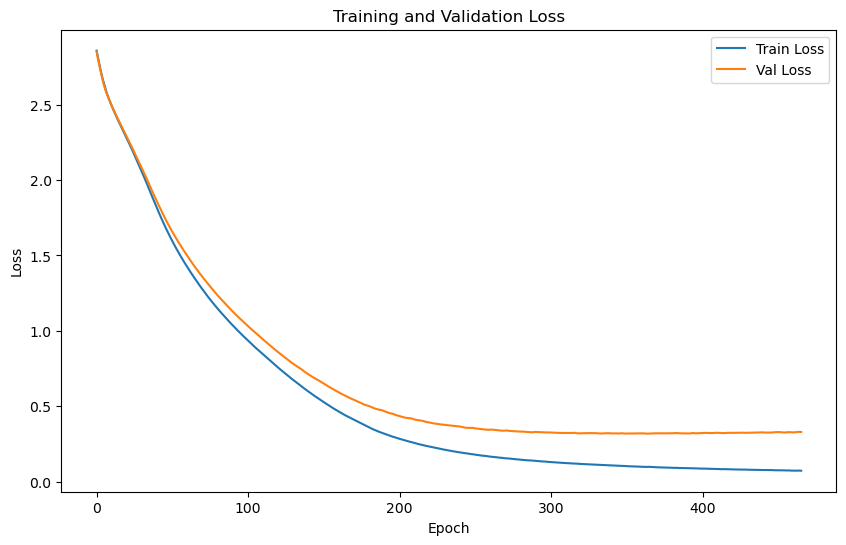

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4953 | Test Accuracy: 84.44%


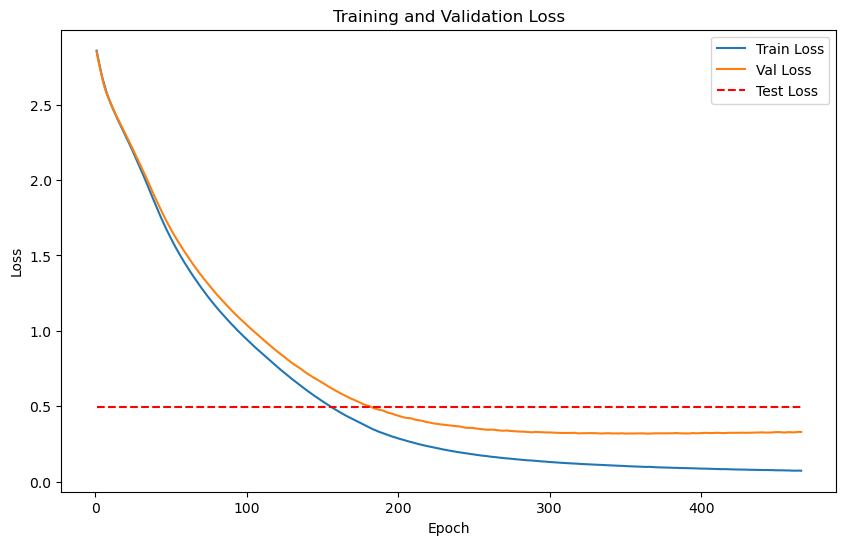

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.1180
Epoch [1/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.2939

Validation loss improved from inf to 0.2939. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.1189
Epoch [2/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.2947

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.1194
Epoch [3/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.2951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.1198
Epoch [4/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.1200
Epoch [5/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.1204
Epoch [6/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.2957

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.1186
Epoch [7/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.2947

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.1158
Epoch [8/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.2931

Validation loss improved from 0.2939 to 0.2931. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.1121
Epoch [9/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.2912

Validation loss improved from 0.2931 to 0.2912. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.1084
Epoch [10/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.2893

Validation loss improved from 0.2912 to 0.2893. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.1065
Epoch [11/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.2883

Validation loss improved from 0.2893 to 0.2883. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.1051
Epoch [12/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.2877

Validation loss improved from 0.2883 to 0.2877. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.1036
Epoch [13/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.2868

Validation loss improved from 0.2877 to 0.2868. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.1006
Epoch [14/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.2853

Validation loss improved from 0.2868 to 0.2853. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.0961
Epoch [15/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.2830

Validation loss improved from 0.2853 to 0.2830. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.0927
Epoch [16/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.2810

Validation loss improved from 0.2830 to 0.2810. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.0908
Epoch [17/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.2797

Validation loss improved from 0.2810 to 0.2797. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0892
Epoch [18/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.2787

Validation loss improved from 0.2797 to 0.2787. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.0875
Epoch [19/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.2779

Validation loss improved from 0.2787 to 0.2779. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.0849
Epoch [20/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.2762

Validation loss improved from 0.2779 to 0.2762. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.0808
Epoch [21/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.2738

Validation loss improved from 0.2762 to 0.2738. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.0772
Epoch [22/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.2715

Validation loss improved from 0.2738 to 0.2715. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.0744
Epoch [23/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.2695

Validation loss improved from 0.2715 to 0.2695. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.0729
Epoch [24/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.2684

Validation loss improved from 0.2695 to 0.2684. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.0715
Epoch [25/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.2673

Validation loss improved from 0.2684 to 0.2673. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.0698
Epoch [26/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.2660

Validation loss improved from 0.2673 to 0.2660. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.0681
Epoch [27/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.2644

Validation loss improved from 0.2660 to 0.2644. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.0669
Epoch [28/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.2631

Validation loss improved from 0.2644 to 0.2631. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.0662
Epoch [29/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.2621

Validation loss improved from 0.2631 to 0.2621. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.0658
Epoch [30/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.2614

Validation loss improved from 0.2621 to 0.2614. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.0658
Epoch [31/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.2608

Validation loss improved from 0.2614 to 0.2608. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.0659
Epoch [32/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.2603

Validation loss improved from 0.2608 to 0.2603. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.0661
Epoch [33/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.2600

Validation loss improved from 0.2603 to 0.2600. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.0665
Epoch [34/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.2598

Validation loss improved from 0.2600 to 0.2598. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.0669
Epoch [35/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.0674
Epoch [36/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.0680
Epoch [37/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.0688
Epoch [38/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.2595

Validation loss improved from 0.2595 to 0.2595. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.0695
Epoch [39/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.2592

Validation loss improved from 0.2595 to 0.2592. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4476
    Batch [2/2], Val Loss: 0.0700
Epoch [40/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.2588

Validation loss improved from 0.2592 to 0.2588. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4463
    Batch [2/2], Val Loss: 0.0705
Epoch [41/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.2584

Validation loss improved from 0.2588 to 0.2584. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4451
    Batch [2/2], Val Loss: 0.0710
Epoch [42/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.2581

Validation loss improved from 0.2584 to 0.2581. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.0713
Epoch [43/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.2576

Validation loss improved from 0.2581 to 0.2576. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.0718
Epoch [44/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.2572

Validation loss improved from 0.2576 to 0.2572. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.0722
Epoch [45/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.2569

Validation loss improved from 0.2572 to 0.2569. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.0728
Epoch [46/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.2567

Validation loss improved from 0.2569 to 0.2567. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.0733
Epoch [47/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.2565

Validation loss improved from 0.2567 to 0.2565. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.0739
Epoch [48/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.2562

Validation loss improved from 0.2565 to 0.2562. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.0743
Epoch [49/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.2560

Validation loss improved from 0.2562 to 0.2560. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4367
    Batch [2/2], Val Loss: 0.0748
Epoch [50/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.2557

Validation loss improved from 0.2560 to 0.2557. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4359
    Batch [2/2], Val Loss: 0.0753
Epoch [51/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4350
    Batch [2/2], Val Loss: 0.0757
Epoch [52/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.2554

Validation loss improved from 0.2556 to 0.2554. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.0761
Epoch [53/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.2552

Validation loss improved from 0.2554 to 0.2552. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0765
Epoch [54/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.2549

Validation loss improved from 0.2552 to 0.2549. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4327
    Batch [2/2], Val Loss: 0.0769
Epoch [55/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.0774
Epoch [56/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.0781
Epoch [57/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.0787
Epoch [58/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.0791
Epoch [59/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.0795
Epoch [60/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4291
    Batch [2/2], Val Loss: 0.0798
Epoch [61/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.2544

Validation loss improved from 0.2546 to 0.2544. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.0800
Epoch [62/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.0801
Epoch [63/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.2541

Validation loss improved from 0.2543 to 0.2541. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.0801
Epoch [64/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.2539

Validation loss improved from 0.2541 to 0.2539. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.0802
Epoch [65/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.0805
Epoch [66/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.0809
Epoch [67/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.0815
Epoch [68/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.0822
Epoch [69/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.0828
Epoch [70/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0834
Epoch [71/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.0838
Epoch [72/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0841
Epoch [73/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.0845
Epoch [74/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.0847
Epoch [75/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.0849
Epoch [76/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.2564

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.0852
Epoch [77/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0854
Epoch [78/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.0856
Epoch [79/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4274
    Batch [2/2], Val Loss: 0.0859
Epoch [80/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.0860
Epoch [81/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.0861
Epoch [82/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.0862
Epoch [83/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.0863
Epoch [84/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.0865
Epoch [85/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2558

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.0868
Epoch [86/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.0871
Epoch [87/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0875
Epoch [88/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.2552

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0880
Epoch [89/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.0887
Epoch [90/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0894
Epoch [91/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.0882
Epoch [92/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.0871
Epoch [93/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2528

Validation loss improved from 0.2538 to 0.2528. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0862
Epoch [94/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2513

Validation loss improved from 0.2528 to 0.2513. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.0853
Epoch [95/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2500

Validation loss improved from 0.2513 to 0.2500. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.0844
Epoch [96/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2487

Validation loss improved from 0.2500 to 0.2487. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.0835
Epoch [97/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2474

Validation loss improved from 0.2487 to 0.2474. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.0825
Epoch [98/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2462

Validation loss improved from 0.2474 to 0.2462. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4084
    Batch [2/2], Val Loss: 0.0816
Epoch [99/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2450

Validation loss improved from 0.2462 to 0.2450. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.0808
Epoch [100/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2439

Validation loss improved from 0.2450 to 0.2439. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.0801
Epoch [101/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2430

Validation loss improved from 0.2439 to 0.2430. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.0796
Epoch [102/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2422

Validation loss improved from 0.2430 to 0.2422. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.0790
Epoch [103/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2415

Validation loss improved from 0.2422 to 0.2415. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.0785
Epoch [104/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.2408

Validation loss improved from 0.2415 to 0.2408. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0780
Epoch [105/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2402

Validation loss improved from 0.2408 to 0.2402. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4019
    Batch [2/2], Val Loss: 0.0775
Epoch [106/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2397

Validation loss improved from 0.2402 to 0.2397. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4013
    Batch [2/2], Val Loss: 0.0771
Epoch [107/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2392

Validation loss improved from 0.2397 to 0.2392. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4009
    Batch [2/2], Val Loss: 0.0767
Epoch [108/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.2388

Validation loss improved from 0.2392 to 0.2388. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4003
    Batch [2/2], Val Loss: 0.0763
Epoch [109/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2383

Validation loss improved from 0.2388 to 0.2383. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0760
Epoch [110/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2379

Validation loss improved from 0.2383 to 0.2379. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.0758
Epoch [111/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2375

Validation loss improved from 0.2379 to 0.2375. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.0755
Epoch [112/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2372

Validation loss improved from 0.2375 to 0.2372. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.3984
    Batch [2/2], Val Loss: 0.0753
Epoch [113/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2369

Validation loss improved from 0.2372 to 0.2369. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.3980
    Batch [2/2], Val Loss: 0.0752
Epoch [114/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2366

Validation loss improved from 0.2369 to 0.2366. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.0750
Epoch [115/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2363

Validation loss improved from 0.2366 to 0.2363. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.0749
Epoch [116/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2360

Validation loss improved from 0.2363 to 0.2360. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.3967
    Batch [2/2], Val Loss: 0.0748
Epoch [117/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2357

Validation loss improved from 0.2360 to 0.2357. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.0747
Epoch [118/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2355

Validation loss improved from 0.2357 to 0.2355. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.3960
    Batch [2/2], Val Loss: 0.0745
Epoch [119/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2353

Validation loss improved from 0.2355 to 0.2353. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.3957
    Batch [2/2], Val Loss: 0.0744
Epoch [120/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2350

Validation loss improved from 0.2353 to 0.2350. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.3954
    Batch [2/2], Val Loss: 0.0743
Epoch [121/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.2348

Validation loss improved from 0.2350 to 0.2348. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.3951
    Batch [2/2], Val Loss: 0.0741
Epoch [122/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2346

Validation loss improved from 0.2348 to 0.2346. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0741
Epoch [123/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2345

Validation loss improved from 0.2346 to 0.2345. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.3946
    Batch [2/2], Val Loss: 0.0740
Epoch [124/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2343

Validation loss improved from 0.2345 to 0.2343. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.0739
Epoch [125/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2341

Validation loss improved from 0.2343 to 0.2341. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.0738
Epoch [126/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.0737
Epoch [127/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2338

Validation loss improved from 0.2340 to 0.2338. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.3938
    Batch [2/2], Val Loss: 0.0736
Epoch [128/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2337

Validation loss improved from 0.2338 to 0.2337. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.0736
Epoch [129/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2336

Validation loss improved from 0.2337 to 0.2336. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.0735
Epoch [130/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2335

Validation loss improved from 0.2336 to 0.2335. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.3934
    Batch [2/2], Val Loss: 0.0735
Epoch [131/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2334

Validation loss improved from 0.2335 to 0.2334. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.3933
    Batch [2/2], Val Loss: 0.0734
Epoch [132/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.2334

Validation loss improved from 0.2334 to 0.2334. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.0734
Epoch [133/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2333

Validation loss improved from 0.2334 to 0.2333. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0733
Epoch [134/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2332

Validation loss improved from 0.2333 to 0.2332. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0733
Epoch [135/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2332

Validation loss improved from 0.2332 to 0.2332. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.0733
Epoch [136/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2331

Validation loss improved from 0.2332 to 0.2331. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.0733
Epoch [137/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2331

Validation loss improved from 0.2331 to 0.2331. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.0733
Epoch [138/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2330

Validation loss improved from 0.2331 to 0.2330. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.0733
Epoch [139/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.2330

Validation loss improved from 0.2330 to 0.2330. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.0732
Epoch [140/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2329

Validation loss improved from 0.2330 to 0.2329. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.0732
Epoch [141/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2329

Validation loss improved from 0.2329 to 0.2329. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.0732
Epoch [142/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2328

Validation loss improved from 0.2329 to 0.2328. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.0732
Epoch [143/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2328

Validation loss improved from 0.2328 to 0.2328. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.0732
Epoch [144/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2327

Validation loss improved from 0.2328 to 0.2327. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3921
    Batch [2/2], Val Loss: 0.0731
Epoch [145/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2326

Validation loss improved from 0.2327 to 0.2326. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.3920
    Batch [2/2], Val Loss: 0.0731
Epoch [146/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2325

Validation loss improved from 0.2326 to 0.2325. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3919
    Batch [2/2], Val Loss: 0.0730
Epoch [147/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2325

Validation loss improved from 0.2325 to 0.2325. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3919
    Batch [2/2], Val Loss: 0.0729
Epoch [148/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2324

Validation loss improved from 0.2325 to 0.2324. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.3918
    Batch [2/2], Val Loss: 0.0729
Epoch [149/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2323

Validation loss improved from 0.2324 to 0.2323. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.3917
    Batch [2/2], Val Loss: 0.0728
Epoch [150/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2323

Validation loss improved from 0.2323 to 0.2323. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.3916
    Batch [2/2], Val Loss: 0.0727
Epoch [151/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2322

Validation loss improved from 0.2323 to 0.2322. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3915
    Batch [2/2], Val Loss: 0.0726
Epoch [152/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2321

Validation loss improved from 0.2322 to 0.2321. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.3914
    Batch [2/2], Val Loss: 0.0726
Epoch [153/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2320

Validation loss improved from 0.2321 to 0.2320. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.0725
Epoch [154/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.0725
Epoch [155/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2318

Validation loss improved from 0.2319 to 0.2318. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.0724
Epoch [156/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.0724
Epoch [157/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2317

Validation loss improved from 0.2318 to 0.2317. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.0723
Epoch [158/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2316

Validation loss improved from 0.2317 to 0.2316. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.0723
Epoch [159/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2315

Validation loss improved from 0.2316 to 0.2315. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.0722
Epoch [160/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2314

Validation loss improved from 0.2315 to 0.2314. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.0722
Epoch [161/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2314

Validation loss improved from 0.2314 to 0.2314. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.0721
Epoch [162/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2313

Validation loss improved from 0.2314 to 0.2313. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3904
    Batch [2/2], Val Loss: 0.0720
Epoch [163/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2312

Validation loss improved from 0.2313 to 0.2312. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.0719
Epoch [164/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2311

Validation loss improved from 0.2312 to 0.2311. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.0719
Epoch [165/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2311

Validation loss improved from 0.2311 to 0.2311. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0718
Epoch [166/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2310

Validation loss improved from 0.2311 to 0.2310. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0717
Epoch [167/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2310

Validation loss improved from 0.2310 to 0.2310. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0716
Epoch [168/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2309

Validation loss improved from 0.2310 to 0.2309. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0716
Epoch [169/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2309

Validation loss improved from 0.2309 to 0.2309. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0715
Epoch [170/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2308

Validation loss improved from 0.2309 to 0.2308. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.3901
    Batch [2/2], Val Loss: 0.0715
Epoch [171/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2308

Validation loss improved from 0.2308 to 0.2308. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.3901
    Batch [2/2], Val Loss: 0.0714
Epoch [172/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2308

Validation loss improved from 0.2308 to 0.2308. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3901
    Batch [2/2], Val Loss: 0.0714
Epoch [173/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2307

Validation loss improved from 0.2308 to 0.2307. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.3901
    Batch [2/2], Val Loss: 0.0714
Epoch [174/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2307

Validation loss improved from 0.2307 to 0.2307. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.0713
Epoch [175/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2307

Validation loss improved from 0.2307 to 0.2307. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.0713
Epoch [176/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2306

Validation loss improved from 0.2307 to 0.2306. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.3899
    Batch [2/2], Val Loss: 0.0712
Epoch [177/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2306

Validation loss improved from 0.2306 to 0.2306. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.0712
Epoch [178/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2305

Validation loss improved from 0.2306 to 0.2305. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.0712
Epoch [179/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2305

Validation loss improved from 0.2305 to 0.2305. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.0711
Epoch [180/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.2304

Validation loss improved from 0.2305 to 0.2304. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.0711
Epoch [181/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2303

Validation loss improved from 0.2304 to 0.2303. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.3895
    Batch [2/2], Val Loss: 0.0710
Epoch [182/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2302

Validation loss improved from 0.2303 to 0.2302. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.0710
Epoch [183/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.2302

Validation loss improved from 0.2302 to 0.2302. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.0709
Epoch [184/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.2301

Validation loss improved from 0.2302 to 0.2301. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.0709
Epoch [185/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2300

Validation loss improved from 0.2301 to 0.2300. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.0708
Epoch [186/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2300

Validation loss improved from 0.2300 to 0.2300. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.3891
    Batch [2/2], Val Loss: 0.0708
Epoch [187/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2299

Validation loss improved from 0.2300 to 0.2299. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3890
    Batch [2/2], Val Loss: 0.0707
Epoch [188/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2298

Validation loss improved from 0.2299 to 0.2298. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.3888
    Batch [2/2], Val Loss: 0.0707
Epoch [189/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2298

Validation loss improved from 0.2298 to 0.2298. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3887
    Batch [2/2], Val Loss: 0.0707
Epoch [190/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2297

Validation loss improved from 0.2298 to 0.2297. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3886
    Batch [2/2], Val Loss: 0.0707
Epoch [191/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2296

Validation loss improved from 0.2297 to 0.2296. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.0706
Epoch [192/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2296

Validation loss improved from 0.2296 to 0.2296. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.0706
Epoch [193/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2295

Validation loss improved from 0.2296 to 0.2295. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.0706
Epoch [194/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.2294

Validation loss improved from 0.2295 to 0.2294. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.0706
Epoch [195/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2293

Validation loss improved from 0.2294 to 0.2293. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.0706
Epoch [196/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2293

Validation loss improved from 0.2293 to 0.2293. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.0705
Epoch [197/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2292

Validation loss improved from 0.2293 to 0.2292. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.0705
Epoch [198/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2292

Validation loss improved from 0.2292 to 0.2292. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.0705
Epoch [199/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2291

Validation loss improved from 0.2292 to 0.2291. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.0705
Epoch [200/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2291

Validation loss improved from 0.2291 to 0.2291. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.0705
Epoch [201/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2290

Validation loss improved from 0.2291 to 0.2290. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3875
    Batch [2/2], Val Loss: 0.0705
Epoch [202/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2290

Validation loss improved from 0.2290 to 0.2290. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.0704
Epoch [203/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2289

Validation loss improved from 0.2290 to 0.2289. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0704
Epoch [204/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2288

Validation loss improved from 0.2289 to 0.2288. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.0704
Epoch [205/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2288

Validation loss improved from 0.2288 to 0.2288. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.0704
Epoch [206/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2287

Validation loss improved from 0.2288 to 0.2287. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0705
Epoch [207/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0705
Epoch [208/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3868
    Batch [2/2], Val Loss: 0.0705
Epoch [209/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2286

Validation loss improved from 0.2287 to 0.2286. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.0705
Epoch [210/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.0705
Epoch [211/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2285

Validation loss improved from 0.2286 to 0.2285. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0704
Epoch [212/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2284

Validation loss improved from 0.2285 to 0.2284. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0704
Epoch [213/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2283

Validation loss improved from 0.2284 to 0.2283. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0704
Epoch [214/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0703
Epoch [215/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2282

Validation loss improved from 0.2283 to 0.2282. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.0703
Epoch [216/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.0703
Epoch [217/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2281

Validation loss improved from 0.2282 to 0.2281. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.0703
Epoch [218/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.0702
Epoch [219/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2280

Validation loss improved from 0.2281 to 0.2280. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3857
    Batch [2/2], Val Loss: 0.0701
Epoch [220/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2279

Validation loss improved from 0.2280 to 0.2279. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.0701
Epoch [221/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2279

Validation loss improved from 0.2279 to 0.2279. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.0701
Epoch [222/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2278

Validation loss improved from 0.2279 to 0.2278. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.0700
Epoch [223/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2277

Validation loss improved from 0.2278 to 0.2277. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.0700
Epoch [224/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2277

Validation loss improved from 0.2277 to 0.2277. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.0700
Epoch [225/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2277

Validation loss improved from 0.2277 to 0.2277. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.0699
Epoch [226/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2276

Validation loss improved from 0.2277 to 0.2276. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.0699
Epoch [227/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2276

Validation loss improved from 0.2276 to 0.2276. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.0699
Epoch [228/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2276

Validation loss improved from 0.2276 to 0.2276. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.0698
Epoch [229/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2276

Validation loss improved from 0.2276 to 0.2276. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.0698
Epoch [230/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2275

Validation loss improved from 0.2276 to 0.2275. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.0697
Epoch [231/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2275

Validation loss improved from 0.2275 to 0.2275. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.0697
Epoch [232/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2275

Validation loss improved from 0.2275 to 0.2275. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.0696
Epoch [233/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2275

Validation loss improved from 0.2275 to 0.2275. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.0696
Epoch [234/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2274

Validation loss improved from 0.2275 to 0.2274. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.0695
Epoch [235/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2274

Validation loss improved from 0.2274 to 0.2274. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.0695
Epoch [236/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2273

Validation loss improved from 0.2274 to 0.2273. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.0694
Epoch [237/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2273

Validation loss improved from 0.2273 to 0.2273. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.0694
Epoch [238/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2273

Validation loss improved from 0.2273 to 0.2273. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.0693
Epoch [239/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2272

Validation loss improved from 0.2273 to 0.2272. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0693
Epoch [240/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2272

Validation loss improved from 0.2272 to 0.2272. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0692
Epoch [241/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2271

Validation loss improved from 0.2272 to 0.2271. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0692
Epoch [242/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2271

Validation loss improved from 0.2271 to 0.2271. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0691
Epoch [243/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2270

Validation loss improved from 0.2271 to 0.2270. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0691
Epoch [244/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.2270

Validation loss improved from 0.2270 to 0.2270. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0690
Epoch [245/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2270

Validation loss improved from 0.2270 to 0.2270. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.3849
    Batch [2/2], Val Loss: 0.0690
Epoch [246/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2270

Validation loss improved from 0.2270 to 0.2270. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3849
    Batch [2/2], Val Loss: 0.0690
Epoch [247/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2269

Validation loss improved from 0.2270 to 0.2269. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3848
    Batch [2/2], Val Loss: 0.0690
Epoch [248/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.2269

Validation loss improved from 0.2269 to 0.2269. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.3847
    Batch [2/2], Val Loss: 0.0690
Epoch [249/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2268

Validation loss improved from 0.2269 to 0.2268. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3847
    Batch [2/2], Val Loss: 0.0689
Epoch [250/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2268

Validation loss improved from 0.2268 to 0.2268. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.3846
    Batch [2/2], Val Loss: 0.0689
Epoch [251/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2268

Validation loss improved from 0.2268 to 0.2268. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3846
    Batch [2/2], Val Loss: 0.0689
Epoch [252/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2267

Validation loss improved from 0.2268 to 0.2267. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.3845
    Batch [2/2], Val Loss: 0.0688
Epoch [253/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2267

Validation loss improved from 0.2267 to 0.2267. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.0688
Epoch [254/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2266

Validation loss improved from 0.2267 to 0.2266. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.0687
Epoch [255/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2266

Validation loss improved from 0.2266 to 0.2266. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3843
    Batch [2/2], Val Loss: 0.0687
Epoch [256/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2265

Validation loss improved from 0.2266 to 0.2265. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3843
    Batch [2/2], Val Loss: 0.0687
Epoch [257/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2265

Validation loss improved from 0.2265 to 0.2265. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.3843
    Batch [2/2], Val Loss: 0.0687
Epoch [258/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.2265

Validation loss improved from 0.2265 to 0.2265. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3843
    Batch [2/2], Val Loss: 0.0686
Epoch [259/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2264

Validation loss improved from 0.2265 to 0.2264. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.3842
    Batch [2/2], Val Loss: 0.0686
Epoch [260/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2264

Validation loss improved from 0.2264 to 0.2264. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.0686
Epoch [261/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.2263

Validation loss improved from 0.2264 to 0.2263. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.0685
Epoch [262/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2262

Validation loss improved from 0.2263 to 0.2262. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.0685
Epoch [263/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2262

Validation loss improved from 0.2262 to 0.2262. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.0685
Epoch [264/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2261

Validation loss improved from 0.2262 to 0.2261. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.0684
Epoch [265/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2260

Validation loss improved from 0.2261 to 0.2260. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.0684
Epoch [266/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2259

Validation loss improved from 0.2260 to 0.2259. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.0683
Epoch [267/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2258

Validation loss improved from 0.2259 to 0.2258. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.3831
    Batch [2/2], Val Loss: 0.0683
Epoch [268/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2257

Validation loss improved from 0.2258 to 0.2257. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3830
    Batch [2/2], Val Loss: 0.0682
Epoch [269/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2256

Validation loss improved from 0.2257 to 0.2256. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.3829
    Batch [2/2], Val Loss: 0.0682
Epoch [270/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2255

Validation loss improved from 0.2256 to 0.2255. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.0682
Epoch [271/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2255

Validation loss improved from 0.2255 to 0.2255. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.0682
Epoch [272/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2254

Validation loss improved from 0.2255 to 0.2254. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.0682
Epoch [273/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2254

Validation loss improved from 0.2254 to 0.2254. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.0682
Epoch [274/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2253

Validation loss improved from 0.2254 to 0.2253. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3822
    Batch [2/2], Val Loss: 0.0682
Epoch [275/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2252

Validation loss improved from 0.2253 to 0.2252. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.0682
Epoch [276/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2252

Validation loss improved from 0.2252 to 0.2252. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.0682
Epoch [277/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2251

Validation loss improved from 0.2252 to 0.2251. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3819
    Batch [2/2], Val Loss: 0.0682
Epoch [278/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2250

Validation loss improved from 0.2251 to 0.2250. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3817
    Batch [2/2], Val Loss: 0.0682
Epoch [279/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2250

Validation loss improved from 0.2250 to 0.2250. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.0682
Epoch [280/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2249

Validation loss improved from 0.2250 to 0.2249. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.0683
Epoch [281/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2249

Validation loss improved from 0.2249 to 0.2249. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.0682
Epoch [282/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2248

Validation loss improved from 0.2249 to 0.2248. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.0683
Epoch [283/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2248

Validation loss improved from 0.2248 to 0.2248. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3812
    Batch [2/2], Val Loss: 0.0683
Epoch [284/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2247

Validation loss improved from 0.2248 to 0.2247. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3810
    Batch [2/2], Val Loss: 0.0683
Epoch [285/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2247

Validation loss improved from 0.2247 to 0.2247. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.3809
    Batch [2/2], Val Loss: 0.0684
Epoch [286/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2247

Validation loss improved from 0.2247 to 0.2247. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.3809
    Batch [2/2], Val Loss: 0.0684
Epoch [287/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2246

Validation loss improved from 0.2247 to 0.2246. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.3809
    Batch [2/2], Val Loss: 0.0684
Epoch [288/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.3809
    Batch [2/2], Val Loss: 0.0684
Epoch [289/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.3809
    Batch [2/2], Val Loss: 0.0684
Epoch [290/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.0684
Epoch [291/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2246

Validation loss improved from 0.2246 to 0.2246. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.0684
Epoch [292/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.0684
Epoch [293/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2246

Validation loss improved from 0.2246 to 0.2246. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0684
Epoch [294/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2245

Validation loss improved from 0.2246 to 0.2245. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0684
Epoch [295/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0683
Epoch [296/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0683
Epoch [297/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0683
Epoch [298/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2245

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0683
Epoch [299/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0683
Epoch [300/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0683
Epoch [301/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0682
Epoch [302/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0682
Epoch [303/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0681
Epoch [304/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2244

Validation loss improved from 0.2245 to 0.2244. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.0681
Epoch [305/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3805
    Batch [2/2], Val Loss: 0.0680
Epoch [306/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2243

Validation loss improved from 0.2244 to 0.2243. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3804
    Batch [2/2], Val Loss: 0.0680
Epoch [307/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2242

Validation loss improved from 0.2243 to 0.2242. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3804
    Batch [2/2], Val Loss: 0.0679
Epoch [308/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2241

Validation loss improved from 0.2242 to 0.2241. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.0679
Epoch [309/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.0678
Epoch [310/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2240

Validation loss improved from 0.2241 to 0.2240. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.0678
Epoch [311/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2240

Validation loss improved from 0.2240 to 0.2240. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.0678
Epoch [312/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2240

Validation loss improved from 0.2240 to 0.2240. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3801
    Batch [2/2], Val Loss: 0.0677
Epoch [313/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2239

Validation loss improved from 0.2240 to 0.2239. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3800
    Batch [2/2], Val Loss: 0.0677
Epoch [314/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2238

Validation loss improved from 0.2239 to 0.2238. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0676
Epoch [315/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0676
Epoch [316/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2237

Validation loss improved from 0.2238 to 0.2237. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0676
Epoch [317/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0676
Epoch [318/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0675
Epoch [319/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2236

Validation loss improved from 0.2237 to 0.2236. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3797
    Batch [2/2], Val Loss: 0.0674
Epoch [320/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0674
Epoch [321/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0673
Epoch [322/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2235

Validation loss improved from 0.2236 to 0.2235. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0672
Epoch [323/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2235

Validation loss improved from 0.2235 to 0.2235. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0672
Epoch [324/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2235

Validation loss improved from 0.2235 to 0.2235. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0671
Epoch [325/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2235

Validation loss improved from 0.2235 to 0.2235. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0670
Epoch [326/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2234

Validation loss improved from 0.2235 to 0.2234. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0670
Epoch [327/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2234

Validation loss improved from 0.2234 to 0.2234. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0670
Epoch [328/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0670
Epoch [329/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0669
Epoch [330/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2234

Validation loss improved from 0.2234 to 0.2234. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.3800
    Batch [2/2], Val Loss: 0.0668
Epoch [331/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2234

Validation loss improved from 0.2234 to 0.2234. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0668
Epoch [332/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2234

Validation loss improved from 0.2234 to 0.2234. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.3800
    Batch [2/2], Val Loss: 0.0668
Epoch [333/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3800
    Batch [2/2], Val Loss: 0.0668
Epoch [334/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.3800
    Batch [2/2], Val Loss: 0.0668
Epoch [335/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0668
Epoch [336/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2233

Validation loss improved from 0.2234 to 0.2233. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0668
Epoch [337/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2233

Validation loss improved from 0.2233 to 0.2233. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0668
Epoch [338/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2233

Validation loss improved from 0.2233 to 0.2233. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.3797
    Batch [2/2], Val Loss: 0.0668
Epoch [339/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2232

Validation loss improved from 0.2233 to 0.2232. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3796
    Batch [2/2], Val Loss: 0.0668
Epoch [340/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2232

Validation loss improved from 0.2232 to 0.2232. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.3795
    Batch [2/2], Val Loss: 0.0668
Epoch [341/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2231

Validation loss improved from 0.2232 to 0.2231. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3793
    Batch [2/2], Val Loss: 0.0667
Epoch [342/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2230

Validation loss improved from 0.2231 to 0.2230. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.3792
    Batch [2/2], Val Loss: 0.0667
Epoch [343/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3791
    Batch [2/2], Val Loss: 0.0667
Epoch [344/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2229

Validation loss improved from 0.2230 to 0.2229. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.3789
    Batch [2/2], Val Loss: 0.0667
Epoch [345/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2228

Validation loss improved from 0.2229 to 0.2228. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.3788
    Batch [2/2], Val Loss: 0.0666
Epoch [346/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2227

Validation loss improved from 0.2228 to 0.2227. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3787
    Batch [2/2], Val Loss: 0.0666
Epoch [347/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2226

Validation loss improved from 0.2227 to 0.2226. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.0665
Epoch [348/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2225

Validation loss improved from 0.2226 to 0.2225. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.0664
Epoch [349/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2224

Validation loss improved from 0.2225 to 0.2224. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.3784
    Batch [2/2], Val Loss: 0.0663
Epoch [350/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2223

Validation loss improved from 0.2224 to 0.2223. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.0663
Epoch [351/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2222

Validation loss improved from 0.2223 to 0.2222. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.3781
    Batch [2/2], Val Loss: 0.0662
Epoch [352/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2222

Validation loss improved from 0.2222 to 0.2222. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3780
    Batch [2/2], Val Loss: 0.0662
Epoch [353/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2221

Validation loss improved from 0.2222 to 0.2221. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0662
Epoch [354/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2221

Validation loss improved from 0.2221 to 0.2221. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0662
Epoch [355/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2221

Validation loss improved from 0.2221 to 0.2221. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0662
Epoch [356/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2220

Validation loss improved from 0.2221 to 0.2220. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0662
Epoch [357/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.2220

Validation loss improved from 0.2220 to 0.2220. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0662
Epoch [358/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2220

Validation loss improved from 0.2220 to 0.2220. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0662
Epoch [359/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2220

Validation loss improved from 0.2220 to 0.2220. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0662
Epoch [360/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2220

Validation loss improved from 0.2220 to 0.2220. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.3777
    Batch [2/2], Val Loss: 0.0662
Epoch [361/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2220

Validation loss improved from 0.2220 to 0.2220. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0661
Epoch [362/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2220

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0661
Epoch [363/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2220

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [364/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2219

Validation loss improved from 0.2220 to 0.2219. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0660
Epoch [365/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2219

Validation loss improved from 0.2219 to 0.2219. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0660
Epoch [366/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2219

Validation loss improved from 0.2219 to 0.2219. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0660
Epoch [367/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [368/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [369/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [370/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [371/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2220

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [372/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2220

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [373/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [374/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0660
Epoch [375/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0659
Epoch [376/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0659
Epoch [377/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2219

Validation loss improved from 0.2219 to 0.2219. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.3777
    Batch [2/2], Val Loss: 0.0659
Epoch [378/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2218

Validation loss improved from 0.2219 to 0.2218. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.3776
    Batch [2/2], Val Loss: 0.0659
Epoch [379/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2217

Validation loss improved from 0.2218 to 0.2217. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.3775
    Batch [2/2], Val Loss: 0.0659
Epoch [380/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2217

Validation loss improved from 0.2217 to 0.2217. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.0659
Epoch [381/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2216

Validation loss improved from 0.2217 to 0.2216. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.0658
Epoch [382/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2216

Validation loss improved from 0.2216 to 0.2216. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.3772
    Batch [2/2], Val Loss: 0.0658
Epoch [383/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2215

Validation loss improved from 0.2216 to 0.2215. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.3771
    Batch [2/2], Val Loss: 0.0657
Epoch [384/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2214

Validation loss improved from 0.2215 to 0.2214. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3769
    Batch [2/2], Val Loss: 0.0657
Epoch [385/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2213

Validation loss improved from 0.2214 to 0.2213. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3768
    Batch [2/2], Val Loss: 0.0657
Epoch [386/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2212

Validation loss improved from 0.2213 to 0.2212. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.0656
Epoch [387/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2212

Validation loss improved from 0.2212 to 0.2212. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.0656
Epoch [388/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2211

Validation loss improved from 0.2212 to 0.2211. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.0655
Epoch [389/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2211

Validation loss improved from 0.2211 to 0.2211. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.0654
Epoch [390/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2210

Validation loss improved from 0.2211 to 0.2210. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.0654
Epoch [391/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.2209

Validation loss improved from 0.2210 to 0.2209. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.0653
Epoch [392/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2209

Validation loss improved from 0.2209 to 0.2209. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.0652
Epoch [393/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2208

Validation loss improved from 0.2209 to 0.2208. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0652
Epoch [394/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2208

Validation loss improved from 0.2208 to 0.2208. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0651
Epoch [395/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2207

Validation loss improved from 0.2208 to 0.2207. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0650
Epoch [396/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2207

Validation loss improved from 0.2207 to 0.2207. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0650
Epoch [397/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2207

Validation loss improved from 0.2207 to 0.2207. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0649
Epoch [398/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2206

Validation loss improved from 0.2207 to 0.2206. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.0648
Epoch [399/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.2206

Validation loss improved from 0.2206 to 0.2206. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.0648
Epoch [400/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.2205

Validation loss improved from 0.2206 to 0.2205. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0648
Epoch [401/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2204

Validation loss improved from 0.2205 to 0.2204. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0647
Epoch [402/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.0647
Epoch [403/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2203

Validation loss improved from 0.2204 to 0.2203. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.0647
Epoch [404/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.0647
Epoch [405/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.0647
Epoch [406/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0647
Epoch [407/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0647
Epoch [408/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0647
Epoch [409/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0647
Epoch [410/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0646
Epoch [411/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0646
Epoch [412/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0646
Epoch [413/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0646
Epoch [414/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.0646
Epoch [415/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.0645
Epoch [416/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0645
Epoch [417/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0645
Epoch [418/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0644
Epoch [419/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0643
Epoch [420/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.0642
Epoch [421/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.0641
Epoch [422/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2202

Validation loss improved from 0.2203 to 0.2202. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.0641
Epoch [423/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2201

Validation loss improved from 0.2202 to 0.2201. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0640
Epoch [424/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2201

Validation loss improved from 0.2201 to 0.2201. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0639
Epoch [425/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2200

Validation loss improved from 0.2201 to 0.2200. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0639
Epoch [426/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2200

Validation loss improved from 0.2200 to 0.2200. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0638
Epoch [427/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2200

Validation loss improved from 0.2200 to 0.2200. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0638
Epoch [428/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2200

Validation loss improved from 0.2200 to 0.2200. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0638
Epoch [429/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0639
Epoch [430/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2200

Validation loss improved from 0.2200 to 0.2200. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0639
Epoch [431/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0639
Epoch [432/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0639
Epoch [433/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0640
Epoch [434/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0640
Epoch [435/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.0640
Epoch [436/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.0641
Epoch [437/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.0641
Epoch [438/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3758
    Batch [2/2], Val Loss: 0.0642
Epoch [439/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.0642
Epoch [440/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2199

Validation loss improved from 0.2200 to 0.2199. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3756
    Batch [2/2], Val Loss: 0.0643
Epoch [441/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2199

Validation loss improved from 0.2199 to 0.2199. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3755
    Batch [2/2], Val Loss: 0.0643
Epoch [442/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2199

Validation loss improved from 0.2199 to 0.2199. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3754
    Batch [2/2], Val Loss: 0.0644
Epoch [443/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2199

Validation loss improved from 0.2199 to 0.2199. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3754
    Batch [2/2], Val Loss: 0.0644
Epoch [444/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2199

Validation loss improved from 0.2199 to 0.2199. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.0644
Epoch [445/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2199

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.0645
Epoch [446/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2199

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.0645
Epoch [447/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2199

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.0645
Epoch [448/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2199

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.0645
Epoch [449/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2199

Validation loss improved from 0.2199 to 0.2199. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.0645
Epoch [450/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2199

Validation loss improved from 0.2199 to 0.2199. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.0645
Epoch [451/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2198

Validation loss improved from 0.2199 to 0.2198. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.0645
Epoch [452/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2198

Validation loss improved from 0.2198 to 0.2198. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.0644
Epoch [453/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2198

Validation loss improved from 0.2198 to 0.2198. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.0644
Epoch [454/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2197

Validation loss improved from 0.2198 to 0.2197. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.0644
Epoch [455/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2197

Validation loss improved from 0.2197 to 0.2197. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.0643
Epoch [456/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2196

Validation loss improved from 0.2197 to 0.2196. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.0643
Epoch [457/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2196

Validation loss improved from 0.2196 to 0.2196. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.0643
Epoch [458/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2196

Validation loss improved from 0.2196 to 0.2196. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.0642
Epoch [459/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2195

Validation loss improved from 0.2196 to 0.2195. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.0642
Epoch [460/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2195

Validation loss improved from 0.2195 to 0.2195. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.0641
Epoch [461/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2194

Validation loss improved from 0.2195 to 0.2194. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.0641
Epoch [462/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2194

Validation loss improved from 0.2194 to 0.2194. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.0641
Epoch [463/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2194

Validation loss improved from 0.2194 to 0.2194. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3746
    Batch [2/2], Val Loss: 0.0641
Epoch [464/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2194

Validation loss improved from 0.2194 to 0.2194. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3745
    Batch [2/2], Val Loss: 0.0641
Epoch [465/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2193

Validation loss improved from 0.2194 to 0.2193. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.0642
Epoch [466/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2193

Validation loss improved from 0.2193 to 0.2193. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.0641
Epoch [467/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2193

Validation loss improved from 0.2193 to 0.2193. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.0641
Epoch [468/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2192

Validation loss improved from 0.2193 to 0.2192. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3743
    Batch [2/2], Val Loss: 0.0641
Epoch [469/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2192

Validation loss improved from 0.2192 to 0.2192. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3743
    Batch [2/2], Val Loss: 0.0641
Epoch [470/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2192

Validation loss improved from 0.2192 to 0.2192. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3742
    Batch [2/2], Val Loss: 0.0640
Epoch [471/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2191

Validation loss improved from 0.2192 to 0.2191. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3742
    Batch [2/2], Val Loss: 0.0640
Epoch [472/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2191

Validation loss improved from 0.2191 to 0.2191. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.0639
Epoch [473/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2190

Validation loss improved from 0.2191 to 0.2190. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3742
    Batch [2/2], Val Loss: 0.0638
Epoch [474/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2190

Validation loss improved from 0.2190 to 0.2190. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3742
    Batch [2/2], Val Loss: 0.0638
Epoch [475/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2190

Validation loss improved from 0.2190 to 0.2190. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.0637
Epoch [476/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2189

Validation loss improved from 0.2190 to 0.2189. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.0637
Epoch [477/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2189

Validation loss improved from 0.2189 to 0.2189. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.0636
Epoch [478/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2188

Validation loss improved from 0.2189 to 0.2188. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.0635
Epoch [479/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2188

Validation loss improved from 0.2188 to 0.2188. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.0635
Epoch [480/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2187

Validation loss improved from 0.2188 to 0.2187. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3739
    Batch [2/2], Val Loss: 0.0634
Epoch [481/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2187

Validation loss improved from 0.2187 to 0.2187. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3739
    Batch [2/2], Val Loss: 0.0634
Epoch [482/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2186

Validation loss improved from 0.2187 to 0.2186. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3738
    Batch [2/2], Val Loss: 0.0634
Epoch [483/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2186

Validation loss improved from 0.2186 to 0.2186. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3737
    Batch [2/2], Val Loss: 0.0633
Epoch [484/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2185

Validation loss improved from 0.2186 to 0.2185. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3736
    Batch [2/2], Val Loss: 0.0633
Epoch [485/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2185

Validation loss improved from 0.2185 to 0.2185. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3735
    Batch [2/2], Val Loss: 0.0633
Epoch [486/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2184

Validation loss improved from 0.2185 to 0.2184. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3735
    Batch [2/2], Val Loss: 0.0633
Epoch [487/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2184

Validation loss improved from 0.2184 to 0.2184. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3734
    Batch [2/2], Val Loss: 0.0633
Epoch [488/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2183

Validation loss improved from 0.2184 to 0.2183. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3733
    Batch [2/2], Val Loss: 0.0633
Epoch [489/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2183

Validation loss improved from 0.2183 to 0.2183. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.3732
    Batch [2/2], Val Loss: 0.0632
Epoch [490/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2182

Validation loss improved from 0.2183 to 0.2182. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.3731
    Batch [2/2], Val Loss: 0.0632
Epoch [491/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2182

Validation loss improved from 0.2182 to 0.2182. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.3731
    Batch [2/2], Val Loss: 0.0632
Epoch [492/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2181

Validation loss improved from 0.2182 to 0.2181. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3730
    Batch [2/2], Val Loss: 0.0631
Epoch [493/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2180

Validation loss improved from 0.2181 to 0.2180. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.0631
Epoch [494/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2180

Validation loss improved from 0.2180 to 0.2180. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.0630
Epoch [495/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2180

Validation loss improved from 0.2180 to 0.2180. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.0630
Epoch [496/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2179

Validation loss improved from 0.2180 to 0.2179. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.0629
Epoch [497/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2179

Validation loss improved from 0.2179 to 0.2179. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3728
    Batch [2/2], Val Loss: 0.0628
Epoch [498/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2178

Validation loss improved from 0.2179 to 0.2178. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.0627
Epoch [499/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2177

Validation loss improved from 0.2178 to 0.2177. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.0626
Epoch [500/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2177

Validation loss improved from 0.2177 to 0.2177. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.0626
Epoch [501/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2176

Validation loss improved from 0.2177 to 0.2176. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.0625
Epoch [502/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2176

Validation loss improved from 0.2176 to 0.2176. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.0625
Epoch [503/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2176

Validation loss improved from 0.2176 to 0.2176. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.0624
Epoch [504/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2176

Validation loss improved from 0.2176 to 0.2176. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3728
    Batch [2/2], Val Loss: 0.0623
Epoch [505/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2175

Validation loss improved from 0.2176 to 0.2175. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.0622
Epoch [506/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2175

Validation loss improved from 0.2175 to 0.2175. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.0621
Epoch [507/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2174

Validation loss improved from 0.2175 to 0.2174. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.3726
    Batch [2/2], Val Loss: 0.0621
Epoch [508/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2174

Validation loss improved from 0.2174 to 0.2174. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3726
    Batch [2/2], Val Loss: 0.0621
Epoch [509/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2173

Validation loss improved from 0.2174 to 0.2173. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.3725
    Batch [2/2], Val Loss: 0.0620
Epoch [510/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2172

Validation loss improved from 0.2173 to 0.2172. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.3723
    Batch [2/2], Val Loss: 0.0620
Epoch [511/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2172

Validation loss improved from 0.2172 to 0.2172. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3722
    Batch [2/2], Val Loss: 0.0620
Epoch [512/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2171

Validation loss improved from 0.2172 to 0.2171. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.0619
Epoch [513/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2170

Validation loss improved from 0.2171 to 0.2170. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.0619
Epoch [514/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2170

Validation loss improved from 0.2170 to 0.2170. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.3720
    Batch [2/2], Val Loss: 0.0619
Epoch [515/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2169

Validation loss improved from 0.2170 to 0.2169. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.3720
    Batch [2/2], Val Loss: 0.0618
Epoch [516/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2169

Validation loss improved from 0.2169 to 0.2169. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.3718
    Batch [2/2], Val Loss: 0.0618
Epoch [517/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2168

Validation loss improved from 0.2169 to 0.2168. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.3717
    Batch [2/2], Val Loss: 0.0618
Epoch [518/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2167

Validation loss improved from 0.2168 to 0.2167. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3715
    Batch [2/2], Val Loss: 0.0618
Epoch [519/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2167

Validation loss improved from 0.2167 to 0.2167. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.0619
Epoch [520/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2166

Validation loss improved from 0.2167 to 0.2166. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.0619
Epoch [521/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2166

Validation loss improved from 0.2166 to 0.2166. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.3711
    Batch [2/2], Val Loss: 0.0619
Epoch [522/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2165

Validation loss improved from 0.2166 to 0.2165. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.3710
    Batch [2/2], Val Loss: 0.0619
Epoch [523/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2165

Validation loss improved from 0.2165 to 0.2165. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.3709
    Batch [2/2], Val Loss: 0.0620
Epoch [524/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2165

Validation loss improved from 0.2165 to 0.2165. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.3708
    Batch [2/2], Val Loss: 0.0620
Epoch [525/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2164

Validation loss improved from 0.2165 to 0.2164. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3707
    Batch [2/2], Val Loss: 0.0621
Epoch [526/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2164

Validation loss improved from 0.2164 to 0.2164. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.3705
    Batch [2/2], Val Loss: 0.0621
Epoch [527/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2163

Validation loss improved from 0.2164 to 0.2163. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.0621
Epoch [528/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2163

Validation loss improved from 0.2163 to 0.2163. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3703
    Batch [2/2], Val Loss: 0.0622
Epoch [529/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2162

Validation loss improved from 0.2163 to 0.2162. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.0622
Epoch [530/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2162

Validation loss improved from 0.2162 to 0.2162. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0622
Epoch [531/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2162

Validation loss improved from 0.2162 to 0.2162. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0623
Epoch [532/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2162

Validation loss improved from 0.2162 to 0.2162. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0623
Epoch [533/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2162

Validation loss improved from 0.2162 to 0.2162. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0623
Epoch [534/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2162

Validation loss improved from 0.2162 to 0.2162. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0623
Epoch [535/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2161

Validation loss improved from 0.2162 to 0.2161. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0623
Epoch [536/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2161

Validation loss improved from 0.2161 to 0.2161. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0623
Epoch [537/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2161

Validation loss improved from 0.2161 to 0.2161. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0624
Epoch [538/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0624
Epoch [539/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0624
Epoch [540/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0623
Epoch [541/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0623
Epoch [542/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0623
Epoch [543/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0623
Epoch [544/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0622
Epoch [545/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0622
Epoch [546/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0622
Epoch [547/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0621
Epoch [548/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2161

Validation loss improved from 0.2161 to 0.2161. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0621
Epoch [549/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2161

Validation loss improved from 0.2161 to 0.2161. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0621
Epoch [550/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2160

Validation loss improved from 0.2161 to 0.2160. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0620
Epoch [551/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2160

Validation loss improved from 0.2160 to 0.2160. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0620
Epoch [552/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2160

Validation loss improved from 0.2160 to 0.2160. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0619
Epoch [553/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2160

Validation loss improved from 0.2160 to 0.2160. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0619
Epoch [554/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0619
Epoch [555/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.0619
Epoch [556/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0619
Epoch [557/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0619
Epoch [558/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0620
Epoch [559/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0620
Epoch [560/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2160

Validation loss improved from 0.2160 to 0.2160. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.0620
Epoch [561/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2159

Validation loss improved from 0.2160 to 0.2159. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.0620
Epoch [562/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0620
Epoch [563/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0620
Epoch [564/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0620
Epoch [565/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0620
Epoch [566/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.0620
Epoch [567/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.0620
Epoch [568/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.0620
Epoch [569/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0619
Epoch [570/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0619
Epoch [571/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0619
Epoch [572/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2159

Validation loss improved from 0.2159 to 0.2159. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.0619
Epoch [573/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2159

Validation loss improved from 0.2159 to 0.2159. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.0618
Epoch [574/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2158

Validation loss improved from 0.2159 to 0.2158. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3697
    Batch [2/2], Val Loss: 0.0618
Epoch [575/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2158

Validation loss improved from 0.2158 to 0.2158. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.3697
    Batch [2/2], Val Loss: 0.0618
Epoch [576/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2157

Validation loss improved from 0.2158 to 0.2157. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3696
    Batch [2/2], Val Loss: 0.0617
Epoch [577/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2157

Validation loss improved from 0.2157 to 0.2157. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.3696
    Batch [2/2], Val Loss: 0.0617
Epoch [578/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2157

Validation loss improved from 0.2157 to 0.2157. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.3696
    Batch [2/2], Val Loss: 0.0616
Epoch [579/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2156

Validation loss improved from 0.2157 to 0.2156. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3696
    Batch [2/2], Val Loss: 0.0616
Epoch [580/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2156

Validation loss improved from 0.2156 to 0.2156. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.3696
    Batch [2/2], Val Loss: 0.0616
Epoch [581/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2156

Validation loss improved from 0.2156 to 0.2156. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.3696
    Batch [2/2], Val Loss: 0.0615
Epoch [582/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2155

Validation loss improved from 0.2156 to 0.2155. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.3695
    Batch [2/2], Val Loss: 0.0615
Epoch [583/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2155

Validation loss improved from 0.2155 to 0.2155. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.3695
    Batch [2/2], Val Loss: 0.0615
Epoch [584/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2155

Validation loss improved from 0.2155 to 0.2155. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.3694
    Batch [2/2], Val Loss: 0.0614
Epoch [585/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2154

Validation loss improved from 0.2155 to 0.2154. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.3693
    Batch [2/2], Val Loss: 0.0613
Epoch [586/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2153

Validation loss improved from 0.2154 to 0.2153. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.3692
    Batch [2/2], Val Loss: 0.0613
Epoch [587/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2152

Validation loss improved from 0.2153 to 0.2152. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.3690
    Batch [2/2], Val Loss: 0.0613
Epoch [588/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2151

Validation loss improved from 0.2152 to 0.2151. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.3689
    Batch [2/2], Val Loss: 0.0613
Epoch [589/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2151

Validation loss improved from 0.2151 to 0.2151. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.3687
    Batch [2/2], Val Loss: 0.0612
Epoch [590/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2150

Validation loss improved from 0.2151 to 0.2150. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.3685
    Batch [2/2], Val Loss: 0.0612
Epoch [591/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2149

Validation loss improved from 0.2150 to 0.2149. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0613
Epoch [592/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2148

Validation loss improved from 0.2149 to 0.2148. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0613
Epoch [593/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2148

Validation loss improved from 0.2148 to 0.2148. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.0613
Epoch [594/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2148

Validation loss improved from 0.2148 to 0.2148. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0613
Epoch [595/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0613
Epoch [596/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0613
Epoch [597/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0613
Epoch [598/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0613
Epoch [599/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0612
Epoch [600/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0612
Epoch [601/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2148

Validation loss improved from 0.2148 to 0.2148. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.0611
Epoch [602/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2147

Validation loss improved from 0.2148 to 0.2147. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0611
Epoch [603/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2147

Validation loss improved from 0.2147 to 0.2147. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.0611
Epoch [604/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2147

Validation loss improved from 0.2147 to 0.2147. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.0610
Epoch [605/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2146

Validation loss improved from 0.2147 to 0.2146. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.3682
    Batch [2/2], Val Loss: 0.0610
Epoch [606/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2146

Validation loss improved from 0.2146 to 0.2146. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.0610
Epoch [607/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2145

Validation loss improved from 0.2146 to 0.2145. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.3680
    Batch [2/2], Val Loss: 0.0610
Epoch [608/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2145

Validation loss improved from 0.2145 to 0.2145. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.0609
Epoch [609/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2144

Validation loss improved from 0.2145 to 0.2144. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.0609
Epoch [610/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2144

Validation loss improved from 0.2144 to 0.2144. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.0609
Epoch [611/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2143

Validation loss improved from 0.2144 to 0.2143. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.0608
Epoch [612/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2142

Validation loss improved from 0.2143 to 0.2142. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.3676
    Batch [2/2], Val Loss: 0.0608
Epoch [613/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2142

Validation loss improved from 0.2142 to 0.2142. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.3675
    Batch [2/2], Val Loss: 0.0608
Epoch [614/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2141

Validation loss improved from 0.2142 to 0.2141. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.3674
    Batch [2/2], Val Loss: 0.0607
Epoch [615/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2141

Validation loss improved from 0.2141 to 0.2141. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.3673
    Batch [2/2], Val Loss: 0.0607
Epoch [616/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2140

Validation loss improved from 0.2141 to 0.2140. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.3673
    Batch [2/2], Val Loss: 0.0607
Epoch [617/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2140

Validation loss improved from 0.2140 to 0.2140. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.3673
    Batch [2/2], Val Loss: 0.0607
Epoch [618/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2140

Validation loss improved from 0.2140 to 0.2140. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.3672
    Batch [2/2], Val Loss: 0.0606
Epoch [619/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2139

Validation loss improved from 0.2140 to 0.2139. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.0606
Epoch [620/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2138

Validation loss improved from 0.2139 to 0.2138. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0605
Epoch [621/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2138

Validation loss improved from 0.2138 to 0.2138. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.0605
Epoch [622/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2137

Validation loss improved from 0.2138 to 0.2137. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0605
Epoch [623/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2137

Validation loss improved from 0.2137 to 0.2137. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0605
Epoch [624/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2136

Validation loss improved from 0.2137 to 0.2136. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0605
Epoch [625/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2136

Validation loss improved from 0.2136 to 0.2136. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0605
Epoch [626/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2135

Validation loss improved from 0.2136 to 0.2135. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.3665
    Batch [2/2], Val Loss: 0.0605
Epoch [627/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2135

Validation loss improved from 0.2135 to 0.2135. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.3665
    Batch [2/2], Val Loss: 0.0605
Epoch [628/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2135

Validation loss improved from 0.2135 to 0.2135. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0605
Epoch [629/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2135

Validation loss improved from 0.2135 to 0.2135. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0606
Epoch [630/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2135

Validation loss improved from 0.2135 to 0.2135. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0606
Epoch [631/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2135

Validation loss improved from 0.2135 to 0.2135. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0606
Epoch [632/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.0607
Epoch [633/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2134

Validation loss improved from 0.2135 to 0.2134. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0607
Epoch [634/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2134

Validation loss improved from 0.2134 to 0.2134. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0607
Epoch [635/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2134

Validation loss improved from 0.2134 to 0.2134. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0607
Epoch [636/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2134

Validation loss improved from 0.2134 to 0.2134. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0607
Epoch [637/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2134

Validation loss improved from 0.2134 to 0.2134. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0607
Epoch [638/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2133

Validation loss improved from 0.2134 to 0.2133. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0606
Epoch [639/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2133

Validation loss improved from 0.2133 to 0.2133. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0606
Epoch [640/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2133

Validation loss improved from 0.2133 to 0.2133. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0605
Epoch [641/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2133

Validation loss improved from 0.2133 to 0.2133. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0605
Epoch [642/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0605
Epoch [643/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0605
Epoch [644/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0604
Epoch [645/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0604
Epoch [646/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2132

Validation loss improved from 0.2133 to 0.2132. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0604
Epoch [647/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2132

Validation loss improved from 0.2132 to 0.2132. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0603
Epoch [648/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2132

Validation loss improved from 0.2132 to 0.2132. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0602
Epoch [649/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2131

Validation loss improved from 0.2132 to 0.2131. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0602
Epoch [650/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2131

Validation loss improved from 0.2131 to 0.2131. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.0601
Epoch [651/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2130

Validation loss improved from 0.2131 to 0.2130. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0600
Epoch [652/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2129

Validation loss improved from 0.2130 to 0.2129. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0599
Epoch [653/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2128

Validation loss improved from 0.2129 to 0.2128. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0598
Epoch [654/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2128

Validation loss improved from 0.2128 to 0.2128. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0597
Epoch [655/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2128

Validation loss improved from 0.2128 to 0.2128. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0597
Epoch [656/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2127

Validation loss improved from 0.2128 to 0.2127. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.0596
Epoch [657/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2127

Validation loss improved from 0.2127 to 0.2127. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.0596
Epoch [658/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2126

Validation loss improved from 0.2127 to 0.2126. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0595
Epoch [659/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2126

Validation loss improved from 0.2126 to 0.2126. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0595
Epoch [660/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2125

Validation loss improved from 0.2126 to 0.2125. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0595
Epoch [661/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2125

Validation loss improved from 0.2125 to 0.2125. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0595
Epoch [662/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2125

Validation loss improved from 0.2125 to 0.2125. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0595
Epoch [663/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2125

Validation loss improved from 0.2125 to 0.2125. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0595
Epoch [664/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2125

Validation loss improved from 0.2125 to 0.2125. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0595
Epoch [665/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2125

Validation loss improved from 0.2125 to 0.2125. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.3654
    Batch [2/2], Val Loss: 0.0595
Epoch [666/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2124

Validation loss improved from 0.2125 to 0.2124. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.0594
Epoch [667/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2124

Validation loss improved from 0.2124 to 0.2124. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0594
Epoch [668/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2123

Validation loss improved from 0.2124 to 0.2123. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0593
Epoch [669/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2123

Validation loss improved from 0.2123 to 0.2123. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0593
Epoch [670/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2122

Validation loss improved from 0.2123 to 0.2122. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.3650
    Batch [2/2], Val Loss: 0.0593
Epoch [671/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2122

Validation loss improved from 0.2122 to 0.2122. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0593
Epoch [672/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2121

Validation loss improved from 0.2122 to 0.2121. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0592
Epoch [673/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2120

Validation loss improved from 0.2121 to 0.2120. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0592
Epoch [674/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2120

Validation loss improved from 0.2120 to 0.2120. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0591
Epoch [675/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2119

Validation loss improved from 0.2120 to 0.2119. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.0591
Epoch [676/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2119

Validation loss improved from 0.2119 to 0.2119. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0591
Epoch [677/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2119

Validation loss improved from 0.2119 to 0.2119. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0591
Epoch [678/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2118

Validation loss improved from 0.2119 to 0.2118. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0590
Epoch [679/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2118

Validation loss improved from 0.2118 to 0.2118. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0590
Epoch [680/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2117

Validation loss improved from 0.2118 to 0.2117. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0590
Epoch [681/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2116

Validation loss improved from 0.2117 to 0.2116. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.0590
Epoch [682/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2115

Validation loss improved from 0.2116 to 0.2115. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.0590
Epoch [683/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2115

Validation loss improved from 0.2115 to 0.2115. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.0590
Epoch [684/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2114

Validation loss improved from 0.2115 to 0.2114. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.0589
Epoch [685/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2114

Validation loss improved from 0.2114 to 0.2114. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.0589
Epoch [686/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2113

Validation loss improved from 0.2114 to 0.2113. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.0589
Epoch [687/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2112

Validation loss improved from 0.2113 to 0.2112. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.3634
    Batch [2/2], Val Loss: 0.0588
Epoch [688/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2111

Validation loss improved from 0.2112 to 0.2111. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0588
Epoch [689/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2111

Validation loss improved from 0.2111 to 0.2111. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0588
Epoch [690/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2110

Validation loss improved from 0.2111 to 0.2110. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0587
Epoch [691/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2110

Validation loss improved from 0.2110 to 0.2110. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0587
Epoch [692/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2109

Validation loss improved from 0.2110 to 0.2109. Saving model...
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0587
Epoch [693/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2109

Validation loss improved from 0.2109 to 0.2109. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0586
Epoch [694/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0586
Epoch [695/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0586
Epoch [696/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0585
Epoch [697/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2109

Validation loss improved from 0.2109 to 0.2109. Saving model...
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0585
Epoch [698/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2109

Validation loss improved from 0.2109 to 0.2109. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0585
Epoch [699/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2108

Validation loss improved from 0.2109 to 0.2108. Saving model...
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0585
Epoch [700/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2108

Validation loss improved from 0.2108 to 0.2108. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0585
Epoch [701/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2108

Validation loss improved from 0.2108 to 0.2108. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0585
Epoch [702/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2108

Validation loss improved from 0.2108 to 0.2108. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0585
Epoch [703/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2108

Validation loss improved from 0.2108 to 0.2108. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0584
Epoch [704/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2107

Validation loss improved from 0.2108 to 0.2107. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0584
Epoch [705/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2107

Validation loss improved from 0.2107 to 0.2107. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0584
Epoch [706/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2107

Validation loss improved from 0.2107 to 0.2107. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0584
Epoch [707/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2106

Validation loss improved from 0.2107 to 0.2106. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0584
Epoch [708/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2106

Validation loss improved from 0.2106 to 0.2106. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.0584
Epoch [709/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2105

Validation loss improved from 0.2106 to 0.2105. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.0584
Epoch [710/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2105

Validation loss improved from 0.2105 to 0.2105. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.3626
    Batch [2/2], Val Loss: 0.0583
Epoch [711/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2105

Validation loss improved from 0.2105 to 0.2105. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0583
Epoch [712/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2104

Validation loss improved from 0.2105 to 0.2104. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0583
Epoch [713/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2103

Validation loss improved from 0.2104 to 0.2103. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0582
Epoch [714/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2103

Validation loss improved from 0.2103 to 0.2103. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.0582
Epoch [715/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2102

Validation loss improved from 0.2103 to 0.2102. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.0582
Epoch [716/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2102

Validation loss improved from 0.2102 to 0.2102. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.0582
Epoch [717/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2102

Validation loss improved from 0.2102 to 0.2102. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0581
Epoch [718/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0581
Epoch [719/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0581
Epoch [720/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0581
Epoch [721/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0581
Epoch [722/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0580
Epoch [723/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0580
Epoch [724/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0580
Epoch [725/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0580
Epoch [726/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0580
Epoch [727/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0580
Epoch [728/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0581
Epoch [729/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0581
Epoch [730/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0581
Epoch [731/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0581
Epoch [732/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0581
Epoch [733/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0581
Epoch [734/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0581
Epoch [735/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2103

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0581
Epoch [736/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2103

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0581
Epoch [737/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0580
Epoch [738/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0580
Epoch [739/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0580
Epoch [740/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0579
Epoch [741/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2102

Validation loss improved from 0.2102 to 0.2102. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0579
Epoch [742/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0579
Epoch [743/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2102

Validation loss improved from 0.2102 to 0.2102. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0578
Epoch [744/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2101

Validation loss improved from 0.2102 to 0.2101. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.0577
Epoch [745/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2100

Validation loss improved from 0.2101 to 0.2100. Saving model...
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.3621
    Batch [2/2], Val Loss: 0.0577
Epoch [746/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2099

Validation loss improved from 0.2100 to 0.2099. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.0576
Epoch [747/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2098

Validation loss improved from 0.2099 to 0.2098. Saving model...
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.0576
Epoch [748/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2098

Validation loss improved from 0.2098 to 0.2098. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.3618
    Batch [2/2], Val Loss: 0.0576
Epoch [749/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2097

Validation loss improved from 0.2098 to 0.2097. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.3618
    Batch [2/2], Val Loss: 0.0575
Epoch [750/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2097

Validation loss improved from 0.2097 to 0.2097. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.3617
    Batch [2/2], Val Loss: 0.0575
Epoch [751/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2096

Validation loss improved from 0.2097 to 0.2096. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.3617
    Batch [2/2], Val Loss: 0.0575
Epoch [752/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2096

Validation loss improved from 0.2096 to 0.2096. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.3617
    Batch [2/2], Val Loss: 0.0574
Epoch [753/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2095

Validation loss improved from 0.2096 to 0.2095. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0574
Epoch [754/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2095

Validation loss improved from 0.2095 to 0.2095. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0574
Epoch [755/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2095

Validation loss improved from 0.2095 to 0.2095. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0574
Epoch [756/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2095

Validation loss improved from 0.2095 to 0.2095. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0574
Epoch [757/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2095

Validation loss improved from 0.2095 to 0.2095. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0574
Epoch [758/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2094

Validation loss improved from 0.2095 to 0.2094. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0574
Epoch [759/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2094

Validation loss improved from 0.2094 to 0.2094. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0573
Epoch [760/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2094

Validation loss improved from 0.2094 to 0.2094. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [761/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2094

Validation loss improved from 0.2094 to 0.2094. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [762/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2094

Validation loss improved from 0.2094 to 0.2094. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [763/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2094

Validation loss improved from 0.2094 to 0.2094. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [764/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2094

Validation loss improved from 0.2094 to 0.2094. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [765/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2093

Validation loss improved from 0.2094 to 0.2093. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [766/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [767/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [768/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [769/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [770/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [771/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [772/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [773/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0573
Epoch [774/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [775/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [776/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [777/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [778/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [779/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [780/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [781/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [782/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [783/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [784/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0573
Epoch [785/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2093

Validation loss improved from 0.2093 to 0.2093. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0573
Epoch [786/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2092

Validation loss improved from 0.2093 to 0.2092. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0572
Epoch [787/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0572
Epoch [788/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [789/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2092

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [790/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [791/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2092

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [792/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2092

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [793/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [794/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [795/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [796/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [797/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [798/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [799/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [800/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [801/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [802/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2093

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [803/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2092

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [804/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [805/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0572
Epoch [806/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0571
Epoch [807/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0571
Epoch [808/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0571
Epoch [809/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0571
Epoch [810/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0571
Epoch [811/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0571
Epoch [812/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0571
Epoch [813/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [814/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [815/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [816/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [817/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [818/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [819/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [820/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2092

Validation loss improved from 0.2092 to 0.2092. Saving model...
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [821/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2091

Validation loss improved from 0.2092 to 0.2091. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0571
Epoch [822/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [823/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [824/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [825/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [826/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [827/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [828/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [829/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [830/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [831/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [832/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [833/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [834/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [835/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [836/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [837/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [838/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [839/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [840/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0571
Epoch [841/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [842/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [843/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [844/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [845/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [846/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [847/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [848/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [849/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [850/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [851/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [852/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2091

Validation loss improved from 0.2091 to 0.2091. Saving model...
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [853/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2090

Validation loss improved from 0.2091 to 0.2090. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [854/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2091

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [855/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2090

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [856/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [857/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [858/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [859/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [860/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [861/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [862/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [863/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [864/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [865/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [866/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [867/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [868/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0571
Epoch [869/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [870/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [871/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [872/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [873/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [874/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [875/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [876/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [877/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [878/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [879/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0571
Epoch [880/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [881/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [882/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [883/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [884/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [885/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [886/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2089

Validation loss improved from 0.2090 to 0.2089. Saving model...
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [887/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [888/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [889/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [890/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [891/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [892/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [893/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [894/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [895/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [896/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0570
Epoch [897/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [898/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [899/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [900/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [901/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [902/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [903/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [904/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [905/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [906/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [907/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [908/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [909/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [910/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [911/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [912/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [913/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [914/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [915/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [916/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [917/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [918/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [919/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [920/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [921/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [922/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [923/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [924/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [925/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [926/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [927/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [928/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [929/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0570
Epoch [930/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0570
Epoch [931/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [932/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2088

Validation loss improved from 0.2089 to 0.2088. Saving model...
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [933/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [934/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [935/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [936/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [937/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [938/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [939/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0569
Epoch [940/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [941/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [942/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [943/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [944/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2087

Validation loss improved from 0.2088 to 0.2087. Saving model...
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [945/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [946/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [947/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [948/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [949/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [950/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [951/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [952/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [953/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [954/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [955/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [956/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [957/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [958/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [959/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [960/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [961/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0569
Epoch [962/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [963/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [964/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [965/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [966/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [967/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [968/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [969/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [970/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [971/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [972/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [973/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [974/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [975/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [976/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [977/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [978/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0569
Epoch [979/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [980/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [981/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [982/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [983/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [984/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [985/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [986/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [987/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [988/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [989/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [990/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [991/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [992/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [993/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [994/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [995/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [996/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [997/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [998/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [999/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1000/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1001/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1002/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1003/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1004/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1005/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1006/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2087

Validation loss improved from 0.2087 to 0.2087. Saving model...
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1007/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

Validation loss improved from 0.2087 to 0.2086. Saving model...
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1008/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1009/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1010/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1011/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1012/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1013/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1014/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1015/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1016/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1017/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1018/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1019/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1020/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1021/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1022/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1023/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1024/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1025/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1026/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1027/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1028/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1029/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1030/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1031/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1032/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1033/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1034/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1035/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1036/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1037/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1038/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1039/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1040/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1041/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1042/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1043/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1044/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1045/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1046/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1047/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1048/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1049/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1050/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1051/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1052/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1053/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1054/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1055/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1056/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1057/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1058/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1059/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1060/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1061/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1062/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1063/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1064/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1065/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1066/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1067/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1068/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1069/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1070/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1071/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1072/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1073/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1074/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1075/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1076/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1077/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1078/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1079/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1080/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1081/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1082/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1083/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1084/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1085/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1086/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1087/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1088/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1089/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1090/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1091/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1092/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1093/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1094/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1095/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1096/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1097/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1098/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1099/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1100/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1101/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1102/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1103/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1104/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1105/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1106/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1107/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1108/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1109/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1110/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1111/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1112/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1113/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1114/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1115/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1116/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1117/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1118/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1119/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1120/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1121/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1122/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1123/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1124/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1125/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1126/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1127/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1128/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1129/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1130/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1131/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1132/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1133/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1134/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1135/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1136/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1137/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1138/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1139/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1140/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1141/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1142/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1143/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1144/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1145/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1146/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1147/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1148/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1149/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1150/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1151/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1152/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1153/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1154/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1155/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1156/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1157/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1158/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1159/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1160/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1161/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1162/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1163/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1164/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1165/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1166/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1167/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1168/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1169/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1170/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1171/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1172/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1173/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1174/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1175/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1176/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1177/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1178/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1179/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1180/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1181/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1182/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1183/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1184/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1185/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1186/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1187/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1188/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1189/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1190/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1191/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1192/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1193/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1194/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1195/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1196/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1197/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1198/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1199/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1200/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1201/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1202/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1203/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1204/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1205/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1206/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1207/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1208/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1209/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1210/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1211/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1212/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1213/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1214/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1215/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1216/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1217/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1218/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1219/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1220/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1221/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1222/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1223/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1224/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1225/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1226/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1227/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1228/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1229/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1230/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1231/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1232/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1233/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1234/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1235/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1236/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1237/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1238/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1239/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1240/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1241/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1242/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1243/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1244/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1245/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1246/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1247/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1248/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1249/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1250/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1251/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1252/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1253/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1254/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1255/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1256/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1257/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1258/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1259/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1260/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1261/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1262/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1263/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1264/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1265/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1266/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1267/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1268/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1269/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1270/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1271/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1272/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1273/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1274/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1275/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1276/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1277/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1278/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1279/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1280/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1281/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1282/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1283/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1284/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1285/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1286/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1287/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1288/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1289/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1290/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1291/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1292/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1293/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1294/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1295/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1296/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1297/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1298/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1299/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1300/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1301/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1302/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1303/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1304/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1305/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1306/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1307/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1308/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1309/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1310/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1311/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1312/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1313/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1314/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1315/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1316/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1317/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1318/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1319/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1320/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1321/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1322/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1323/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1324/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1325/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1326/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1327/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1328/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1329/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1330/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1331/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1332/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1333/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1334/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1335/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1336/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1337/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1338/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1339/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1340/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1341/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1342/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1343/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1344/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1345/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1346/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1347/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1348/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1349/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1350/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1351/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1352/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1353/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1354/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1355/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1356/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1357/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1358/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1359/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1360/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1361/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1362/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1363/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1364/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1365/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1366/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1367/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1368/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1369/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1370/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1371/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1372/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1373/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1374/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1375/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1376/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1377/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1378/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1379/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1380/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1381/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1382/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1383/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1384/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1385/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1386/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1387/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1388/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1389/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1390/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1391/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1392/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1393/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1394/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1395/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1396/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1397/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1398/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1399/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1400/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1401/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1402/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1403/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1404/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1405/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1406/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1407/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1408/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1409/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1410/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1411/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1412/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1413/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1414/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1415/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1416/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1417/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1418/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1419/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1420/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1421/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1422/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1423/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1424/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1425/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1425/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1425/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1426/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1426/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1427/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1428/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1429/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1430/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1431/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1432/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1433/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1434/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1435/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1436/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1437/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1438/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1439/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1440/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1441/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1442/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1443/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1444/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1445/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1446/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1447/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1448/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1449/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1450/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1451/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1452/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1453/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1454/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1455/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1456/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1457/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1458/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1459/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1460/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1461/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1462/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1463/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1464/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1465/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1466/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1467/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1468/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1469/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1470/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1471/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1472/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1473/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1474/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1475/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1476/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1477/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1478/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1479/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1479/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1480/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1481/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1482/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1483/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1484/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1485/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1486/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1487/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1488/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1489/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1490/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1491/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1492/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1493/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1494/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1495/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1496/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1497/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1498/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1499/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1500/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1501/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1501/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1502/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1503/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1504/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1505/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1506/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1507/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1507/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1507/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1508/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1508/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1509/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1510/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1511/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1512/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1513/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1514/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1515/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1516/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1517/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1518/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1519/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1520/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1521/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1522/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1523/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1524/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1525/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1526/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1527/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1528/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1529/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1530/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1531/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1532/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1532/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1533/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1534/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1535/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1536/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1537/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1538/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1539/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1540/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1541/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1542/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1543/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1544/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1545/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1546/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1547/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1548/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1549/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1550/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1551/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1552/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1552/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1552/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1553/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1553/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1554/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1555/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1556/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1557/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1558/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1559/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1560/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1561/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1562/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1563/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1564/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1565/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1566/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1567/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1568/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1569/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1570/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1571/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1572/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1573/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1574/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1575/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1575/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1575/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1576/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1576/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1577/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1578/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1579/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1580/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1581/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1581/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1581/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1582/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1582/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1583/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1584/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1585/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1586/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1587/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1588/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1589/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1590/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1591/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1592/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1593/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1594/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1595/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1596/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1597/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1598/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1599/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1600/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1601/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1601/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1602/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1602/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1603/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1604/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1604/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1605/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1606/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1607/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1607/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1607/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1608/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1609/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1610/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1611/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1611/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1612/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1613/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1614/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1615/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1616/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1617/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1618/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1619/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1620/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1621/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1622/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1623/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1624/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1625/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1626/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1627/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1628/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1629/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1630/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1631/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1632/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1633/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1634/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1635/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1636/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1637/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1638/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1639/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1639/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1639/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1640/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1641/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1642/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1643/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1644/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1645/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1646/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1647/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1648/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1649/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1650/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1651/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1652/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1653/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1654/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1655/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1656/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1657/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1658/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1659/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1660/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1660/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1661/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1662/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1662/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1662/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1663/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1664/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1665/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1666/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1667/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1668/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1669/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1670/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1671/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1672/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1673/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1674/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1675/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1676/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1677/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1678/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1679/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1680/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1681/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1682/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1683/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1684/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1684/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1684/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1685/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1686/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1687/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1688/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1688/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1688/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1689/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1689/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1690/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1690/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1691/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1691/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1692/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1693/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1694/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1694/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1695/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1696/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1697/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1698/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1699/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1699/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1700/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1701/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1702/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1703/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1704/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1705/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1706/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1707/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1708/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1709/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1709/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1710/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1711/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1712/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1713/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1714/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1715/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1716/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1717/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1718/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1719/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1720/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1721/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1722/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1722/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1723/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1724/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1725/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1725/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1726/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1727/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1728/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1729/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1730/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1731/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1732/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1733/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1734/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1735/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1735/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1736/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1737/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1738/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1739/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1740/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1741/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1742/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1742/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1742/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1743/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1743/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1744/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1745/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1745/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1746/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1747/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1748/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1749/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1750/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1751/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1752/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1752/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1752/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1753/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1753/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1754/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1754/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1755/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1755/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1756/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1757/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1758/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1759/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1760/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1761/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1761/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1761/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1762/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1762/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1763/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1763/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1764/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1764/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1764/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1765/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1766/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1767/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1768/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1768/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1768/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1769/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1769/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1769/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1770/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1771/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1771/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1772/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1772/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1773/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1774/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1775/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1776/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1777/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1778/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1779/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1779/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1779/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1780/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1780/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1781/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1782/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1783/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1783/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1784/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1784/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1785/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1786/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1787/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1788/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1789/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1790/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1791/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1792/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1792/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1793/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1794/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1795/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1796/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1796/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1796/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1797/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1797/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1798/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1798/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0568
Epoch [1798/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1799/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1800/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1801/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1802/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1802/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1803/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1804/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1805/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1805/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1806/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1806/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1807/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1808/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1809/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1810/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1811/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1812/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1813/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1814/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1815/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1815/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1815/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1816/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1816/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1816/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1817/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1817/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1818/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1819/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1819/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1819/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1820/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1821/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1821/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1821/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1822/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1823/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1823/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1823/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1824/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1824/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1824/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1825/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1826/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1827/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1828/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1828/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1829/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1829/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1830/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1830/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1831/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1831/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1831/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1832/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1833/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1834/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1835/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1836/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1836/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1836/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1837/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1838/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1839/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1840/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1840/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1840/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1841/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1842/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1843/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1844/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1844/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1845/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1846/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1847/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1848/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1849/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1850/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1851/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1852/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1853/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1854/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1855/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1855/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1855/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1856/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1856/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1857/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1857/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1858/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1858/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1859/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1860/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1860/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1861/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1861/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1862/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1862/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1863/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1864/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1864/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1864/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1865/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1866/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1867/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1868/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1869/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1870/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1871/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1872/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1873/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1874/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1875/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1876/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1876/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1877/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1878/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1879/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1880/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1881/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1882/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1883/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1883/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1883/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1884/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1884/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1884/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1885/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1885/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1886/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1887/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1888/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1889/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1889/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1889/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1890/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1890/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1891/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1892/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1893/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1894/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1895/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1896/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1897/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1897/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1898/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1899/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1900/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1901/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1901/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1902/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1902/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1903/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1904/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1904/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1904/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1905/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1906/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1907/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1908/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1909/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1910/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1911/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1912/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1913/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1914/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1915/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1915/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1915/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1916/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1916/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1916/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1917/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1918/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1919/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1920/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1921/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1922/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1922/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1922/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1923/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1923/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1923/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1924/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1924/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1924/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1925/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1925/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1925/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1926/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1926/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1926/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1927/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1927/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1927/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1928/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1928/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1929/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1930/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1931/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1932/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1933/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1934/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1935/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1936/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1937/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1937/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1938/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1939/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1940/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1941/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1942/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1943/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1944/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1945/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1946/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1947/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1948/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1948/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1949/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1950/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1951/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1951/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1952/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1953/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1954/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1954/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1954/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1955/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1955/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1956/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1957/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1958/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1959/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1960/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1961/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1962/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1962/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1962/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1963/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1964/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1964/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1965/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1966/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1967/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1968/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1969/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1970/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1971/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1972/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1973/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1974/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1974/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1974/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1975/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1976/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1977/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1978/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1979/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1980/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1980/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1981/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1982/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1983/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1983/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1984/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1985/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1986/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1987/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1987/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1988/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1989/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1990/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1990/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1990/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1991/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1992/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1993/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1994/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1995/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1996/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1997/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1998/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [1999/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [2000/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0568
Epoch [2000/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2086

Validation loss improved from 0.2086 to 0.2086. Saving model...


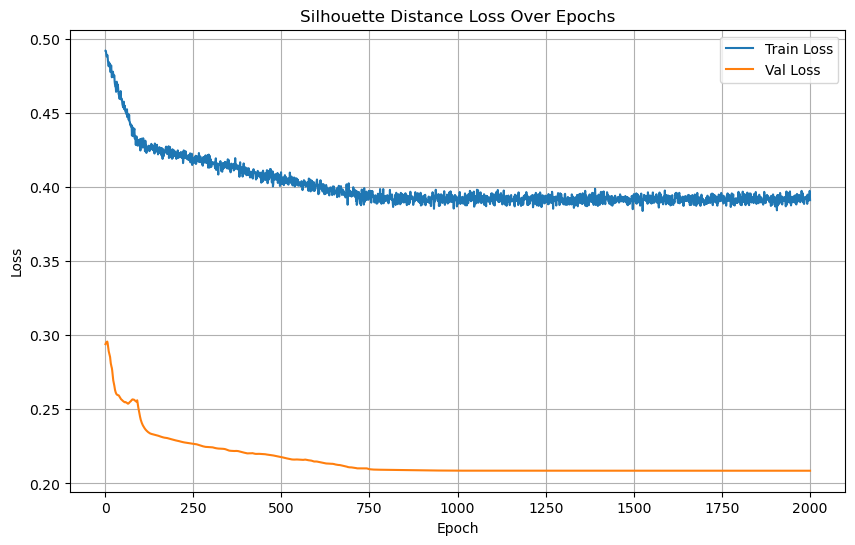

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/46], Loss: 0.3048


Test Batch [20/46], Loss: 0.2230
Test Batch [30/46], Loss: 0.3094
Test Batch [40/46], Loss: 0.2626

Test Loss: 0.2856


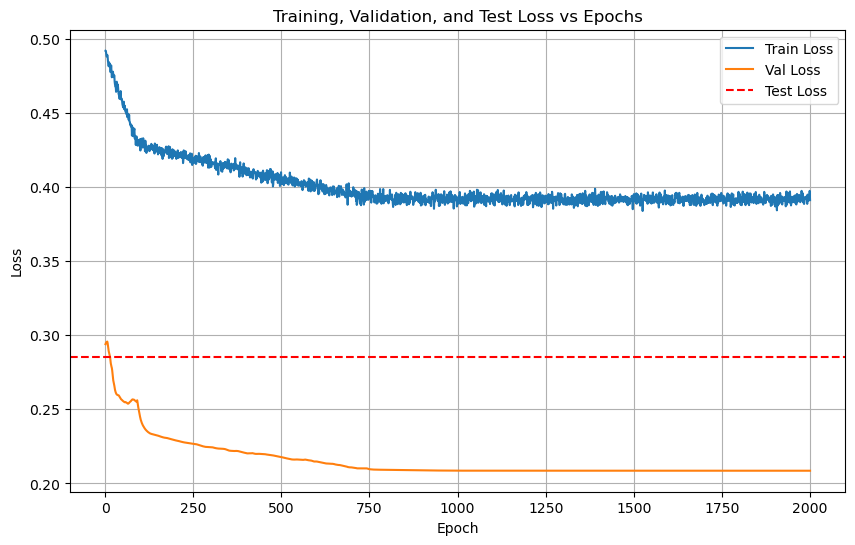

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/46 for test dataset.
  Processed batch 20/46 for test dataset.


  Processed batch 30/46 for test dataset.
  Processed batch 40/46 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 94.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       0.60      0.60      0.60         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.80      0.80      0.80         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7094  |  Val Loss: 2.6919
Validation loss improved from inf to 2.6919.
[Epoch 2/1000] Train Loss: 2.6819  |  Val Loss: 2.6667
Validation loss improved from 2.6919 to 2.6667.
[Epoch 3/1000] Train Loss: 2.6570  |  Val Loss: 2.6441
Validation loss improved from 2.6667 to 2.6441.
[Epoch 4/1000] Train Loss: 2.6347  |  Val Loss: 2.6218
Validation loss improved from 2.6441 to 2.6218.
[Epoch 5/1000] Train Loss: 2.6120  |  Val Loss: 2.6008
Validation loss improved from 2.6218 to 2.6008.
[Epoch 6/1000] Train Loss: 2.5912  |  Val Loss: 2.5796
Validation loss improved from 2.6008 to 2.5796.
[Epoch 7/1000] Train Loss: 2.5709  |  Val Loss: 2.5587
Validation loss improved from 2.5796 to 2.5587.
[Epoch 8/1000] Train Loss: 2.5504  |  Val Loss: 2.5380
Validation loss improved from 2.5587 to 2.5380.


[Epoch 9/1000] Train Loss: 2.5308  |  Val Loss: 2.5179
Validation loss improved from 2.5380 to 2.5179.
[Epoch 10/1000] Train Loss: 2.5119  |  Val Loss: 2.4982
Validation loss improved from 2.5179 to 2.4982.
[Epoch 11/1000] Train Loss: 2.4932  |  Val Loss: 2.4788
Validation loss improved from 2.4982 to 2.4788.
[Epoch 12/1000] Train Loss: 2.4741  |  Val Loss: 2.4596
Validation loss improved from 2.4788 to 2.4596.
[Epoch 13/1000] Train Loss: 2.4555  |  Val Loss: 2.4405
Validation loss improved from 2.4596 to 2.4405.
[Epoch 14/1000] Train Loss: 2.4370  |  Val Loss: 2.4212
Validation loss improved from 2.4405 to 2.4212.


[Epoch 15/1000] Train Loss: 2.4175  |  Val Loss: 2.4023
Validation loss improved from 2.4212 to 2.4023.
[Epoch 16/1000] Train Loss: 2.3986  |  Val Loss: 2.3836
Validation loss improved from 2.4023 to 2.3836.
[Epoch 17/1000] Train Loss: 2.3798  |  Val Loss: 2.3642
Validation loss improved from 2.3836 to 2.3642.
[Epoch 18/1000] Train Loss: 2.3600  |  Val Loss: 2.3443
Validation loss improved from 2.3642 to 2.3443.


[Epoch 19/1000] Train Loss: 2.3404  |  Val Loss: 2.3240
Validation loss improved from 2.3443 to 2.3240.
[Epoch 20/1000] Train Loss: 2.3199  |  Val Loss: 2.3033
Validation loss improved from 2.3240 to 2.3033.
[Epoch 21/1000] Train Loss: 2.2997  |  Val Loss: 2.2825
Validation loss improved from 2.3033 to 2.2825.
[Epoch 22/1000] Train Loss: 2.2789  |  Val Loss: 2.2620
Validation loss improved from 2.2825 to 2.2620.
[Epoch 23/1000] Train Loss: 2.2590  |  Val Loss: 2.2416
Validation loss improved from 2.2620 to 2.2416.
[Epoch 24/1000] Train Loss: 2.2383  |  Val Loss: 2.2214
Validation loss improved from 2.2416 to 2.2214.
[Epoch 25/1000] Train Loss: 2.2170  |  Val Loss: 2.2012
Validation loss improved from 2.2214 to 2.2012.
[Epoch 26/1000] Train Loss: 2.1968  |  Val Loss: 2.1806
Validation loss improved from 2.2012 to 2.1806.
[Epoch 27/1000] Train Loss: 2.1759  |  Val Loss: 2.1604
Validation loss improved from 2.1806 to 2.1604.


[Epoch 28/1000] Train Loss: 2.1548  |  Val Loss: 2.1403
Validation loss improved from 2.1604 to 2.1403.
[Epoch 29/1000] Train Loss: 2.1345  |  Val Loss: 2.1201
Validation loss improved from 2.1403 to 2.1201.
[Epoch 30/1000] Train Loss: 2.1141  |  Val Loss: 2.0998
Validation loss improved from 2.1201 to 2.0998.
[Epoch 31/1000] Train Loss: 2.0928  |  Val Loss: 2.0798
Validation loss improved from 2.0998 to 2.0798.
[Epoch 32/1000] Train Loss: 2.0722  |  Val Loss: 2.0603
Validation loss improved from 2.0798 to 2.0603.
[Epoch 33/1000] Train Loss: 2.0518  |  Val Loss: 2.0409
Validation loss improved from 2.0603 to 2.0409.
[Epoch 34/1000] Train Loss: 2.0317  |  Val Loss: 2.0215
Validation loss improved from 2.0409 to 2.0215.


[Epoch 35/1000] Train Loss: 2.0114  |  Val Loss: 2.0028
Validation loss improved from 2.0215 to 2.0028.
[Epoch 36/1000] Train Loss: 1.9916  |  Val Loss: 1.9845
Validation loss improved from 2.0028 to 1.9845.
[Epoch 37/1000] Train Loss: 1.9721  |  Val Loss: 1.9662
Validation loss improved from 1.9845 to 1.9662.
[Epoch 38/1000] Train Loss: 1.9528  |  Val Loss: 1.9480
Validation loss improved from 1.9662 to 1.9480.


[Epoch 39/1000] Train Loss: 1.9336  |  Val Loss: 1.9303
Validation loss improved from 1.9480 to 1.9303.
[Epoch 40/1000] Train Loss: 1.9152  |  Val Loss: 1.9123
Validation loss improved from 1.9303 to 1.9123.
[Epoch 41/1000] Train Loss: 1.8967  |  Val Loss: 1.8946
Validation loss improved from 1.9123 to 1.8946.
[Epoch 42/1000] Train Loss: 1.8780  |  Val Loss: 1.8773
Validation loss improved from 1.8946 to 1.8773.
[Epoch 43/1000] Train Loss: 1.8602  |  Val Loss: 1.8602
Validation loss improved from 1.8773 to 1.8602.
[Epoch 44/1000] Train Loss: 1.8424  |  Val Loss: 1.8431
Validation loss improved from 1.8602 to 1.8431.
[Epoch 45/1000] Train Loss: 1.8250  |  Val Loss: 1.8265
Validation loss improved from 1.8431 to 1.8265.
[Epoch 46/1000] Train Loss: 1.8073  |  Val Loss: 1.8099
Validation loss improved from 1.8265 to 1.8099.


[Epoch 47/1000] Train Loss: 1.7896  |  Val Loss: 1.7934
Validation loss improved from 1.8099 to 1.7934.
[Epoch 48/1000] Train Loss: 1.7724  |  Val Loss: 1.7770
Validation loss improved from 1.7934 to 1.7770.
[Epoch 49/1000] Train Loss: 1.7553  |  Val Loss: 1.7607
Validation loss improved from 1.7770 to 1.7607.
[Epoch 50/1000] Train Loss: 1.7379  |  Val Loss: 1.7447
Validation loss improved from 1.7607 to 1.7447.
[Epoch 51/1000] Train Loss: 1.7208  |  Val Loss: 1.7289
Validation loss improved from 1.7447 to 1.7289.
[Epoch 52/1000] Train Loss: 1.7039  |  Val Loss: 1.7129
Validation loss improved from 1.7289 to 1.7129.


[Epoch 53/1000] Train Loss: 1.6873  |  Val Loss: 1.6967
Validation loss improved from 1.7129 to 1.6967.
[Epoch 54/1000] Train Loss: 1.6701  |  Val Loss: 1.6811
Validation loss improved from 1.6967 to 1.6811.
[Epoch 55/1000] Train Loss: 1.6535  |  Val Loss: 1.6655
Validation loss improved from 1.6811 to 1.6655.
[Epoch 56/1000] Train Loss: 1.6369  |  Val Loss: 1.6499
Validation loss improved from 1.6655 to 1.6499.
[Epoch 57/1000] Train Loss: 1.6204  |  Val Loss: 1.6343
Validation loss improved from 1.6499 to 1.6343.


[Epoch 58/1000] Train Loss: 1.6034  |  Val Loss: 1.6186
Validation loss improved from 1.6343 to 1.6186.
[Epoch 59/1000] Train Loss: 1.5870  |  Val Loss: 1.6030
Validation loss improved from 1.6186 to 1.6030.
[Epoch 60/1000] Train Loss: 1.5704  |  Val Loss: 1.5874
Validation loss improved from 1.6030 to 1.5874.
[Epoch 61/1000] Train Loss: 1.5546  |  Val Loss: 1.5717
Validation loss improved from 1.5874 to 1.5717.
[Epoch 62/1000] Train Loss: 1.5379  |  Val Loss: 1.5563
Validation loss improved from 1.5717 to 1.5563.
[Epoch 63/1000] Train Loss: 1.5211  |  Val Loss: 1.5414
Validation loss improved from 1.5563 to 1.5414.
[Epoch 64/1000] Train Loss: 1.5047  |  Val Loss: 1.5263
Validation loss improved from 1.5414 to 1.5263.
[Epoch 65/1000] Train Loss: 1.4881  |  Val Loss: 1.5109
Validation loss improved from 1.5263 to 1.5109.


[Epoch 66/1000] Train Loss: 1.4716  |  Val Loss: 1.4954
Validation loss improved from 1.5109 to 1.4954.
[Epoch 67/1000] Train Loss: 1.4547  |  Val Loss: 1.4797
Validation loss improved from 1.4954 to 1.4797.
[Epoch 68/1000] Train Loss: 1.4378  |  Val Loss: 1.4635
Validation loss improved from 1.4797 to 1.4635.
[Epoch 69/1000] Train Loss: 1.4206  |  Val Loss: 1.4471
Validation loss improved from 1.4635 to 1.4471.
[Epoch 70/1000] Train Loss: 1.4033  |  Val Loss: 1.4303
Validation loss improved from 1.4471 to 1.4303.


[Epoch 71/1000] Train Loss: 1.3858  |  Val Loss: 1.4134
Validation loss improved from 1.4303 to 1.4134.
[Epoch 72/1000] Train Loss: 1.3684  |  Val Loss: 1.3961
Validation loss improved from 1.4134 to 1.3961.
[Epoch 73/1000] Train Loss: 1.3506  |  Val Loss: 1.3791
Validation loss improved from 1.3961 to 1.3791.
[Epoch 74/1000] Train Loss: 1.3332  |  Val Loss: 1.3619
Validation loss improved from 1.3791 to 1.3619.


[Epoch 75/1000] Train Loss: 1.3155  |  Val Loss: 1.3445
Validation loss improved from 1.3619 to 1.3445.
[Epoch 76/1000] Train Loss: 1.2982  |  Val Loss: 1.3274
Validation loss improved from 1.3445 to 1.3274.
[Epoch 77/1000] Train Loss: 1.2804  |  Val Loss: 1.3100
Validation loss improved from 1.3274 to 1.3100.
[Epoch 78/1000] Train Loss: 1.2633  |  Val Loss: 1.2926
Validation loss improved from 1.3100 to 1.2926.
[Epoch 79/1000] Train Loss: 1.2456  |  Val Loss: 1.2751
Validation loss improved from 1.2926 to 1.2751.
[Epoch 80/1000] Train Loss: 1.2280  |  Val Loss: 1.2578
Validation loss improved from 1.2751 to 1.2578.
[Epoch 81/1000] Train Loss: 1.2104  |  Val Loss: 1.2408
Validation loss improved from 1.2578 to 1.2408.
[Epoch 82/1000] Train Loss: 1.1931  |  Val Loss: 1.2239
Validation loss improved from 1.2408 to 1.2239.
[Epoch 83/1000] Train Loss: 1.1754  |  Val Loss: 1.2068
Validation loss improved from 1.2239 to 1.2068.
[Epoch 84/1000] Train Loss: 1.1581  |  Val Loss: 1.1899
Validati

[Epoch 85/1000] Train Loss: 1.1413  |  Val Loss: 1.1727
Validation loss improved from 1.1899 to 1.1727.
[Epoch 86/1000] Train Loss: 1.1240  |  Val Loss: 1.1563
Validation loss improved from 1.1727 to 1.1563.
[Epoch 87/1000] Train Loss: 1.1068  |  Val Loss: 1.1397
Validation loss improved from 1.1563 to 1.1397.
[Epoch 88/1000] Train Loss: 1.0904  |  Val Loss: 1.1225
Validation loss improved from 1.1397 to 1.1225.
[Epoch 89/1000] Train Loss: 1.0732  |  Val Loss: 1.1058
Validation loss improved from 1.1225 to 1.1058.


[Epoch 90/1000] Train Loss: 1.0569  |  Val Loss: 1.0891
Validation loss improved from 1.1058 to 1.0891.
[Epoch 91/1000] Train Loss: 1.0403  |  Val Loss: 1.0725
Validation loss improved from 1.0891 to 1.0725.
[Epoch 92/1000] Train Loss: 1.0241  |  Val Loss: 1.0563
Validation loss improved from 1.0725 to 1.0563.
[Epoch 93/1000] Train Loss: 1.0080  |  Val Loss: 1.0400
Validation loss improved from 1.0563 to 1.0400.


[Epoch 94/1000] Train Loss: 0.9923  |  Val Loss: 1.0241
Validation loss improved from 1.0400 to 1.0241.
[Epoch 95/1000] Train Loss: 0.9768  |  Val Loss: 1.0081
Validation loss improved from 1.0241 to 1.0081.
[Epoch 96/1000] Train Loss: 0.9617  |  Val Loss: 0.9927
Validation loss improved from 1.0081 to 0.9927.
[Epoch 97/1000] Train Loss: 0.9454  |  Val Loss: 0.9780
Validation loss improved from 0.9927 to 0.9780.
[Epoch 98/1000] Train Loss: 0.9311  |  Val Loss: 0.9632
Validation loss improved from 0.9780 to 0.9632.
[Epoch 99/1000] Train Loss: 0.9160  |  Val Loss: 0.9486
Validation loss improved from 0.9632 to 0.9486.
[Epoch 100/1000] Train Loss: 0.9017  |  Val Loss: 0.9341
Validation loss improved from 0.9486 to 0.9341.
[Epoch 101/1000] Train Loss: 0.8868  |  Val Loss: 0.9203
Validation loss improved from 0.9341 to 0.9203.
[Epoch 102/1000] Train Loss: 0.8729  |  Val Loss: 0.9067
Validation loss improved from 0.9203 to 0.9067.


[Epoch 103/1000] Train Loss: 0.8589  |  Val Loss: 0.8928
Validation loss improved from 0.9067 to 0.8928.
[Epoch 104/1000] Train Loss: 0.8450  |  Val Loss: 0.8788
Validation loss improved from 0.8928 to 0.8788.
[Epoch 105/1000] Train Loss: 0.8316  |  Val Loss: 0.8653
Validation loss improved from 0.8788 to 0.8653.
[Epoch 106/1000] Train Loss: 0.8182  |  Val Loss: 0.8524
Validation loss improved from 0.8653 to 0.8524.
[Epoch 107/1000] Train Loss: 0.8051  |  Val Loss: 0.8397
Validation loss improved from 0.8524 to 0.8397.


[Epoch 108/1000] Train Loss: 0.7923  |  Val Loss: 0.8272
Validation loss improved from 0.8397 to 0.8272.
[Epoch 109/1000] Train Loss: 0.7798  |  Val Loss: 0.8149
Validation loss improved from 0.8272 to 0.8149.
[Epoch 110/1000] Train Loss: 0.7674  |  Val Loss: 0.8031
Validation loss improved from 0.8149 to 0.8031.
[Epoch 111/1000] Train Loss: 0.7553  |  Val Loss: 0.7914
Validation loss improved from 0.8031 to 0.7914.
[Epoch 112/1000] Train Loss: 0.7435  |  Val Loss: 0.7799
Validation loss improved from 0.7914 to 0.7799.


[Epoch 113/1000] Train Loss: 0.7316  |  Val Loss: 0.7691
Validation loss improved from 0.7799 to 0.7691.
[Epoch 114/1000] Train Loss: 0.7201  |  Val Loss: 0.7584
Validation loss improved from 0.7691 to 0.7584.
[Epoch 115/1000] Train Loss: 0.7088  |  Val Loss: 0.7479
Validation loss improved from 0.7584 to 0.7479.
[Epoch 116/1000] Train Loss: 0.6977  |  Val Loss: 0.7372
Validation loss improved from 0.7479 to 0.7372.
[Epoch 117/1000] Train Loss: 0.6867  |  Val Loss: 0.7267
Validation loss improved from 0.7372 to 0.7267.
[Epoch 118/1000] Train Loss: 0.6764  |  Val Loss: 0.7163
Validation loss improved from 0.7267 to 0.7163.
[Epoch 119/1000] Train Loss: 0.6659  |  Val Loss: 0.7058
Validation loss improved from 0.7163 to 0.7058.
[Epoch 120/1000] Train Loss: 0.6553  |  Val Loss: 0.6957
Validation loss improved from 0.7058 to 0.6957.
[Epoch 121/1000] Train Loss: 0.6452  |  Val Loss: 0.6854
Validation loss improved from 0.6957 to 0.6854.


[Epoch 122/1000] Train Loss: 0.6352  |  Val Loss: 0.6755
Validation loss improved from 0.6854 to 0.6755.
[Epoch 123/1000] Train Loss: 0.6253  |  Val Loss: 0.6660
Validation loss improved from 0.6755 to 0.6660.
[Epoch 124/1000] Train Loss: 0.6159  |  Val Loss: 0.6567
Validation loss improved from 0.6660 to 0.6567.
[Epoch 125/1000] Train Loss: 0.6061  |  Val Loss: 0.6478
Validation loss improved from 0.6567 to 0.6478.


[Epoch 126/1000] Train Loss: 0.5970  |  Val Loss: 0.6391
Validation loss improved from 0.6478 to 0.6391.
[Epoch 127/1000] Train Loss: 0.5881  |  Val Loss: 0.6301
Validation loss improved from 0.6391 to 0.6301.
[Epoch 128/1000] Train Loss: 0.5794  |  Val Loss: 0.6214
Validation loss improved from 0.6301 to 0.6214.


[Epoch 129/1000] Train Loss: 0.5706  |  Val Loss: 0.6130
Validation loss improved from 0.6214 to 0.6130.
[Epoch 130/1000] Train Loss: 0.5622  |  Val Loss: 0.6047
Validation loss improved from 0.6130 to 0.6047.
[Epoch 131/1000] Train Loss: 0.5539  |  Val Loss: 0.5971
Validation loss improved from 0.6047 to 0.5971.
[Epoch 132/1000] Train Loss: 0.5457  |  Val Loss: 0.5899
Validation loss improved from 0.5971 to 0.5899.
[Epoch 133/1000] Train Loss: 0.5378  |  Val Loss: 0.5826
Validation loss improved from 0.5899 to 0.5826.
[Epoch 134/1000] Train Loss: 0.5299  |  Val Loss: 0.5751
Validation loss improved from 0.5826 to 0.5751.
[Epoch 135/1000] Train Loss: 0.5221  |  Val Loss: 0.5674
Validation loss improved from 0.5751 to 0.5674.
[Epoch 136/1000] Train Loss: 0.5146  |  Val Loss: 0.5600
Validation loss improved from 0.5674 to 0.5600.
[Epoch 137/1000] Train Loss: 0.5069  |  Val Loss: 0.5533
Validation loss improved from 0.5600 to 0.5533.
[Epoch 138/1000] Train Loss: 0.4995  |  Val Loss: 0.546

[Epoch 140/1000] Train Loss: 0.4846  |  Val Loss: 0.5317
Validation loss improved from 0.5390 to 0.5317.
[Epoch 141/1000] Train Loss: 0.4776  |  Val Loss: 0.5248
Validation loss improved from 0.5317 to 0.5248.
[Epoch 142/1000] Train Loss: 0.4704  |  Val Loss: 0.5181
Validation loss improved from 0.5248 to 0.5181.
[Epoch 143/1000] Train Loss: 0.4634  |  Val Loss: 0.5118
Validation loss improved from 0.5181 to 0.5118.
[Epoch 144/1000] Train Loss: 0.4567  |  Val Loss: 0.5059
Validation loss improved from 0.5118 to 0.5059.


[Epoch 145/1000] Train Loss: 0.4501  |  Val Loss: 0.4999
Validation loss improved from 0.5059 to 0.4999.
[Epoch 146/1000] Train Loss: 0.4435  |  Val Loss: 0.4938
Validation loss improved from 0.4999 to 0.4938.
[Epoch 147/1000] Train Loss: 0.4371  |  Val Loss: 0.4873
Validation loss improved from 0.4938 to 0.4873.
[Epoch 148/1000] Train Loss: 0.4307  |  Val Loss: 0.4813
Validation loss improved from 0.4873 to 0.4813.
[Epoch 149/1000] Train Loss: 0.4244  |  Val Loss: 0.4751
Validation loss improved from 0.4813 to 0.4751.
[Epoch 150/1000] Train Loss: 0.4183  |  Val Loss: 0.4691
Validation loss improved from 0.4751 to 0.4691.
[Epoch 151/1000] Train Loss: 0.4125  |  Val Loss: 0.4632
Validation loss improved from 0.4691 to 0.4632.
[Epoch 152/1000] Train Loss: 0.4065  |  Val Loss: 0.4579
Validation loss improved from 0.4632 to 0.4579.
[Epoch 153/1000] Train Loss: 0.4006  |  Val Loss: 0.4520
Validation loss improved from 0.4579 to 0.4520.
[Epoch 154/1000] Train Loss: 0.3953  |  Val Loss: 0.446

[Epoch 159/1000] Train Loss: 0.3692  |  Val Loss: 0.4238
Validation loss improved from 0.4275 to 0.4238.
[Epoch 160/1000] Train Loss: 0.3643  |  Val Loss: 0.4199
Validation loss improved from 0.4238 to 0.4199.
[Epoch 161/1000] Train Loss: 0.3595  |  Val Loss: 0.4159
Validation loss improved from 0.4199 to 0.4159.
[Epoch 162/1000] Train Loss: 0.3549  |  Val Loss: 0.4115
Validation loss improved from 0.4159 to 0.4115.
[Epoch 163/1000] Train Loss: 0.3502  |  Val Loss: 0.4075
Validation loss improved from 0.4115 to 0.4075.


[Epoch 164/1000] Train Loss: 0.3458  |  Val Loss: 0.4033
Validation loss improved from 0.4075 to 0.4033.
[Epoch 165/1000] Train Loss: 0.3413  |  Val Loss: 0.3996
Validation loss improved from 0.4033 to 0.3996.
[Epoch 166/1000] Train Loss: 0.3370  |  Val Loss: 0.3953
Validation loss improved from 0.3996 to 0.3953.
[Epoch 167/1000] Train Loss: 0.3329  |  Val Loss: 0.3913
Validation loss improved from 0.3953 to 0.3913.
[Epoch 168/1000] Train Loss: 0.3289  |  Val Loss: 0.3877
Validation loss improved from 0.3913 to 0.3877.
[Epoch 169/1000] Train Loss: 0.3247  |  Val Loss: 0.3834
Validation loss improved from 0.3877 to 0.3834.
[Epoch 170/1000] Train Loss: 0.3209  |  Val Loss: 0.3799
Validation loss improved from 0.3834 to 0.3799.
[Epoch 171/1000] Train Loss: 0.3169  |  Val Loss: 0.3768
Validation loss improved from 0.3799 to 0.3768.
[Epoch 172/1000] Train Loss: 0.3130  |  Val Loss: 0.3737
Validation loss improved from 0.3768 to 0.3737.
[Epoch 173/1000] Train Loss: 0.3095  |  Val Loss: 0.370

[Epoch 178/1000] Train Loss: 0.2921  |  Val Loss: 0.3563
Validation loss improved from 0.3589 to 0.3563.
[Epoch 179/1000] Train Loss: 0.2886  |  Val Loss: 0.3534
Validation loss improved from 0.3563 to 0.3534.
[Epoch 180/1000] Train Loss: 0.2857  |  Val Loss: 0.3504
Validation loss improved from 0.3534 to 0.3504.
[Epoch 181/1000] Train Loss: 0.2826  |  Val Loss: 0.3477
Validation loss improved from 0.3504 to 0.3477.
[Epoch 182/1000] Train Loss: 0.2792  |  Val Loss: 0.3453
Validation loss improved from 0.3477 to 0.3453.


[Epoch 183/1000] Train Loss: 0.2767  |  Val Loss: 0.3427
Validation loss improved from 0.3453 to 0.3427.
[Epoch 184/1000] Train Loss: 0.2734  |  Val Loss: 0.3405
Validation loss improved from 0.3427 to 0.3405.
[Epoch 185/1000] Train Loss: 0.2705  |  Val Loss: 0.3380
Validation loss improved from 0.3405 to 0.3380.
[Epoch 186/1000] Train Loss: 0.2675  |  Val Loss: 0.3359
Validation loss improved from 0.3380 to 0.3359.
[Epoch 187/1000] Train Loss: 0.2651  |  Val Loss: 0.3336
Validation loss improved from 0.3359 to 0.3336.
[Epoch 188/1000] Train Loss: 0.2622  |  Val Loss: 0.3312
Validation loss improved from 0.3336 to 0.3312.
[Epoch 189/1000] Train Loss: 0.2594  |  Val Loss: 0.3288
Validation loss improved from 0.3312 to 0.3288.
[Epoch 190/1000] Train Loss: 0.2567  |  Val Loss: 0.3267
Validation loss improved from 0.3288 to 0.3267.
[Epoch 191/1000] Train Loss: 0.2541  |  Val Loss: 0.3243
Validation loss improved from 0.3267 to 0.3243.
[Epoch 192/1000] Train Loss: 0.2517  |  Val Loss: 0.322

[Epoch 197/1000] Train Loss: 0.2401  |  Val Loss: 0.3131
Validation loss improved from 0.3146 to 0.3131.
[Epoch 198/1000] Train Loss: 0.2374  |  Val Loss: 0.3112
Validation loss improved from 0.3131 to 0.3112.
[Epoch 199/1000] Train Loss: 0.2353  |  Val Loss: 0.3096
Validation loss improved from 0.3112 to 0.3096.
[Epoch 200/1000] Train Loss: 0.2330  |  Val Loss: 0.3078
Validation loss improved from 0.3096 to 0.3078.
[Epoch 201/1000] Train Loss: 0.2309  |  Val Loss: 0.3066
Validation loss improved from 0.3078 to 0.3066.


[Epoch 202/1000] Train Loss: 0.2289  |  Val Loss: 0.3050
Validation loss improved from 0.3066 to 0.3050.
[Epoch 203/1000] Train Loss: 0.2267  |  Val Loss: 0.3039
Validation loss improved from 0.3050 to 0.3039.
[Epoch 204/1000] Train Loss: 0.2247  |  Val Loss: 0.3025
Validation loss improved from 0.3039 to 0.3025.
[Epoch 205/1000] Train Loss: 0.2227  |  Val Loss: 0.3007
Validation loss improved from 0.3025 to 0.3007.
[Epoch 206/1000] Train Loss: 0.2207  |  Val Loss: 0.2996
Validation loss improved from 0.3007 to 0.2996.
[Epoch 207/1000] Train Loss: 0.2189  |  Val Loss: 0.2983
Validation loss improved from 0.2996 to 0.2983.
[Epoch 208/1000] Train Loss: 0.2169  |  Val Loss: 0.2962
Validation loss improved from 0.2983 to 0.2962.
[Epoch 209/1000] Train Loss: 0.2151  |  Val Loss: 0.2945
Validation loss improved from 0.2962 to 0.2945.
[Epoch 210/1000] Train Loss: 0.2132  |  Val Loss: 0.2925
Validation loss improved from 0.2945 to 0.2925.
[Epoch 211/1000] Train Loss: 0.2112  |  Val Loss: 0.291

[Epoch 217/1000] Train Loss: 0.2011  |  Val Loss: 0.2826
Validation loss improved from 0.2837 to 0.2826.
[Epoch 218/1000] Train Loss: 0.1993  |  Val Loss: 0.2816
Validation loss improved from 0.2826 to 0.2816.
[Epoch 219/1000] Train Loss: 0.1977  |  Val Loss: 0.2808
Validation loss improved from 0.2816 to 0.2808.
[Epoch 220/1000] Train Loss: 0.1960  |  Val Loss: 0.2797
Validation loss improved from 0.2808 to 0.2797.


[Epoch 221/1000] Train Loss: 0.1943  |  Val Loss: 0.2788
Validation loss improved from 0.2797 to 0.2788.
[Epoch 222/1000] Train Loss: 0.1926  |  Val Loss: 0.2780
Validation loss improved from 0.2788 to 0.2780.
[Epoch 223/1000] Train Loss: 0.1912  |  Val Loss: 0.2768
Validation loss improved from 0.2780 to 0.2768.
[Epoch 224/1000] Train Loss: 0.1896  |  Val Loss: 0.2755
Validation loss improved from 0.2768 to 0.2755.
[Epoch 225/1000] Train Loss: 0.1878  |  Val Loss: 0.2742
Validation loss improved from 0.2755 to 0.2742.
[Epoch 226/1000] Train Loss: 0.1863  |  Val Loss: 0.2733
Validation loss improved from 0.2742 to 0.2733.
[Epoch 227/1000] Train Loss: 0.1849  |  Val Loss: 0.2720
Validation loss improved from 0.2733 to 0.2720.
[Epoch 228/1000] Train Loss: 0.1833  |  Val Loss: 0.2716
Validation loss improved from 0.2720 to 0.2716.
[Epoch 229/1000] Train Loss: 0.1819  |  Val Loss: 0.2708
Validation loss improved from 0.2716 to 0.2708.
[Epoch 230/1000] Train Loss: 0.1805  |  Val Loss: 0.269

[Epoch 235/1000] Train Loss: 0.1737  |  Val Loss: 0.2652
Validation loss improved from 0.2665 to 0.2652.
[Epoch 236/1000] Train Loss: 0.1723  |  Val Loss: 0.2642
Validation loss improved from 0.2652 to 0.2642.
[Epoch 237/1000] Train Loss: 0.1712  |  Val Loss: 0.2632
Validation loss improved from 0.2642 to 0.2632.


[Epoch 238/1000] Train Loss: 0.1696  |  Val Loss: 0.2623
Validation loss improved from 0.2632 to 0.2623.
[Epoch 239/1000] Train Loss: 0.1686  |  Val Loss: 0.2617
Validation loss improved from 0.2623 to 0.2617.
[Epoch 240/1000] Train Loss: 0.1675  |  Val Loss: 0.2609
Validation loss improved from 0.2617 to 0.2609.
[Epoch 241/1000] Train Loss: 0.1663  |  Val Loss: 0.2602
Validation loss improved from 0.2609 to 0.2602.
[Epoch 242/1000] Train Loss: 0.1651  |  Val Loss: 0.2597
Validation loss improved from 0.2602 to 0.2597.
[Epoch 243/1000] Train Loss: 0.1639  |  Val Loss: 0.2586
Validation loss improved from 0.2597 to 0.2586.
[Epoch 244/1000] Train Loss: 0.1627  |  Val Loss: 0.2575
Validation loss improved from 0.2586 to 0.2575.
[Epoch 245/1000] Train Loss: 0.1616  |  Val Loss: 0.2566
Validation loss improved from 0.2575 to 0.2566.
[Epoch 246/1000] Train Loss: 0.1603  |  Val Loss: 0.2566
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 247/1000] Train Loss: 0.1593  |  Val Loss:

[Epoch 253/1000] Train Loss: 0.1523  |  Val Loss: 0.2522
Validation loss improved from 0.2529 to 0.2522.
[Epoch 254/1000] Train Loss: 0.1513  |  Val Loss: 0.2518
Validation loss improved from 0.2522 to 0.2518.
[Epoch 255/1000] Train Loss: 0.1503  |  Val Loss: 0.2509
Validation loss improved from 0.2518 to 0.2509.
[Epoch 256/1000] Train Loss: 0.1493  |  Val Loss: 0.2497
Validation loss improved from 0.2509 to 0.2497.
[Epoch 257/1000] Train Loss: 0.1481  |  Val Loss: 0.2494
Validation loss improved from 0.2497 to 0.2494.


[Epoch 258/1000] Train Loss: 0.1472  |  Val Loss: 0.2489
Validation loss improved from 0.2494 to 0.2489.
[Epoch 259/1000] Train Loss: 0.1461  |  Val Loss: 0.2486
Validation loss improved from 0.2489 to 0.2486.
[Epoch 260/1000] Train Loss: 0.1451  |  Val Loss: 0.2478
Validation loss improved from 0.2486 to 0.2478.
[Epoch 261/1000] Train Loss: 0.1442  |  Val Loss: 0.2474
Validation loss improved from 0.2478 to 0.2474.
[Epoch 262/1000] Train Loss: 0.1431  |  Val Loss: 0.2473
Validation loss improved from 0.2474 to 0.2473.
[Epoch 263/1000] Train Loss: 0.1424  |  Val Loss: 0.2474
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.1413  |  Val Loss: 0.2474
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 0.1404  |  Val Loss: 0.2466
Validation loss improved from 0.2473 to 0.2466.
[Epoch 266/1000] Train Loss: 0.1394  |  Val Loss: 0.2461
Validation loss improved from 0.2466 to 0.2461.
[Epoch 267/1000] Train Loss: 0.1387  |  Val

[Epoch 272/1000] Train Loss: 0.1341  |  Val Loss: 0.2407
Validation loss improved from 0.2414 to 0.2407.
[Epoch 273/1000] Train Loss: 0.1332  |  Val Loss: 0.2404
Validation loss improved from 0.2407 to 0.2404.
[Epoch 274/1000] Train Loss: 0.1324  |  Val Loss: 0.2397
Validation loss improved from 0.2404 to 0.2397.
[Epoch 275/1000] Train Loss: 0.1315  |  Val Loss: 0.2390
Validation loss improved from 0.2397 to 0.2390.
[Epoch 276/1000] Train Loss: 0.1311  |  Val Loss: 0.2386
Validation loss improved from 0.2390 to 0.2386.


[Epoch 277/1000] Train Loss: 0.1298  |  Val Loss: 0.2380
Validation loss improved from 0.2386 to 0.2380.
[Epoch 278/1000] Train Loss: 0.1290  |  Val Loss: 0.2378
Validation loss improved from 0.2380 to 0.2378.
[Epoch 279/1000] Train Loss: 0.1282  |  Val Loss: 0.2375
Validation loss improved from 0.2378 to 0.2375.
[Epoch 280/1000] Train Loss: 0.1276  |  Val Loss: 0.2373
Validation loss improved from 0.2375 to 0.2373.
[Epoch 281/1000] Train Loss: 0.1267  |  Val Loss: 0.2365
Validation loss improved from 0.2373 to 0.2365.
[Epoch 282/1000] Train Loss: 0.1260  |  Val Loss: 0.2358
Validation loss improved from 0.2365 to 0.2358.
[Epoch 283/1000] Train Loss: 0.1251  |  Val Loss: 0.2353
Validation loss improved from 0.2358 to 0.2353.
[Epoch 284/1000] Train Loss: 0.1245  |  Val Loss: 0.2351
Validation loss improved from 0.2353 to 0.2351.
[Epoch 285/1000] Train Loss: 0.1236  |  Val Loss: 0.2350
Validation loss improved from 0.2351 to 0.2350.
[Epoch 286/1000] Train Loss: 0.1230  |  Val Loss: 0.235

[Epoch 290/1000] Train Loss: 0.1196  |  Val Loss: 0.2345
Validation loss improved from 0.2347 to 0.2345.
[Epoch 291/1000] Train Loss: 0.1190  |  Val Loss: 0.2338
Validation loss improved from 0.2345 to 0.2338.
[Epoch 292/1000] Train Loss: 0.1182  |  Val Loss: 0.2334
Validation loss improved from 0.2338 to 0.2334.
[Epoch 293/1000] Train Loss: 0.1175  |  Val Loss: 0.2329
Validation loss improved from 0.2334 to 0.2329.
[Epoch 294/1000] Train Loss: 0.1168  |  Val Loss: 0.2329
Validation loss improved from 0.2329 to 0.2329.
[Epoch 295/1000] Train Loss: 0.1161  |  Val Loss: 0.2324
Validation loss improved from 0.2329 to 0.2324.


[Epoch 296/1000] Train Loss: 0.1153  |  Val Loss: 0.2317
Validation loss improved from 0.2324 to 0.2317.
[Epoch 297/1000] Train Loss: 0.1147  |  Val Loss: 0.2317
Validation loss improved from 0.2317 to 0.2317.
[Epoch 298/1000] Train Loss: 0.1139  |  Val Loss: 0.2308
Validation loss improved from 0.2317 to 0.2308.
[Epoch 299/1000] Train Loss: 0.1131  |  Val Loss: 0.2306
Validation loss improved from 0.2308 to 0.2306.
[Epoch 300/1000] Train Loss: 0.1125  |  Val Loss: 0.2303
Validation loss improved from 0.2306 to 0.2303.
[Epoch 301/1000] Train Loss: 0.1118  |  Val Loss: 0.2290
Validation loss improved from 0.2303 to 0.2290.
[Epoch 302/1000] Train Loss: 0.1114  |  Val Loss: 0.2277
Validation loss improved from 0.2290 to 0.2277.
[Epoch 303/1000] Train Loss: 0.1109  |  Val Loss: 0.2267
Validation loss improved from 0.2277 to 0.2267.
[Epoch 304/1000] Train Loss: 0.1102  |  Val Loss: 0.2264
Validation loss improved from 0.2267 to 0.2264.
[Epoch 305/1000] Train Loss: 0.1094  |  Val Loss: 0.225

[Epoch 310/1000] Train Loss: 0.1064  |  Val Loss: 0.2268
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 311/1000] Train Loss: 0.1055  |  Val Loss: 0.2270
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 312/1000] Train Loss: 0.1050  |  Val Loss: 0.2275
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 313/1000] Train Loss: 0.1044  |  Val Loss: 0.2278
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 314/1000] Train Loss: 0.1039  |  Val Loss: 0.2271
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 315/1000] Train Loss: 0.1033  |  Val Loss: 0.2265
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 316/1000] Train Loss: 0.1028  |  Val Loss: 0.2263
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 317/1000] Train Loss: 0.1021  |  Val Loss: 0.2264
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 318/1000] Train Loss: 0.1016  |  Val Loss: 0.2259
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 319/1000] Train Loss: 0.1009  |  Val Loss: 0.2256
Validation loss improved from 0.2258 to 0.2256.
[Epoch 320/1000] Train Loss: 0.1004  |  Val Loss: 0.2254
Validation loss improved from 0.2256 to 0.2254.
[Epoch 321/1000] Train Loss: 0.0999  |  Val Loss: 0.2246
Validation loss improved from 0.2254 to 0.2246.
[Epoch 322/1000] Train Loss: 0.0993  |  Val Loss: 0.2242
Validation loss improved from 0.2246 to 0.2242.
[Epoch 323/1000] Train Loss: 0.0989  |  Val Loss: 0.2243
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 324/1000] Trai

[Epoch 329/1000] Train Loss: 0.0957  |  Val Loss: 0.2254
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 330/1000] Train Loss: 0.0952  |  Val Loss: 0.2246
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 331/1000] Train Loss: 0.0945  |  Val Loss: 0.2248
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 332/1000] Train Loss: 0.0940  |  Val Loss: 0.2250
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 333/1000] Train Loss: 0.0936  |  Val Loss: 0.2252
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 334/1000] Train Loss: 0.0930  |  Val Loss: 0.2252
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 335/1000] Train Loss: 0.0925  |  Val Loss: 0.2244
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 336/1000] Train Loss: 0.0919  |  Val Loss: 0.2238
Validation loss improved from 0.2242 to 0.2238.
[Epoch 337/1000] Train Loss: 0.0916  |  Val Loss: 0.2230
Validation loss improved from 0.2238 to 0.2230.
[Epoch 338/1000] Train Loss: 0.0909  |  Val Loss: 0.2230
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 339/1000] Train Loss: 0.0906  |  Val Loss: 0.2233
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 340/1000] Train Loss: 0.0902  |  Val Loss: 0.2232
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 341/1000] Train Loss: 0.0896  |  Val Loss: 0.2227
Validation loss improved from 0.2230 to 0.2227.
[Epoch 342/1000] Train Loss: 0.0890  |  Val Loss: 0.2225
Validation loss improved from 0.2227 to 0.2225.
[Epoch 343/1000] Train Loss: 0.0886  |  Val Loss: 0.2219
Validation loss improved from 0.2225 to 0.2219.
[Epoch 344/1000] Train Loss: 0

[Epoch 348/1000] Train Loss: 0.0864  |  Val Loss: 0.2193
Validation loss improved from 0.2195 to 0.2193.
[Epoch 349/1000] Train Loss: 0.0857  |  Val Loss: 0.2194
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 350/1000] Train Loss: 0.0853  |  Val Loss: 0.2199
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 351/1000] Train Loss: 0.0849  |  Val Loss: 0.2203
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 352/1000] Train Loss: 0.0845  |  Val Loss: 0.2212
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 353/1000] Train Loss: 0.0841  |  Val Loss: 0.2215
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 354/1000] Train Loss: 0.0836  |  Val Loss: 0.2214
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 355/1000] Train Loss: 0.0832  |  Val Loss: 0.2207
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 356/1000] Train Loss: 0.0828  |  Val Loss: 0.2200
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 357/1000] Train Loss: 0.0823  |  Val Loss: 0.2201
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 358/1000] Train Loss: 0.0819  |  Val Loss: 0.2203
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 359/1000] Train Loss: 0.0815  |  Val Loss: 0.2205
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 360/1000] Train Loss: 0.0811  |  Val Loss: 0.2202
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 361/1000] Train Loss: 0.0805  |  Val Loss: 0.2198
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 362/1000] Train Loss: 0.0801  |  Val Loss: 0.2190
Validation loss improved from 0.2193 to 0.2190.
[Ep

[Epoch 367/1000] Train Loss: 0.0784  |  Val Loss: 0.2177
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 368/1000] Train Loss: 0.0778  |  Val Loss: 0.2183
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 369/1000] Train Loss: 0.0773  |  Val Loss: 0.2185
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 370/1000] Train Loss: 0.0770  |  Val Loss: 0.2190
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 371/1000] Train Loss: 0.0766  |  Val Loss: 0.2187
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 372/1000] Train Loss: 0.0762  |  Val Loss: 0.2184
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 373/1000] Train Loss: 0.0758  |  Val Loss: 0.2181
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 374/1000] Train Loss: 0.0754  |  Val Loss: 0.2181
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 375/1000] Train Loss: 0.0752  |  Val Loss: 0.2172
Validation loss improved from 0.2176 to 0.2172.
[Epoch 376/1000] Train Loss: 0.0746  |  Val Loss: 0.2165
Validation loss improved from 0.2172 to 0.2165.
[Epoch 377/1000] Train Loss: 0.0743  |  Val Loss: 0.2167
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 378/1000] Train Loss: 0.0741  |  Val Loss: 0.2162
Validation loss improved from 0.2165 to 0.2162.
[Epoch 379/1000] Train Loss: 0.0736  |  Val Loss: 0.2162
Validation loss improved from 0.2162 to 0.2162.
[Epoch 380/1000] Train Loss: 0.0733  |  Val Loss: 0.2161
Validation loss improved from 0.2162 to 0.2161.
[Epoch 381/1000] Train Loss: 0.0729  |  Val Loss: 0.2160
Validation loss improved from 0.2161 to 0.2160.
[Epoch 382/1000] Train Loss: 0.0725  |  Val Loss: 0.2158
Validation loss improved from 0.2160 to 0.2158.
[Epoch 383/1000] Train Loss: 0.0722  |  Va

[Epoch 386/1000] Train Loss: 0.0711  |  Val Loss: 0.2151
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 387/1000] Train Loss: 0.0707  |  Val Loss: 0.2152
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 388/1000] Train Loss: 0.0704  |  Val Loss: 0.2149
Validation loss improved from 0.2150 to 0.2149.
[Epoch 389/1000] Train Loss: 0.0701  |  Val Loss: 0.2151
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 390/1000] Train Loss: 0.0698  |  Val Loss: 0.2157
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 391/1000] Train Loss: 0.0694  |  Val Loss: 0.2163
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 392/1000] Train Loss: 0.0690  |  Val Loss: 0.2164
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 393/1000] Train Loss: 0.0687  |  Val Loss: 0.2168
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 394/1000] Train Loss: 0.0684  |  Val Loss: 0.2168
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 395/1000] Train Loss: 0.0681  |  Val Loss: 0.2172
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 396/1000] Train Loss: 0.0677  |  Val Loss: 0.2172
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 397/1000] Train Loss: 0.0676  |  Val Loss: 0.2162
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 398/1000] Train Loss: 0.0672  |  Val Loss: 0.2170
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 399/1000] Train Loss: 0.0667  |  Val Loss: 0.2169
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 403/1000] Train Loss: 0.0656  |  Val Loss: 0.2174
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 404/1000] Train Loss: 0.0653  |  Val Loss: 0.2178
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 405/1000] Train Loss: 0.0649  |  Val Loss: 0.2175
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 406/1000] Train Loss: 0.0647  |  Val Loss: 0.2171
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 407/1000] Train Loss: 0.0643  |  Val Loss: 0.2165
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 408/1000] Train Loss: 0.0640  |  Val Loss: 0.2160
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 409/1000] Train Loss: 0.0638  |  Val Loss: 0.2157
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 410/1000] Train Loss: 0.0635  |  Val Loss: 0.2146
Validation loss improved from 0.2149 to 0.2146.
[Epoch 411/1000] Train Loss: 0.0632  |  Val Loss: 0.2148
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 412/1000] Train Loss: 0.0629  |  Val Loss: 0.2148
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 413/1000] Train Loss: 0.0627  |  Val Loss: 0.2149
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 414/1000] Train Loss: 0.0623  |  Val Loss: 0.2146
Validation loss improved from 0.2146 to 0.2146.
[Epoch 415/1000] Train Loss: 0.0621  |  Val Loss: 0.2145
Validation loss improved from 0.2146 to 0.2145.
[Epoch 416/1000] Train Loss: 0.0619  |  Val Loss: 0.2138
Validation loss improved from 0.2145 to 0.2138.
[Epoch 417/1000] Train Loss: 0.0615  |  Val Loss: 0.2134
Validation loss improved from 0.2138 to 0.2134.
[Epoch 418/1000] Train Loss: 0.0612  |  Val Loss: 0.2135
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 419/1000] Train Loss: 0.

[Epoch 423/1000] Train Loss: 0.0599  |  Val Loss: 0.2121
Validation loss improved from 0.2122 to 0.2121.
[Epoch 424/1000] Train Loss: 0.0597  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 425/1000] Train Loss: 0.0594  |  Val Loss: 0.2126
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 426/1000] Train Loss: 0.0590  |  Val Loss: 0.2131
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 427/1000] Train Loss: 0.0586  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 428/1000] Train Loss: 0.0584  |  Val Loss: 0.2145
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 429/1000] Train Loss: 0.0583  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 430/1000] Train Loss: 0.0579  |  Val Loss: 0.2134
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 431/1000] Train Loss: 0.0577  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 432/1000] Train Loss: 0.0573  |  Val Loss: 0.2136
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 433/1000] Train Loss: 0.0570  |  Val Loss: 0.2128
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 434/1000] Train Loss: 0.0568  |  Val Loss: 0.2123
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 435/1000] Train Loss: 0.0566  |  Val Loss: 0.2131
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 436/1000] Train Loss: 0.0563  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 437/1000] Train Loss: 0.0560  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 441/1000] Train Loss: 0.0550  |  Val Loss: 0.2150
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 442/1000] Train Loss: 0.0549  |  Val Loss: 0.2154
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 443/1000] Train Loss: 0.0545  |  Val Loss: 0.2149
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 444/1000] Train Loss: 0.0544  |  Val Loss: 0.2145
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 445/1000] Train Loss: 0.0540  |  Val Loss: 0.2149
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 446/1000] Train Loss: 0.0539  |  Val Loss: 0.2147
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 447/1000] Train Loss: 0.0536  |  Val Loss: 0.2149
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 448/1000] Train Loss: 0.0534  |  Val Loss: 0.2149
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 449/1000] Train Loss: 0.0533  |  Val Loss: 0.2152
!! Validation loss did NOT improve !! Patience:

[Epoch 450/1000] Train Loss: 0.0529  |  Val Loss: 0.2162
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 451/1000] Train Loss: 0.0528  |  Val Loss: 0.2163
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 452/1000] Train Loss: 0.0524  |  Val Loss: 0.2156
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 453/1000] Train Loss: 0.0521  |  Val Loss: 0.2158
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 454/1000] Train Loss: 0.0519  |  Val Loss: 0.2154
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 455/1000] Train Loss: 0.0517  |  Val Loss: 0.2149
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 456/1000] Train Loss: 0.0514  |  Val Loss: 0.2146
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 457/1000] Train Loss: 0.0512  |  Val Loss: 0.2145
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 458/1000] Train Loss: 0.0510  |  Val Loss: 0.2146
!! Validation loss did NOT improve !! Patience:

[Epoch 459/1000] Train Loss: 0.0508  |  Val Loss: 0.2143
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 460/1000] Train Loss: 0.0506  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 461/1000] Train Loss: 0.0504  |  Val Loss: 0.2136
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 462/1000] Train Loss: 0.0503  |  Val Loss: 0.2143
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 463/1000] Train Loss: 0.0499  |  Val Loss: 0.2154
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 464/1000] Train Loss: 0.0497  |  Val Loss: 0.2152
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 465/1000] Train Loss: 0.0497  |  Val Loss: 0.2159
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 466/1000] Train Loss: 0.0494  |  Val Loss: 0.2153
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 467/1000] Train Loss: 0.0490  |  Val Loss: 0.2152
!! Validation loss did NOT improve !! Patience:

[Epoch 470/1000] Train Loss: 0.0485  |  Val Loss: 0.2153
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 471/1000] Train Loss: 0.0482  |  Val Loss: 0.2147
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 472/1000] Train Loss: 0.0480  |  Val Loss: 0.2145
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 473/1000] Train Loss: 0.0477  |  Val Loss: 0.2146
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 474/1000] Train Loss: 0.0475  |  Val Loss: 0.2146
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 475/1000] Train Loss: 0.0474  |  Val Loss: 0.2145
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 476/1000] Train Loss: 0.0471  |  Val Loss: 0.2149
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 477/1000] Train Loss: 0.0470  |  Val Loss: 0.2158
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 478/1000] Train Loss: 0.0469  |  Val Loss: 0.2160
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 479/1000] Train Loss: 0.0466  |  Val Loss: 0.2158
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 480/1000] Train Loss: 0.0464  |  Val Loss: 0.2158
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 481/1000] Train Loss: 0.0461  |  Val Loss: 0.2150
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 482/1000] Train Loss: 0.0460  |  Val Loss: 0.2141
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 483/1000] Train Loss: 0.0457  |  Val Loss: 0.2141
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 484/1000] Train Loss: 0.0455  |  Val Loss: 0.2143
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 485/1000] Train Loss: 0.0453  |  Val Loss: 0.2143
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 486/1000] Train Loss: 0.0451  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience:

[Epoch 489/1000] Train Loss: 0.0445  |  Val Loss: 0.2142
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 490/1000] Train Loss: 0.0443  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 491/1000] Train Loss: 0.0441  |  Val Loss: 0.2137
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 492/1000] Train Loss: 0.0439  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 493/1000] Train Loss: 0.0438  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 494/1000] Train Loss: 0.0436  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 495/1000] Train Loss: 0.0433  |  Val Loss: 0.2137
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 496/1000] Train Loss: 0.0432  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 73/100


[Epoch 497/1000] Train Loss: 0.0430  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 498/1000] Train Loss: 0.0429  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 499/1000] Train Loss: 0.0426  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 500/1000] Train Loss: 0.0424  |  Val Loss: 0.2137
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 501/1000] Train Loss: 0.0422  |  Val Loss: 0.2135
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 502/1000] Train Loss: 0.0421  |  Val Loss: 0.2133
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 503/1000] Train Loss: 0.0420  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 504/1000] Train Loss: 0.0419  |  Val Loss: 0.2126
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 505/1000] Train Loss: 0.0415  |  Val Loss: 0.2129
!! Validation loss did NOT improve !! Patience:

[Epoch 508/1000] Train Loss: 0.0410  |  Val Loss: 0.2136
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 509/1000] Train Loss: 0.0408  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 510/1000] Train Loss: 0.0407  |  Val Loss: 0.2137
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 511/1000] Train Loss: 0.0405  |  Val Loss: 0.2140
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 512/1000] Train Loss: 0.0403  |  Val Loss: 0.2143
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 513/1000] Train Loss: 0.0401  |  Val Loss: 0.2140
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 514/1000] Train Loss: 0.0399  |  Val Loss: 0.2141
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 515/1000] Train Loss: 0.0397  |  Val Loss: 0.2135
!! Validation loss did NOT improve !! Patience: 92/100


[Epoch 516/1000] Train Loss: 0.0395  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 517/1000] Train Loss: 0.0394  |  Val Loss: 0.2133
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 518/1000] Train Loss: 0.0394  |  Val Loss: 0.2143
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 519/1000] Train Loss: 0.0391  |  Val Loss: 0.2154
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 520/1000] Train Loss: 0.0388  |  Val Loss: 0.2169
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 521/1000] Train Loss: 0.0387  |  Val Loss: 0.2175
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 522/1000] Train Loss: 0.0385  |  Val Loss: 0.2178
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 523/1000] Train Loss: 0.0384  |  Val Loss: 0.2175
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 523 !!
No improvement for 100 epochs.


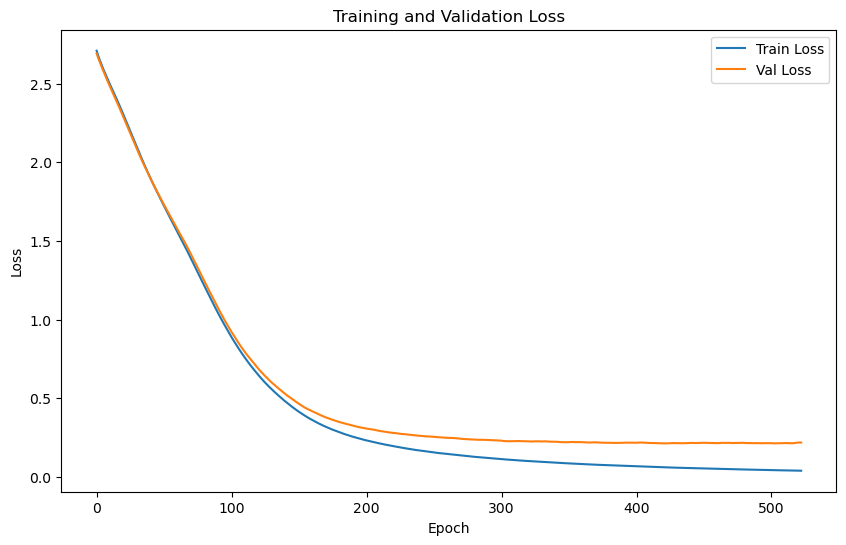

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.4609 | Test Accuracy: 85.99%


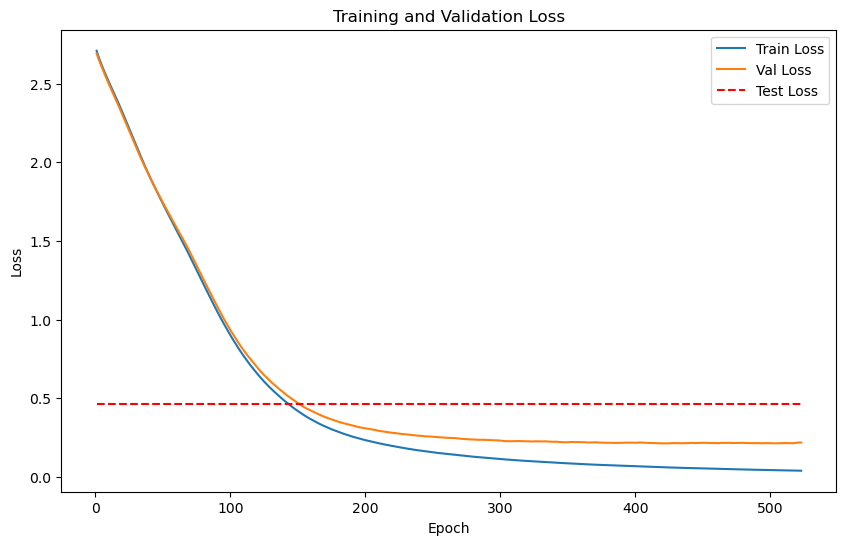

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


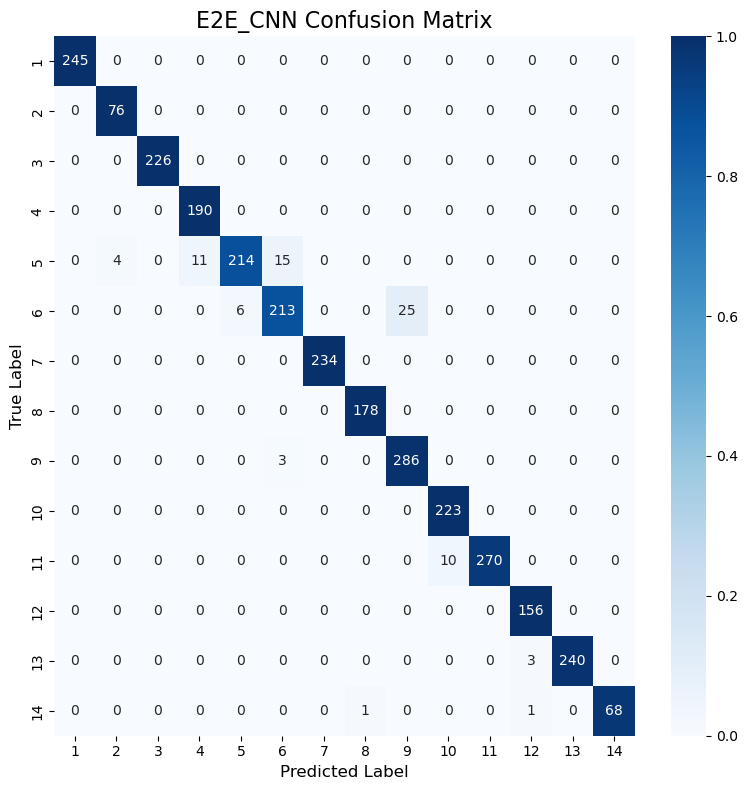

Classification Accuracy: 97.27%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


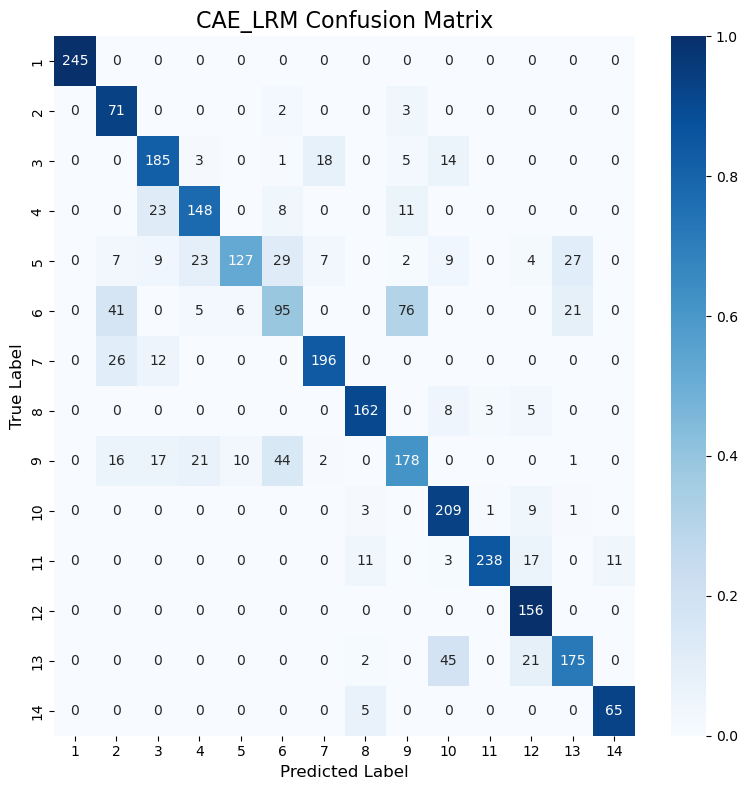

Classification Accuracy: 77.64%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


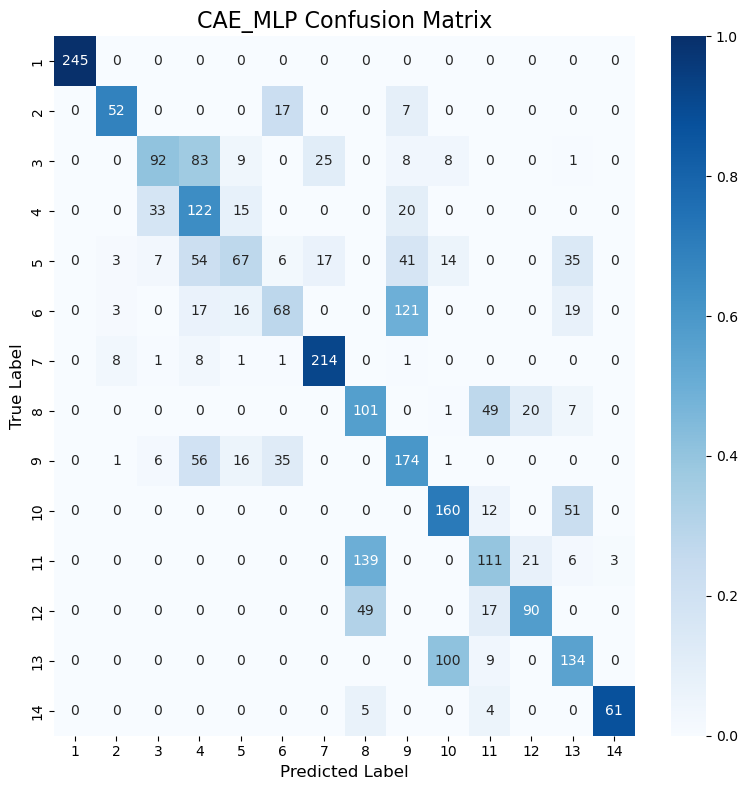

Classification Accuracy: 58.35%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


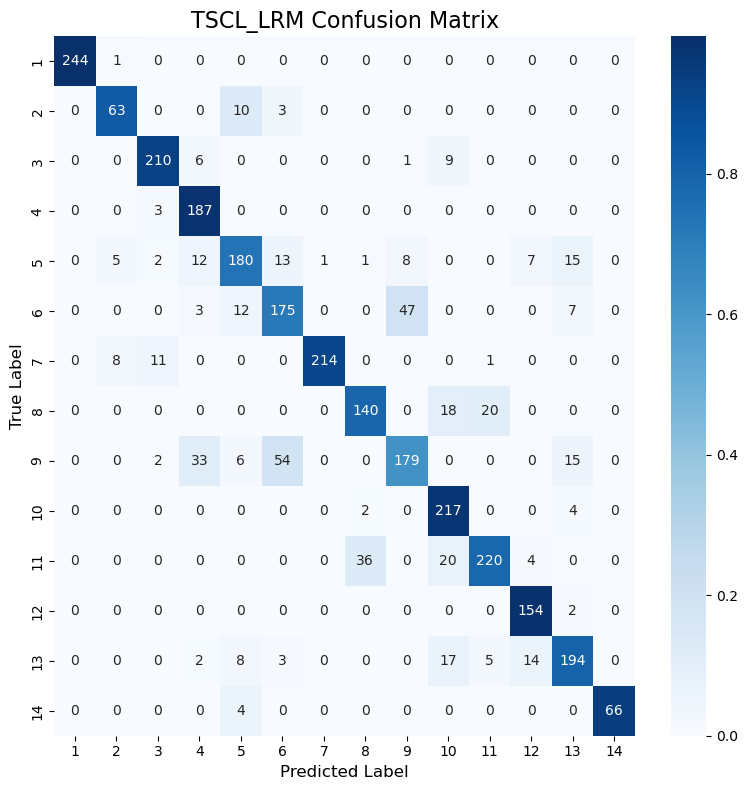

Classification Accuracy: 84.30%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


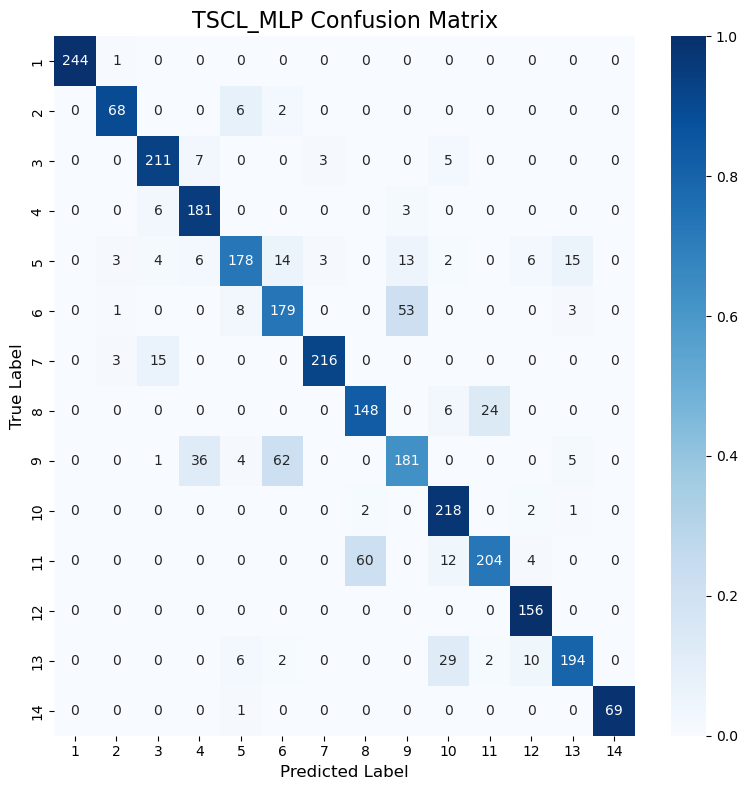

Classification Accuracy: 84.44%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


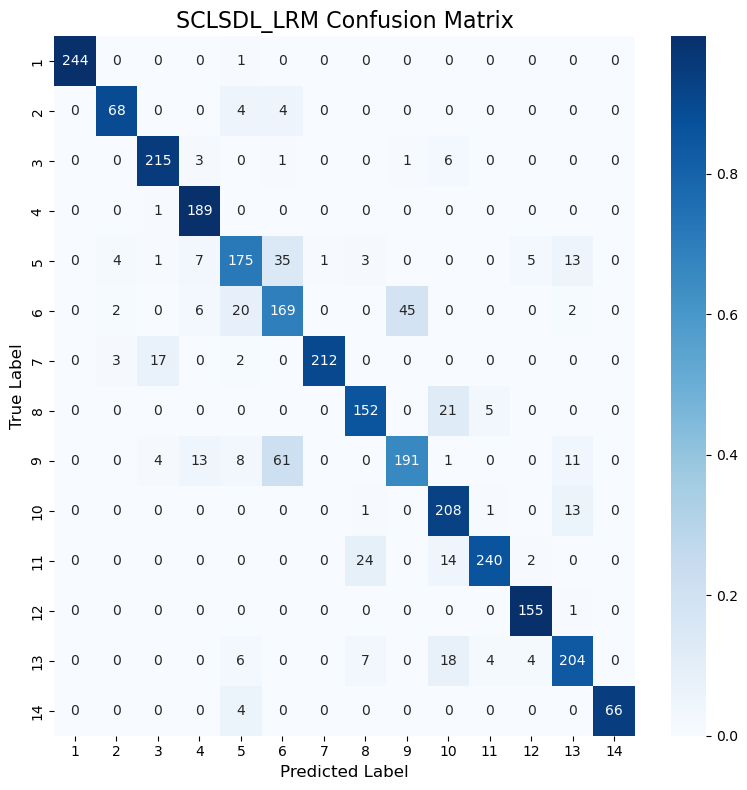

Classification Accuracy: 85.85%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


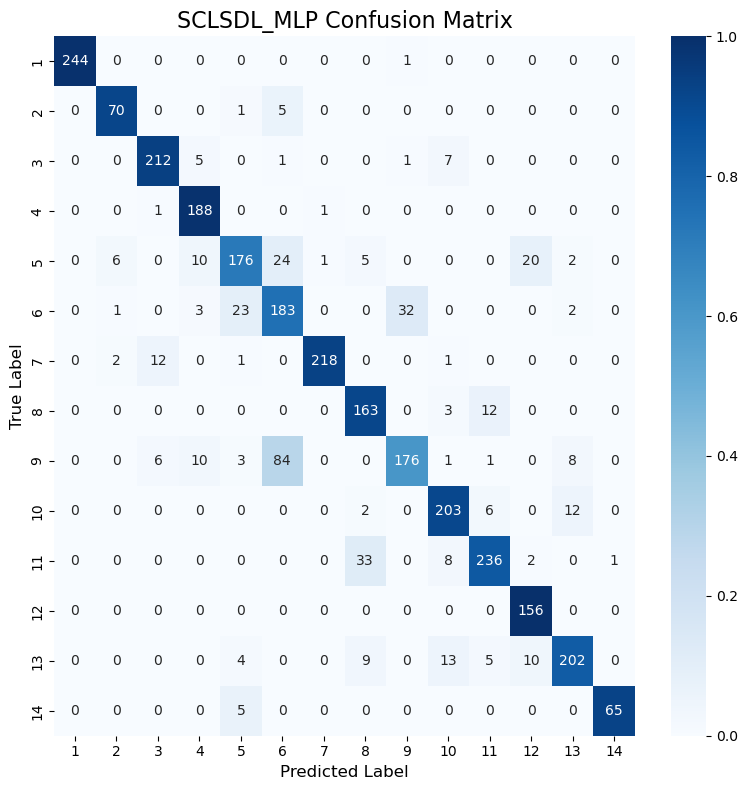

Classification Accuracy: 85.99%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.27
1    LRM (CAE)          77.64
2    MLP (CAE)          58.35
3     TSCL LRM          84.30
4     TSCL MLP          84.44
5  SCL_SDL LRM          85.85
6  SCL_SDL MLP          85.99

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.27
6  SCL_SDL MLP          85.99
5  SCL_SDL LRM          85.85
4     TSCL MLP          84.44
3     TSCL LRM          84.30
1    LRM (CAE)          77.64
2    MLP (CAE)          58.35
